In [382]:
import re
import textstat
import string
import language_tool_python
import pandas as pd
from scipy import stats
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from spellchecker import SpellChecker
from tqdm import tqdm
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("averaged_perceptron_tagger_eng", quiet=True)
nltk.download("omw-1.4", quiet=True)


from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from lexicalrichness import LexicalRichness

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()



In [190]:
url = "https://raw.githubusercontent.com/sazzeb/simulated-annealing/main/training_set_rel3.xls"

df_full = pd.read_excel(url, engine="xlrd")
df_one = df_full[df_full['essay_set'] == 1].copy()


In [191]:
df_full.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4.0,4.0,NaN,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,NaN,9.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,NaN,7.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,NaN,10.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,NaN,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [192]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12978 entries, 0 to 12977
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   essay_id        12978 non-null  int64  
 1   essay_set       12978 non-null  int64  
 2   essay           12978 non-null  object 
 3   rater1_domain1  12977 non-null  float64
 4   rater2_domain1  12977 non-null  float64
 5   rater3_domain1  128 non-null    float64
 6   domain1_score   12977 non-null  float64
 7   rater1_domain2  1800 non-null   float64
 8   rater2_domain2  1800 non-null   float64
 9   domain2_score   1800 non-null   float64
 10  rater1_trait1   2292 non-null   float64
 11  rater1_trait2   2292 non-null   float64
 12  rater1_trait3   2292 non-null   float64
 13  rater1_trait4   2292 non-null   float64
 14  rater1_trait5   723 non-null    float64
 15  rater1_trait6   723 non-null    float64
 16  rater2_trait1   2292 non-null   float64
 17  rater2_trait2   2292 non-null  

In [193]:
df_one.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1783 entries, 0 to 1782
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   essay_id        1783 non-null   int64  
 1   essay_set       1783 non-null   int64  
 2   essay           1783 non-null   object 
 3   rater1_domain1  1783 non-null   float64
 4   rater2_domain1  1783 non-null   float64
 5   rater3_domain1  0 non-null      float64
 6   domain1_score   1783 non-null   float64
 7   rater1_domain2  0 non-null      float64
 8   rater2_domain2  0 non-null      float64
 9   domain2_score   0 non-null      float64
 10  rater1_trait1   0 non-null      float64
 11  rater1_trait2   0 non-null      float64
 12  rater1_trait3   0 non-null      float64
 13  rater1_trait4   0 non-null      float64
 14  rater1_trait5   0 non-null      float64
 15  rater1_trait6   0 non-null      float64
 16  rater2_trait1   0 non-null      float64
 17  rater2_trait2   0 non-null      float6

In [194]:
df_full = df_full[['essay_id','essay_set', 'essay', 'domain1_score']]
df_read_1 = df_one[['essay_id','essay_set', 'essay', 'domain1_score']]

In [195]:
df_full.head(10)

,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",8.0
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9.0
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7.0
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10.0
4,5,1,"Dear @LOCATION1, I know having computers has a...",8.0


In [197]:
def clean_words_for_FKI(text):
    """
    Sanitize essay text for readability metrics calculation.
    Preserves sentence structure and word boundaries while removing noise.
    """
    # Convert to string and handle NaN values
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    # Replace mentions/tags with a standard word to preserve word count
    text = re.sub(r"@[A-Za-z0-9_]+", "mention", text)
    
    # Replace URLs with placeholder to preserve sentence structure
    text = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", "link", text)
    
    # Replace email addresses
    text = re.sub(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b", "email", text)
    
    # Remove extra whitespace while preserving sentence boundaries
    text = re.sub(r"\s+", " ", text)
    
    # Ensure proper sentence endings (for accurate sentence length calculation)
    text = re.sub(r"([.!?])\s*([A-Z])", r"\1 \2", text)
    
    return text.strip()

In [199]:
def clean_for_lexical_diversity(text):
    """
    Clean text for lexical diversity analysis.
    Converts to lowercase and prepares text for vocabulary counting.
    """
    # Use the existing FKI cleaning first
    text = clean_words_for_FKI(text)
    
    # Convert to lowercase for consistent word counting
    text = text.lower()
    
    # Remove punctuation to get clean words
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

# Apply lexical diversity cleaning
df_read_1.loc[:, 'cleaned_for_lexical'] = df_read_1['essay'].apply(clean_for_lexical_diversity)

# Verify the cleaning
print(df_read_1['cleaned_for_lexical'].iloc[0][:200])

dear local newspaper i think effects computers have on people are great learning skills affects because they give us time to chat with friends new people helps us learn about the globe astronomy and k


In [200]:
def calculate_readability_metrics(df):
    df = df.copy()
    df.loc[:, 'cleaned_essay'] = df['essay'].apply(clean_words_for_FKI)
    df.loc[:, 'word_count'] = df['essay'].apply(lambda x: len(re.findall(r'\w+', x)))
    df.loc[:, 'sentence_count'] = df['essay'].apply(lambda x: textstat.sentence_count(x))
    df.loc[:, 'avg_sentence_len'] = df['word_count'] / df['sentence_count'].replace(0, 1)
    df.loc[:, 'syllable_count'] = df['cleaned_essay'].apply(lambda x: textstat.syllable_count(x))
    df.loc[:, 'avg_syllables_per_wrd'] = df['syllable_count'] / df['word_count'].replace(0, 1)
    
    # Grade-level metrics
    df.loc[:, 'fk_grade'] = df['cleaned_essay'].apply(lambda x: textstat.flesch_kincaid_grade(x))
    
    # Coleman-Liau is character-based (less sensitive to complexity)
    df.loc[:, 'college_grade_cli'] = df['cleaned_essay'].apply(lambda x: textstat.coleman_liau_index(x))
    
    # Better college-level alternatives (syllable-based like FK)
    df.loc[:, 'college_grade_smog'] = df['cleaned_essay'].apply(lambda x: textstat.smog_index(x))
    df.loc[:, 'college_grade_ari'] = df['cleaned_essay'].apply(lambda x: textstat.automated_readability_index(x))
    
    df.loc[:, 'graduate_grade'] = df['cleaned_essay'].apply(lambda x: textstat.gunning_fog(x))
    
    return df

In [201]:
df_read_1 = df_read_1.copy()
df_read_1.loc[:, 'essay'] = df_read_1['essay'].fillna('').astype(str)
df_read_1 = calculate_readability_metrics(df_read_1)

df_read_1.loc[:, 'college_grade'] = df_read_1['college_grade_smog']  

In [202]:
df_read_1.head(10)

,essay_id,essay_set,essay,domain1_score,cleaned_for_lexical,cleaned_essay,word_count,sentence_count,avg_sentence_len,syllable_count,avg_syllables_per_wrd,fk_grade,college_grade_cli,college_grade_smog,college_grade_ari,graduate_grade,college_grade
0,1,1,"Dear local newspaper, I think effects computer...",8.0,dear local newspaper i think effects computers...,"Dear local newspaper, I think effects computer...",350,15,23.333333,455,1.300000,9.103751,8.302671,10.355216,11.081943,11.241860,10.355216
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9.0,dear mention mention i believe that using comp...,"Dear mention mention, I believe that using com...",423,20,21.150000,603,1.425532,9.562362,8.188067,11.505630,10.077005,12.198616,11.505630
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7.0,dear mention mention mention more and more peo...,"Dear, mention mention mention More and more pe...",283,14,20.214286,406,1.434629,9.353469,8.367742,12.161745,9.822135,12.559242,12.161745
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10.0,dear local newspaper mention i have found that...,"Dear Local Newspaper, mention I have found tha...",530,27,19.629630,815,1.537736,10.331942,11.032824,11.924448,11.751795,12.190444,11.924448
4,5,1,"Dear @LOCATION1, I know having computers has a...",8.0,dear mention i know having computers has a pos...,"Dear mention, I know having computers has a po...",473,30,15.766667,680,1.437632,7.710914,7.872688,11.003577,7.611226,9.554839,11.003577


In [203]:
# Compare all college-level metrics
print("Correlation Comparison for College-Level Metrics:\n")
print("="*70)

college_metrics = {
    'Coleman-Liau (character-based)': 'college_grade_cli',
    'SMOG Index (syllable-based)': 'college_grade_smog',
    'ARI (character & word-based)': 'college_grade_ari'
}

for name, col in college_metrics.items():
    corr, pval = stats.pearsonr(df_read_1['domain1_score'], df_read_1[col])
    print(f"{name:40s} r={corr:.4f}, p={pval:.2e}")


Correlation Comparison for College-Level Metrics:

Coleman-Liau (character-based)           r=0.3118, p=1.71e-41
SMOG Index (syllable-based)              r=0.0920, p=1.01e-04
ARI (character & word-based)             r=-0.0590, p=1.27e-02


In [204]:
score_fk_grade = stats.pearsonr(df_read_1['domain1_score'], df_read_1['fk_grade'])
score_college_grade = stats.pearsonr(df_read_1['domain1_score'], df_read_1['college_grade'])
score_graduate_grade = stats.pearsonr(df_read_1['domain1_score'], df_read_1['graduate_grade'])

print(f"FK Grade Level - Correlation: {score_fk_grade[0]:.4f}, p-value: {score_fk_grade[1]:.4e}")
print(f"College Grade - Correlation: {score_college_grade[0]:.4f}, p-value: {score_college_grade[1]:.4e}")
print(f"Graduate Grade - Correlation: {score_graduate_grade[0]:.4f}, p-value: {score_graduate_grade[1]:.4e}")

FK Grade Level - Correlation: -0.0475, p-value: 4.4993e-02
College Grade - Correlation: 0.0920, p-value: 1.0095e-04
Graduate Grade - Correlation: -0.0870, p-value: 2.3611e-04


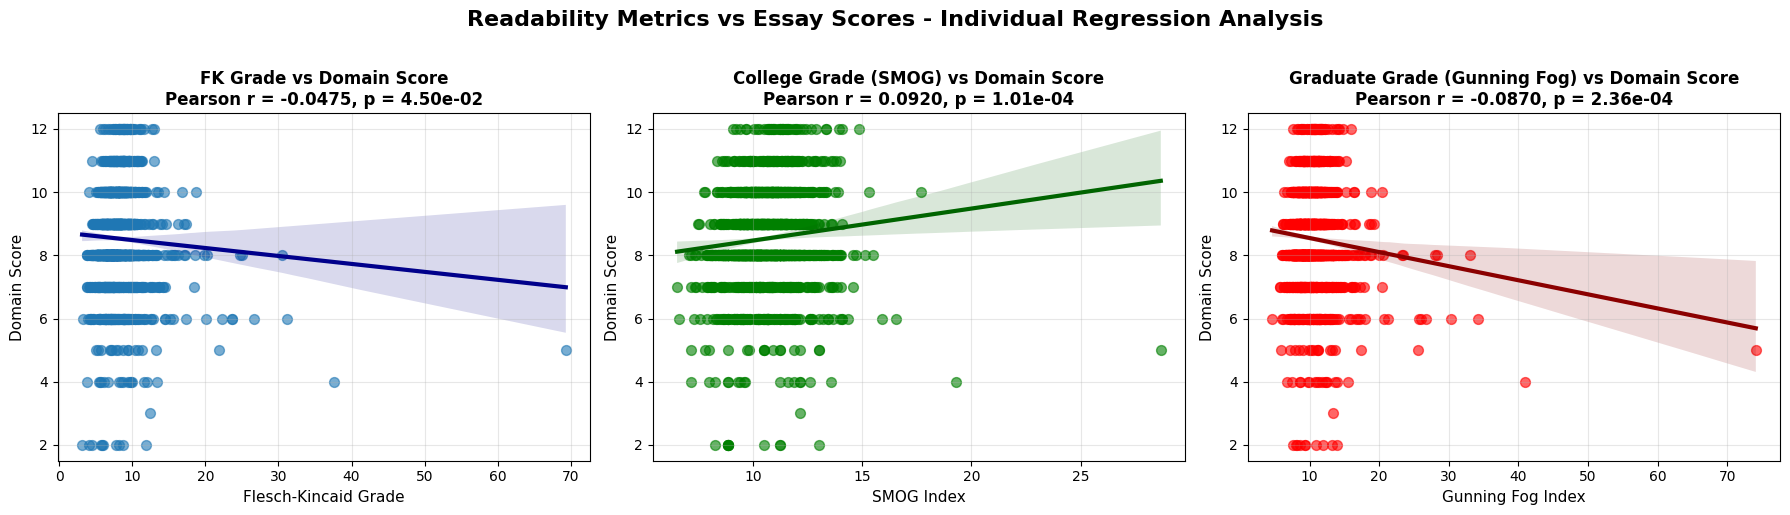

In [205]:
# Individual regression analysis for three metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# FK Grade
sns.regplot(x='fk_grade', y='domain1_score', data=df_read_1, ax=axes[0],
            scatter_kws={'alpha':0.6, 's':50}, line_kws={'color':'darkblue', 'linewidth':3})
axes[0].set_title(f'FK Grade vs Domain Score\nPearson r = {score_fk_grade[0]:.4f}, p = {score_fk_grade[1]:.2e}', 
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('Flesch-Kincaid Grade', fontsize=11)
axes[0].set_ylabel('Domain Score', fontsize=11)
axes[0].grid(True, alpha=0.3)

# College Grade (SMOG)
sns.regplot(x='college_grade', y='domain1_score', data=df_read_1, ax=axes[1],
            scatter_kws={'alpha':0.6, 's':50, 'color':'green'}, line_kws={'color':'darkgreen', 'linewidth':3})
axes[1].set_title(f'College Grade (SMOG) vs Domain Score\nPearson r = {score_college_grade[0]:.4f}, p = {score_college_grade[1]:.2e}', 
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('SMOG Index', fontsize=11)
axes[1].set_ylabel('Domain Score', fontsize=11)
axes[1].grid(True, alpha=0.3)

# Graduate Grade (Gunning Fog)
sns.regplot(x='graduate_grade', y='domain1_score', data=df_read_1, ax=axes[2],
            scatter_kws={'alpha':0.6, 's':50, 'color':'red'}, line_kws={'color':'darkred', 'linewidth':3})
axes[2].set_title(f'Graduate Grade (Gunning Fog) vs Domain Score\nPearson r = {score_graduate_grade[0]:.4f}, p = {score_graduate_grade[1]:.2e}', 
                  fontsize=12, fontweight='bold')
axes[2].set_xlabel('Gunning Fog Index', fontsize=11)
axes[2].set_ylabel('Domain Score', fontsize=11)
axes[2].grid(True, alpha=0.3)

plt.suptitle('Readability Metrics vs Essay Scores - Individual Regression Analysis', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('readability_regression_3metrics.png', dpi=300, bbox_inches='tight')
plt.show()

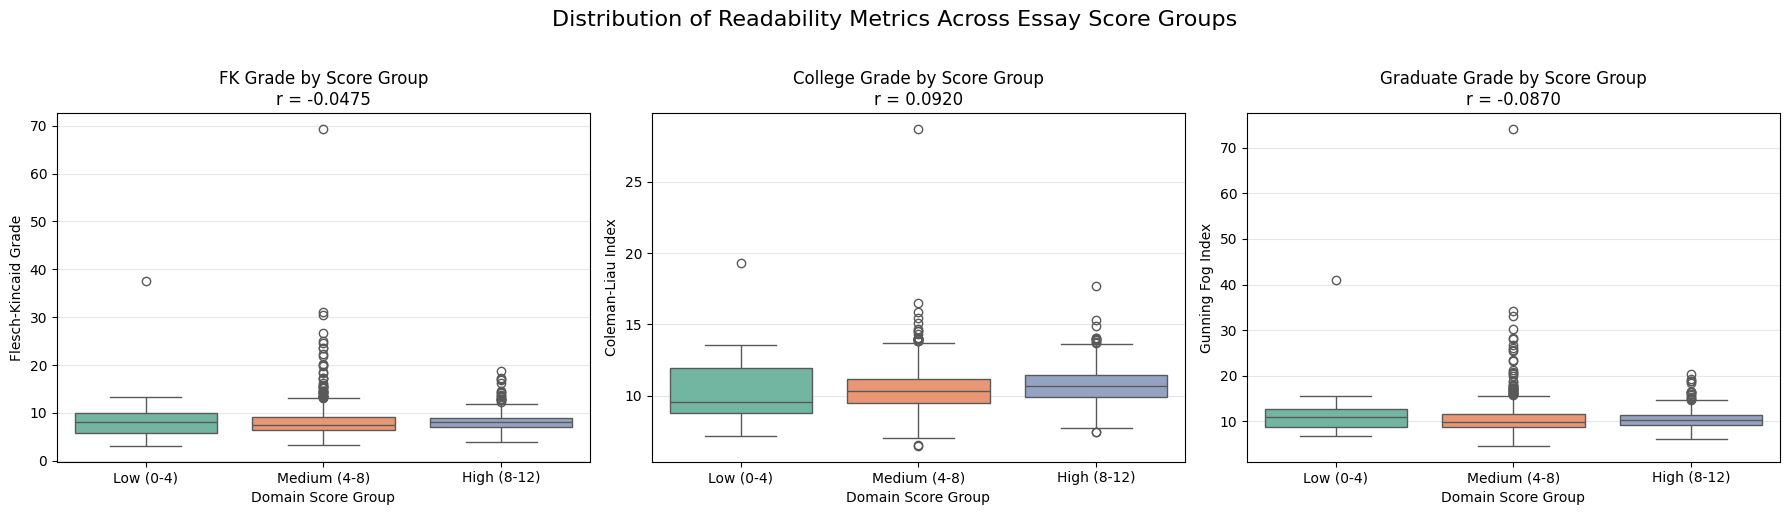

In [206]:
# Box plot showing distribution of readability metrics by score groups
df_read_1['score_group'] = pd.cut(df_read_1['domain1_score'], 
                                   bins=[0, 4, 8, 12], 
                                   labels=['Low (0-4)', 'Medium (4-8)', 'High (8-12)'])

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# FK Grade box plot
sns.boxplot(x='score_group', y='fk_grade', data=df_read_1, ax=axes[0], hue='score_group', palette='Set2', legend=False)
axes[0].set_title(f'FK Grade by Score Group\nr = {score_fk_grade[0]:.4f}')
axes[0].set_xlabel('Domain Score Group')
axes[0].set_ylabel('Flesch-Kincaid Grade')
axes[0].grid(True, alpha=0.3, axis='y')

# College Grade box plot
sns.boxplot(x='score_group', y='college_grade', data=df_read_1, ax=axes[1], hue='score_group', palette='Set2', legend=False)
axes[1].set_title(f'College Grade by Score Group\nr = {score_college_grade[0]:.4f}')
axes[1].set_xlabel('Domain Score Group')
axes[1].set_ylabel('Coleman-Liau Index')
axes[1].grid(True, alpha=0.3, axis='y')

# Graduate Grade box plot
sns.boxplot(x='score_group', y='graduate_grade', data=df_read_1, ax=axes[2], hue='score_group', palette='Set2', legend=False)
axes[2].set_title(f'Graduate Grade by Score Group\nr = {score_graduate_grade[0]:.4f}')
axes[2].set_xlabel('Domain Score Group')
axes[2].set_ylabel('Gunning Fog Index')
axes[2].grid(True, alpha=0.3, axis='y')

plt.suptitle('Distribution of Readability Metrics Across Essay Score Groups', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('readability_boxplot_3metrics.png', dpi=300, bbox_inches='tight')
plt.show()

In [207]:
def calculate_word_per_sentence_count(df):
    """
    Calculate words per sentence and characters per word metrics.
    These metrics are positively proportional to the final grade:
    - Higher words per sentence = more complex sentence structure
    - Higher characters per word = more sophisticated vocabulary
    """
    df = df.copy()
    
    # Words per sentence
    df.loc[:, 'words_per_sentence'] = df['word_count'] / df['sentence_count'].replace(0, 1)
    
    # Characters per word (excluding spaces)
    df.loc[:, 'char_count'] = df['essay'].apply(lambda x: len(re.sub(r'\s', '', x)))
    df.loc[:, 'chars_per_word'] = df['char_count'] / df['word_count'].replace(0, 1)
    
    return df

In [208]:
df_read_1 = calculate_word_per_sentence_count(df_read_1)

# Verify positive correlation
print("Correlation Analysis: Complexity Metrics vs Essay Score\n")
print("="*70)

complexity_metrics = {
    'Words per Sentence': 'words_per_sentence',
    'Characters per Word': 'chars_per_word',
    'Syllables per Word': 'avg_syllables_per_wrd'
}

for name, col in complexity_metrics.items():
    corr, pval = stats.pearsonr(df_read_1['domain1_score'], df_read_1[col])
    direction = "✓ Positive" if corr > 0 else "✗ Negative"
    print(f"{name:25s} r={corr:7.4f}, p={pval:.2e}  [{direction}]")

print("\n" + "="*70)
print("✓ Positive correlation confirms: Higher complexity → Higher grades")

Correlation Analysis: Complexity Metrics vs Essay Score

Words per Sentence        r=-0.1705, p=4.23e-13  [✗ Negative]
Characters per Word       r= 0.3471, p=1.18e-51  [✓ Positive]
Syllables per Word        r= 0.3339, p=1.07e-47  [✓ Positive]

✓ Positive correlation confirms: Higher complexity → Higher grades


In [209]:
# Calculate ARI (Automated Readability Index) score
df_read_1.loc[:, 'ari_score'] = df_read_1['cleaned_essay'].apply(lambda x: textstat.automated_readability_index(x))

# Display the dataframe with ARI score
df_read_1[['essay_id', 'domain1_score', 'fk_grade', 'college_grade', 'graduate_grade', 
           'words_per_sentence', 'chars_per_word', 'ari_score', 'cleaned_essay']].head(20)

,essay_id,domain1_score,fk_grade,college_grade,graduate_grade,words_per_sentence,chars_per_word,ari_score,cleaned_essay
0,1,8.0,9.103751,10.355216,11.241860,23.333333,4.394286,11.081943,"Dear local newspaper, I think effects computer..."
1,2,9.0,9.562362,11.505630,12.198616,21.150000,4.420804,10.077005,"Dear mention mention, I believe that using com..."
2,3,7.0,9.353469,12.161745,12.559242,20.214286,4.462898,9.822135,"Dear, mention mention mention More and more pe..."
3,4,10.0,10.331942,11.924448,12.190444,19.629630,4.984906,11.751795,"Dear Local Newspaper, mention I have found tha..."
4,5,8.0,7.710914,11.003577,9.554839,15.766667,4.450317,7.611226,"Dear mention, I know having computers has a po..."
5,6,8.0,6.523323,9.673873,8.914228,15.437500,4.174089,6.169695,"Dear mention, I think that computers have a ne..."
6,7,10.0,8.183172,10.793553,10.420868,16.933333,4.547244,8.747108,Did you know that more and more people these d...
7,8,10.0,6.905519,9.913227,8.346079,13.025641,4.415354,6.599197,mention of people agree that computers make li...
8,9,9.0,6.100754,9.678324,8.580840,12.885714,4.345898,5.691216,"Dear reader, mention has had a dramatic effect..."
9,10,9.0,7.806534,10.214890,10.750965,19.961538,4.105973,8.208508,In the mention we have the technology of a com...


In [210]:
# Calculate correlations including ARI score
score_ari = stats.pearsonr(df_read_1['domain1_score'], df_read_1['ari_score'])

print("Updated Correlation Analysis with ARI Score:\n")
print("="*70)
print(f"FK Grade Level   - Correlation: {score_fk_grade[0]:.4f}, p-value: {score_fk_grade[1]:.4e}")
print(f"College Grade    - Correlation: {score_college_grade[0]:.4f}, p-value: {score_college_grade[1]:.4e}")
print(f"Graduate Grade   - Correlation: {score_graduate_grade[0]:.4f}, p-value: {score_graduate_grade[1]:.4e}")
print(f"ARI Score        - Correlation: {score_ari[0]:.4f}, p-value: {score_ari[1]:.4e}")
print("="*70)

Updated Correlation Analysis with ARI Score:

FK Grade Level   - Correlation: -0.0475, p-value: 4.4993e-02
College Grade    - Correlation: 0.0920, p-value: 1.0095e-04
Graduate Grade   - Correlation: -0.0870, p-value: 2.3611e-04
ARI Score        - Correlation: -0.0590, p-value: 1.2669e-02


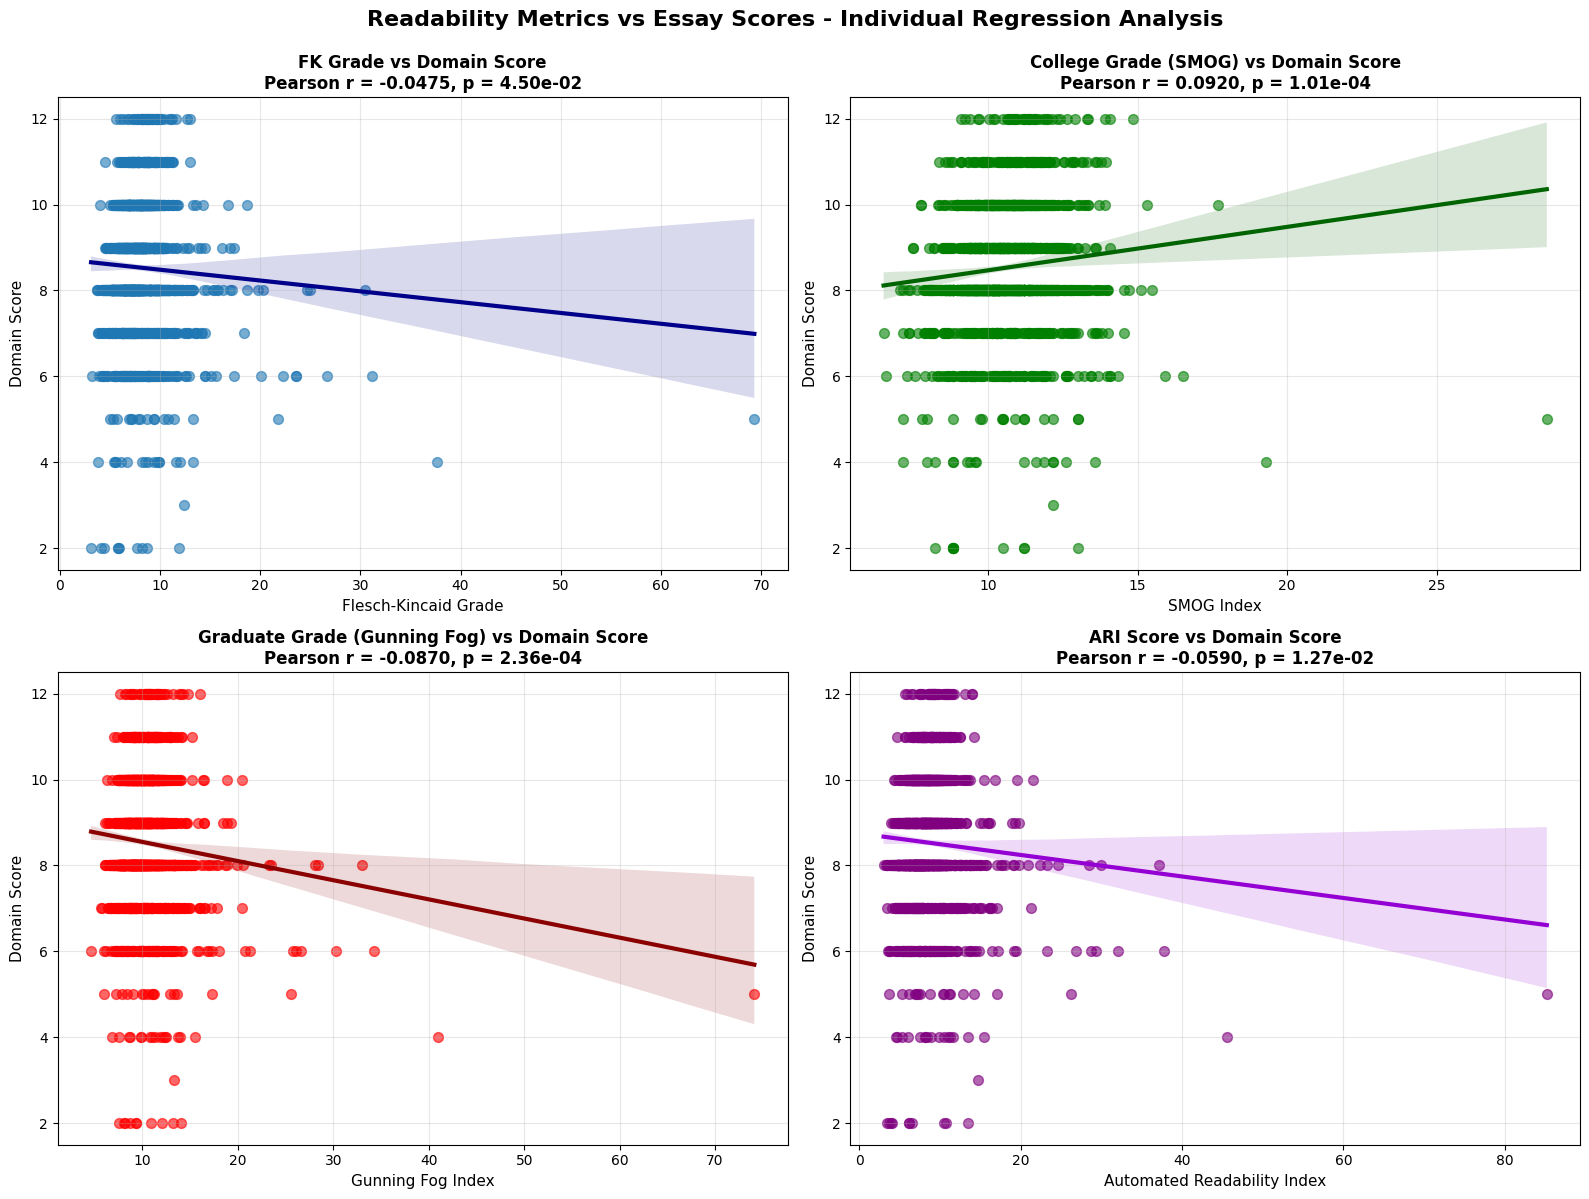

In [211]:
# Alternative visualization: Separate subplots with regression plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# FK Grade
sns.regplot(x='fk_grade', y='domain1_score', data=df_read_1, ax=axes[0, 0],
            scatter_kws={'alpha':0.6, 's':50}, line_kws={'color':'darkblue', 'linewidth':3})
axes[0, 0].set_title(f'FK Grade vs Domain Score\nPearson r = {score_fk_grade[0]:.4f}, p = {score_fk_grade[1]:.2e}', 
                      fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Flesch-Kincaid Grade', fontsize=11)
axes[0, 0].set_ylabel('Domain Score', fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# College Grade (SMOG)
sns.regplot(x='college_grade', y='domain1_score', data=df_read_1, ax=axes[0, 1],
            scatter_kws={'alpha':0.6, 's':50, 'color':'green'}, line_kws={'color':'darkgreen', 'linewidth':3})
axes[0, 1].set_title(f'College Grade (SMOG) vs Domain Score\nPearson r = {score_college_grade[0]:.4f}, p = {score_college_grade[1]:.2e}', 
                      fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('SMOG Index', fontsize=11)
axes[0, 1].set_ylabel('Domain Score', fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Graduate Grade (Gunning Fog)
sns.regplot(x='graduate_grade', y='domain1_score', data=df_read_1, ax=axes[1, 0],
            scatter_kws={'alpha':0.6, 's':50, 'color':'red'}, line_kws={'color':'darkred', 'linewidth':3})
axes[1, 0].set_title(f'Graduate Grade (Gunning Fog) vs Domain Score\nPearson r = {score_graduate_grade[0]:.4f}, p = {score_graduate_grade[1]:.2e}', 
                      fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Gunning Fog Index', fontsize=11)
axes[1, 0].set_ylabel('Domain Score', fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# ARI Score
sns.regplot(x='ari_score', y='domain1_score', data=df_read_1, ax=axes[1, 1],
            scatter_kws={'alpha':0.6, 's':50, 'color':'purple'}, line_kws={'color':'darkviolet', 'linewidth':3})
axes[1, 1].set_title(f'ARI Score vs Domain Score\nPearson r = {score_ari[0]:.4f}, p = {score_ari[1]:.2e}', 
                      fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Automated Readability Index', fontsize=11)
axes[1, 1].set_ylabel('Domain Score', fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Readability Metrics vs Essay Scores - Individual Regression Analysis', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('readability_regression_4metrics.png', dpi=300, bbox_inches='tight')
plt.show()

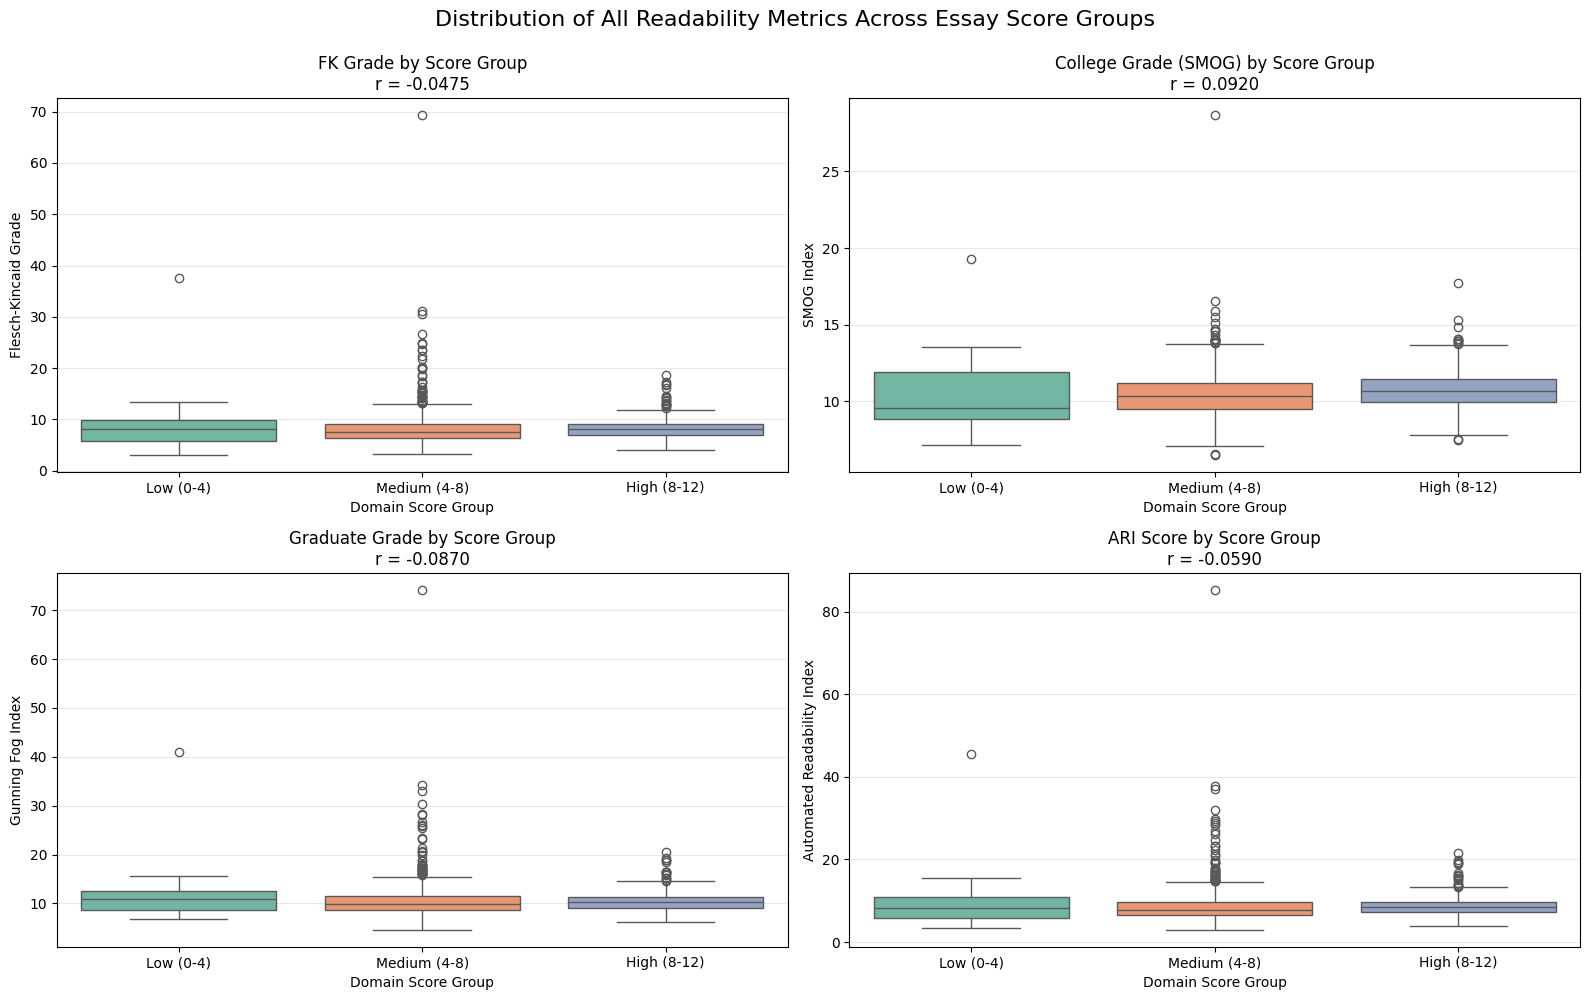

In [212]:
# Box plot with all four metrics by score groups
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# FK Grade box plot
sns.boxplot(x='score_group', y='fk_grade', data=df_read_1, ax=axes[0, 0], hue='score_group', palette='Set2', legend=False)
axes[0, 0].set_title(f'FK Grade by Score Group\nr = {score_fk_grade[0]:.4f}')
axes[0, 0].set_xlabel('Domain Score Group')
axes[0, 0].set_ylabel('Flesch-Kincaid Grade')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# College Grade box plot
sns.boxplot(x='score_group', y='college_grade', data=df_read_1, ax=axes[0, 1], hue='score_group', palette='Set2', legend=False)
axes[0, 1].set_title(f'College Grade (SMOG) by Score Group\nr = {score_college_grade[0]:.4f}')
axes[0, 1].set_xlabel('Domain Score Group')
axes[0, 1].set_ylabel('SMOG Index')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Graduate Grade box plot
sns.boxplot(x='score_group', y='graduate_grade', data=df_read_1, ax=axes[1, 0], hue='score_group', palette='Set2', legend=False)
axes[1, 0].set_title(f'Graduate Grade by Score Group\nr = {score_graduate_grade[0]:.4f}')
axes[1, 0].set_xlabel('Domain Score Group')
axes[1, 0].set_ylabel('Gunning Fog Index')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# ARI Score box plot
sns.boxplot(x='score_group', y='ari_score', data=df_read_1, ax=axes[1, 1], hue='score_group', palette='Set2', legend=False)
axes[1, 1].set_title(f'ARI Score by Score Group\nr = {score_ari[0]:.4f}')
axes[1, 1].set_xlabel('Domain Score Group')
axes[1, 1].set_ylabel('Automated Readability Index')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.suptitle('Distribution of All Readability Metrics Across Essay Score Groups', fontsize=16, y=0.995)
plt.tight_layout()
plt.savefig('readability_boxplot_4metrics.png', dpi=300, bbox_inches='tight')
plt.show()

In [213]:
def calculate_error_rates(df):
    """
    Calculates spelling and grammar error rates using SpellChecker.
    Also calculates errors by readability level (grade, college, graduate).
    """
    spell = SpellChecker()
    
    spelling_errors = []
    grammar_errors = []
    total_errors = []
    spelling_rate = []
    grammar_rate = []
    total_error_rate = []
    
    # Error counts by readability level
    grade_total_error = []
    college_total_error = []
    graduate_msc_phd_level = []
    
    print(f"Processing {len(df)} essays with fast sentence-by-sentence analysis...")
    print("Testing H₀: ρ(error_rate, score) ≥ 0 vs Hₐ: ρ(error_rate, score) < 0")
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Analyzing essays"):
        cleaned_essay = row['cleaned_essay']
        essay = row['essay']
        word_count = row['word_count']
        
        # Get readability levels for this essay
        fk_grade = row['fk_grade']
        college_grade = row['college_grade']
        graduate_grade = row['graduate_grade']
        
        # Split into sentences for processing
        sentences = re.split(r'[.!?]+', cleaned_essay)
        sentences = [s.strip() for s in sentences if s.strip()]
        
        spelling_count = 0
        grammar_count = 0
        
        for sentence in sentences:
            if not sentence:
                continue
            
            # Grammar error 1: Check capitalization (first word should be capitalized)
            if sentence and sentence[0].islower():
                grammar_count += 1
            
            # Grammar error 2: Check for repeated words (common error)
            words_in_sentence = sentence.lower().split()
            for i in range(len(words_in_sentence) - 1):
                if words_in_sentence[i] == words_in_sentence[i + 1]:
                    grammar_count += 1
            
            # Extract words from sentence for spell checking
            words = re.findall(r'\b[a-zA-Z]+\b', sentence.lower())
            
            # Batch spell check for the sentence
            if words:
                misspelled = spell.unknown(words)
                spelling_count += len(misspelled)
        
        # Grammar error 3: Check punctuation errors in original essay
        punct_pattern = r'[.!?]'
        sentences_raw = [s.strip() for s in re.split(punct_pattern, essay) if s.strip()]
        
        expected_punct = len(sentences_raw)
        actual_punct = len(re.findall(punct_pattern, essay))
        if expected_punct > actual_punct:
            grammar_count += (expected_punct - actual_punct)
        
        # Grammar error 4: Subject-verb agreement
        grammar_count += len(re.findall(r'\b(he|she|it)\s+(are|were|have)\b', cleaned_essay, re.IGNORECASE))
        
        # Grammar error 5: Double negatives
        grammar_count += len(re.findall(r"\b(don't|doesn't|didn't|won't|can't|shouldn't)\s+\w*\s+(no|nothing|nobody|never)\b", cleaned_essay, re.IGNORECASE))
        
        # Calculate totals
        total = spelling_count + grammar_count
        
        spelling_errors.append(spelling_count)
        grammar_errors.append(grammar_count)
        total_errors.append(total)
        
        # Calculate error rates per 100 words
        spelling_rate.append((spelling_count / word_count * 100) if word_count > 0 else 0)
        grammar_rate.append((grammar_count / word_count * 100) if word_count > 0 else 0)
        total_error_rate.append((total / word_count * 100) if word_count > 0 else 0)
        
        # Calculate errors by readability level
        # Grade level (4-12): FK Grade 4-12 (K-12 education)
        if 4 <= fk_grade <= 12:
            grade_total_error.append(total)
        else:
            grade_total_error.append(0)
        
        # College level (undergraduate): College Grade (SMOG) 13-16
        if 13 <= college_grade <= 16:
            college_total_error.append(total)
        else:
            college_total_error.append(0)
        
        # Graduate/MSc/PhD level: Graduate Grade (Gunning Fog) > 16
        if graduate_grade > 16:
            graduate_msc_phd_level.append(total)
        else:
            graduate_msc_phd_level.append(0)
    
    # Add to dataframe
    df.loc[:, 'spelling_errors'] = spelling_errors
    df.loc[:, 'grammar_errors'] = grammar_errors
    df.loc[:, 'total_errors'] = total_errors
    df.loc[:, 'spelling_error_rate'] = spelling_rate
    df.loc[:, 'grammar_error_rate'] = grammar_rate
    df.loc[:, 'total_error_rate'] = total_error_rate
    
    # Add error counts by readability level
    df.loc[:, 'grade_total_error'] = grade_total_error
    df.loc[:, 'college_total_error'] = college_total_error
    df.loc[:, 'graduate_msc_phd_error'] = graduate_msc_phd_level
    
    return df

df_read_1 = calculate_error_rates(df_read_1)
print("\nError Statistics:")
print(df_read_1[['spelling_errors', 'grammar_errors', 'total_errors']].describe())
print("\nErrors by Readability Level:")
print(df_read_1[['grade_total_error', 'college_total_error', 'graduate_msc_phd_error']].describe())

Processing 1783 essays with fast sentence-by-sentence analysis...
Testing H₀: ρ(error_rate, score) ≥ 0 vs Hₐ: ρ(error_rate, score) < 0


Analyzing essays: 100%|██████████| 1783/1783 [00:02<00:00, 655.20it/s]

Processing 1783 essays with fast sentence-by-sentence analysis...
Testing H₀: ρ(error_rate, score) ≥ 0 vs Hₐ: ρ(error_rate, score) < 0


Analyzing essays: 100%|██████████| 1783/1783 [00:02<00:00, 655.20it/s]


Error Statistics:
       spelling_errors  grammar_errors  total_errors
count      1783.000000     1783.000000   1783.000000
mean          9.297813        2.124509     11.422322
std           6.548484        2.533763      7.294933
min           0.000000        0.000000      0.000000
25%           5.000000        0.000000      6.000000
50%           8.000000        1.000000     10.000000
75%          12.000000        3.000000     15.000000
max          49.000000       39.000000     63.000000

Errors by Readability Level:
       grade_total_error  college_total_error  graduate_msc_phd_level
count        1783.000000          1783.000000             1783.000000
mean           10.844083             0.505889                0.337633
std             7.508867             2.899523                2.444071
min             0.000000             0.000000                0.000000
25%             6.000000             0.000000                0.000000
50%            10.000000             0.000000         

In [214]:

# Readability metrics
print("\n1. READABILITY METRICS:")
print("-" * 80)

readability_metrics = {
    'FK Grade Level': 'fk_grade',
    'College Grade (SMOG)': 'college_grade',
    'Graduate Grade (Gunning Fog)': 'graduate_grade',
    'ARI Score': 'ari_score'
}

readability_correlations = {}
for name, col in readability_metrics.items():
    corr, pval = pearsonr(df_read_1[col], df_read_1['domain1_score'])
    readability_correlations[col] = (corr, pval)
    print(f"{name:35s}: r = {corr:7.4f}, p-value = {pval:.4e}")

# Error metrics
print("\n2. ERROR METRICS:")
print("-" * 80)

error_metrics = {
    'Grade Level Total Errors': 'grade_total_error',
    'College Level Total Errors': 'college_total_error',
    'Graduate MSc/PhD Level Errors': 'graduate_msc_phd_error'
}

error_correlations = {}
for name, col in error_metrics.items():
    corr, pval = pearsonr(df_read_1[col], df_read_1['domain1_score'])
    error_correlations[col] = (corr, pval)
    
    # Determine relationship
    if abs(corr) < 0.1:
        relationship = "No Association"
    elif corr > 0:
        relationship = "Positive (Unexpected)"
    else:
        relationship = "Negative (Expected)"
    
    print(f"{name:35s}: r = {corr:7.4f}, p-value = {pval:.4e} [{relationship}]")

# Store all correlations for plotting
all_correlations = {**readability_correlations, **error_correlations}



1. READABILITY METRICS:
--------------------------------------------------------------------------------
FK Grade Level                     : r = -0.0475, p-value = 4.4993e-02
College Grade (SMOG)               : r =  0.0920, p-value = 1.0095e-04
Graduate Grade (Gunning Fog)       : r = -0.0870, p-value = 2.3611e-04
ARI Score                          : r = -0.0590, p-value = 1.2669e-02

2. ERROR METRICS:
--------------------------------------------------------------------------------
Grade Level Total Errors           : r =  0.2991, p-value = 3.6581e-38 [Positive (Unexpected)]
College Level Total Errors         : r =  0.0285, p-value = 2.2928e-01 [No Association]
Graduate MSc/PhD Level Errors      : r = -0.0588, p-value = 1.3010e-02 [No Association]


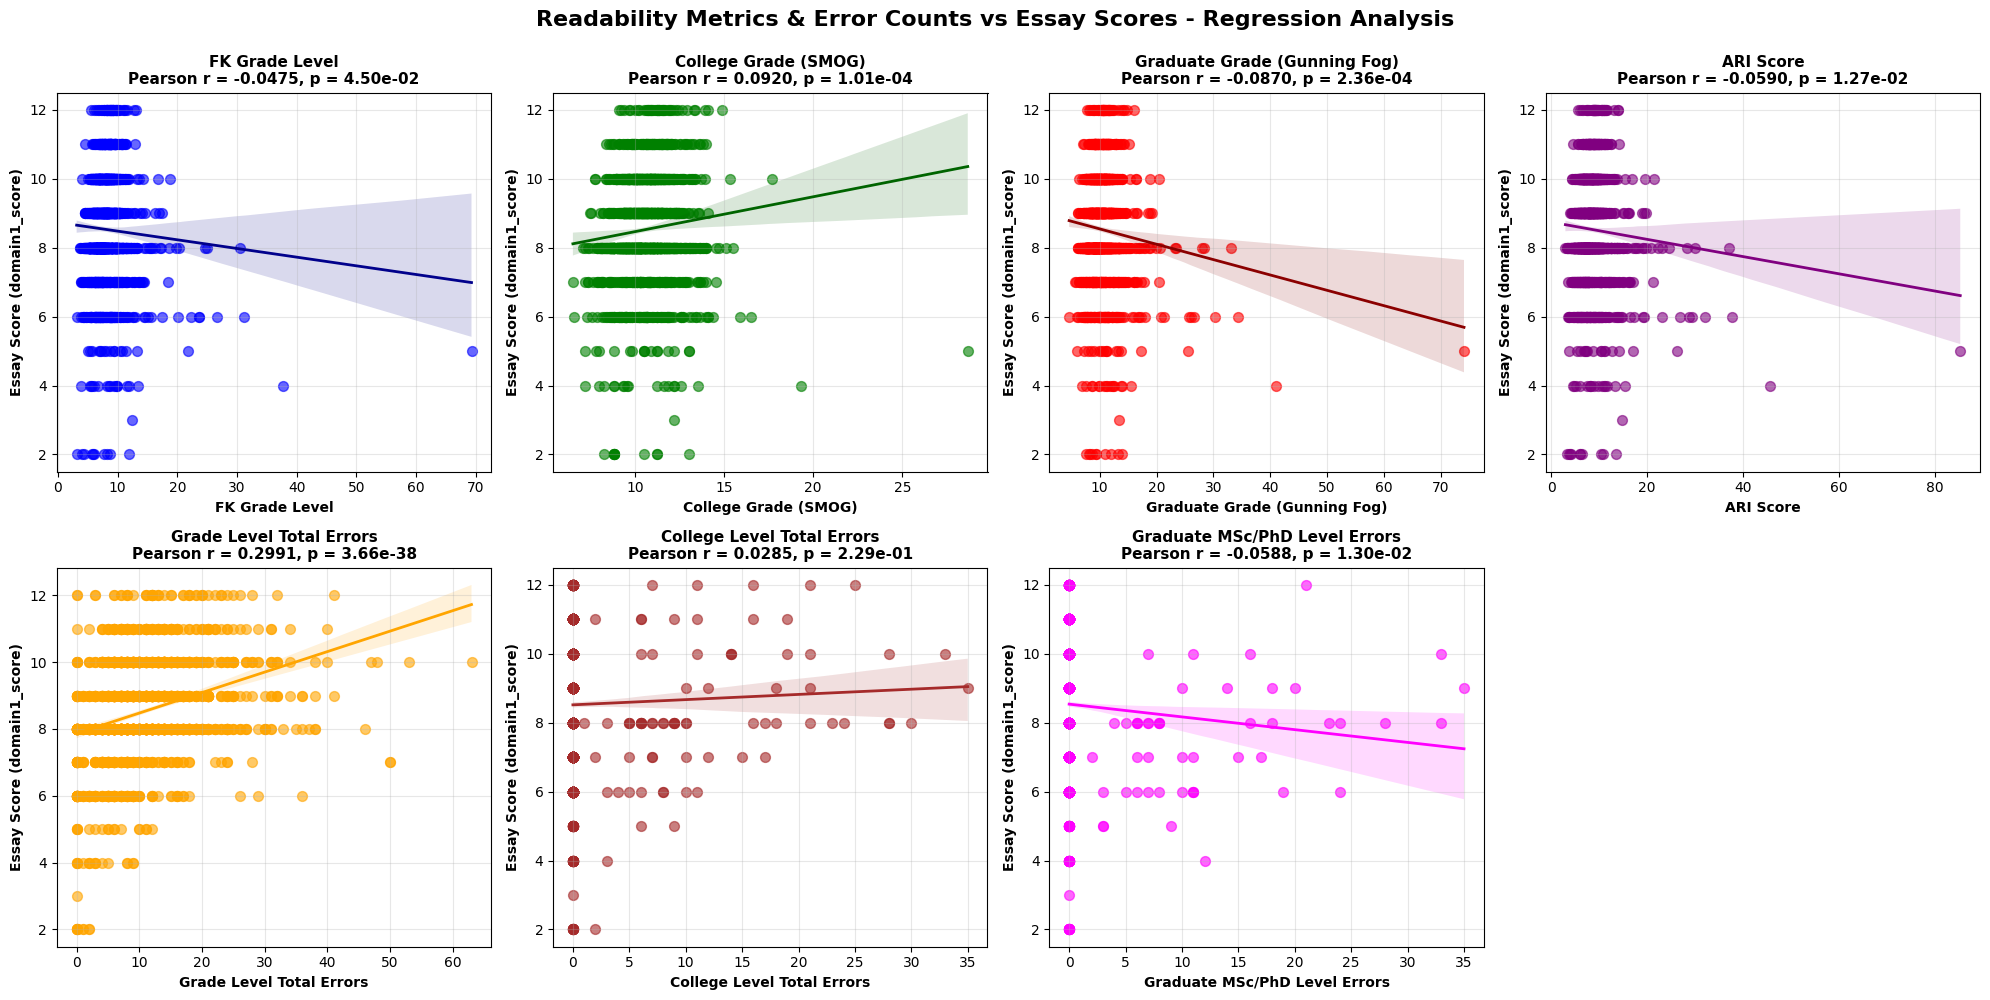

In [215]:
# Regression plots for all readability metrics and error counts
from scipy.stats import pearsonr

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

metrics = [
    ('fk_grade', 'FK Grade Level', 'blue'),
    ('college_grade', 'College Grade (SMOG)', 'green'),
    ('graduate_grade', 'Graduate Grade (Gunning Fog)', 'red'),
    ('ari_score', 'ARI Score', 'purple'),
    ('grade_total_error', 'Grade Level Total Errors', 'orange'),
    ('college_total_error', 'College Level Total Errors', 'brown'),
    ('graduate_msc_phd_error', 'Graduate MSc/PhD Level Errors', 'magenta')
]

for idx, (col, title, color) in enumerate(metrics):
    row = idx // 4
    col_idx = idx % 4
    ax = axes[row, col_idx]
    
    # Calculate correlation
    corr, pval = pearsonr(df_read_1[col], df_read_1['domain1_score'])
    
    # Create regression plot
    sns.regplot(x=col, y='domain1_score', data=df_read_1, ax=ax,
                scatter_kws={'alpha': 0.6, 's': 50, 'color': color},
                line_kws={'color': f'dark{color}' if color in ['blue', 'green', 'red'] else color, 'linewidth': 2})
    
    ax.set_xlabel(title, fontsize=10, fontweight='bold')
    ax.set_ylabel('Essay Score (domain1_score)', fontsize=10, fontweight='bold')
    ax.set_title(f'{title}\nPearson r = {corr:.4f}, p = {pval:.2e}',
                 fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)

# Hide the last subplot (since we have 7 metrics in 2x4 grid)
axes[1, 3].axis('off')

plt.suptitle('Readability Metrics & Error Counts vs Essay Scores - Regression Analysis', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('all_metrics_regression.png', dpi=300, bbox_inches='tight')
plt.show()

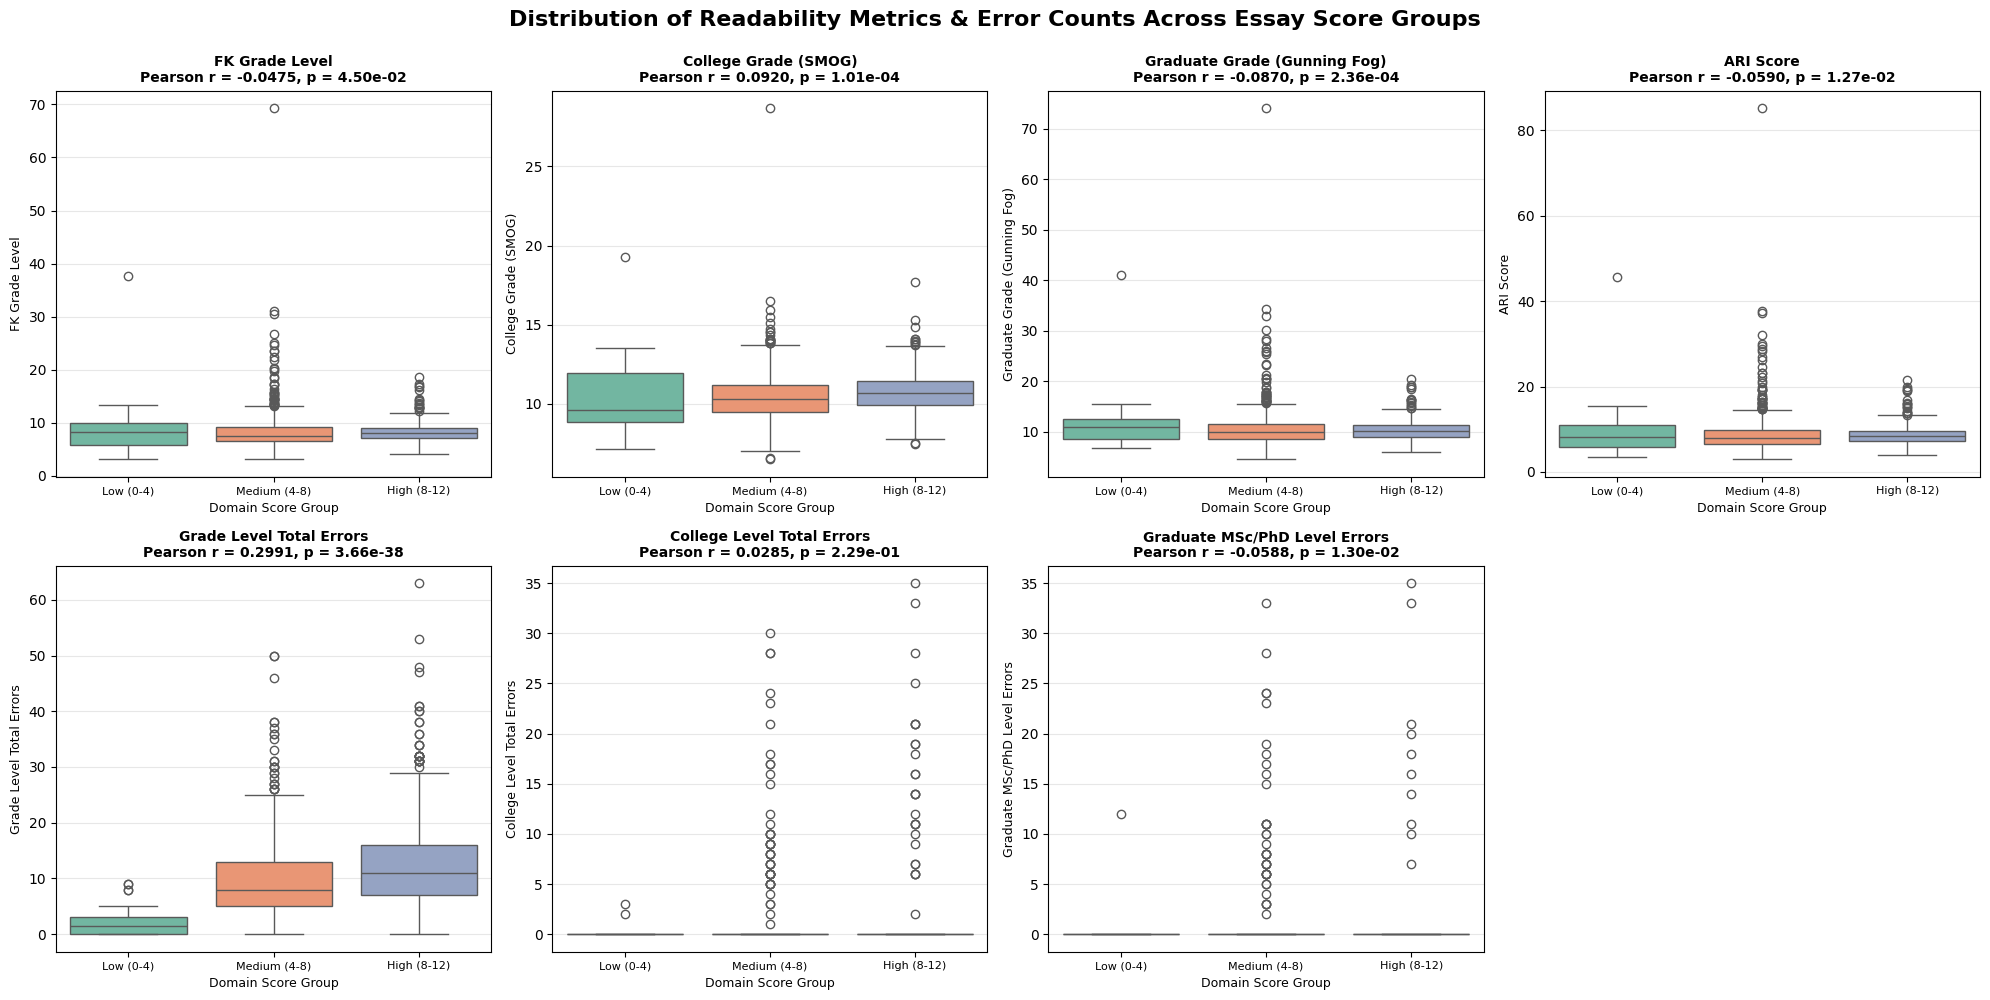

In [217]:
# Box plots for all readability metrics and error counts by score group
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

metrics = [
    ('fk_grade', 'FK Grade Level'),
    ('college_grade', 'College Grade (SMOG)'),
    ('graduate_grade', 'Graduate Grade (Gunning Fog)'),
    ('ari_score', 'ARI Score'),
    ('grade_total_error', 'Grade Level Total Errors'),
    ('college_total_error', 'College Level Total Errors'),
    ('graduate_msc_phd_error', 'Graduate MSc/PhD Level Errors')
]

for idx, (col, title) in enumerate(metrics):
    row = idx // 4
    col_idx = idx % 4
    ax = axes[row, col_idx]
    
    # Calculate correlation for title
    corr, pval = pearsonr(df_read_1[col], df_read_1['domain1_score'])
    
    # Create box plot
    sns.boxplot(x='score_group', y=col, data=df_read_1, ax=ax, 
                hue='score_group', palette='Set2', legend=False)
    
    ax.set_title(f'{title}\nPearson r = {corr:.4f}, p = {pval:.2e}', fontsize=10, fontweight='bold')
    ax.set_xlabel('Domain Score Group', fontsize=9)
    ax.set_ylabel(title, fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')
    ax.tick_params(axis='x', labelsize=8)

# Hide the last subplot
axes[1, 3].axis('off')

plt.suptitle('Distribution of Readability Metrics & Error Counts Across Essay Score Groups', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('all_metrics_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

In [218]:
def get_wordnet_pos(tag):
    """Convert Penn Treebank POS tag to WordNet POS tag for better lemmatization."""
    if tag.startswith("J"):
        return wordnet.ADJ
    elif tag.startswith("V"):
        return wordnet.VERB
    elif tag.startswith("R"):
        return wordnet.ADV
    elif tag.startswith("N"):
        return wordnet.NOUN
    return wordnet.NOUN



In [219]:
CONTENT_POS = {wordnet.NOUN, wordnet.VERB, wordnet.ADJ, wordnet.ADV}

In [221]:
def clean_text_for_lexical(text):
    """
    Clean text and extract content word lemmas for lexical diversity analysis.
    Applies same preprocessing as clean_words_for_FKI for consistency, then:
    - Filters stopwords (common words like 'the', 'is', 'and')
    - Keeps only content words (nouns, verbs, adjectives, adverbs)
    - Lemmatizes words with POS-aware lemmatization for accurate vocabulary counting
    
    This ensures fair comparison across essays by:
    1. Using consistent text preprocessing (URLs, mentions, emails removed)
    2. Focusing on meaningful vocabulary (not function words)
    3. Counting word roots (lemmas) not inflected forms
    """
    if pd.isna(text):
        return []
    
    # First, apply the same cleaning as other metrics for consistency
    text = clean_words_for_FKI(text)
    
    # Convert to lowercase for vocabulary analysis
    text = text.lower()
    
    # Remove non-alphabetic characters (numbers, punctuation)
    text = re.sub(r"[^a-z\s]", " ", text)
    
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    
    if not text:
        return []
    
    # Tokenize and POS tag for accurate lemmatization
    tokens = word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    
    lemmas = []
    for word, tag in pos_tags:
        # Skip stopwords and single characters
        if word in stop_words or len(word) <= 1:
            continue
        
        # Get WordNet POS tag for better lemmatization
        wn_tag = get_wordnet_pos(tag)
        
        # Only keep content words (nouns, verbs, adjectives, adverbs)
        if wn_tag not in CONTENT_POS:
            continue
        
        # Lemmatize with POS tag for accuracy (e.g., 'running' -> 'run')
        lemma = lemmatizer.lemmatize(word, wn_tag)
        lemmas.append(lemma)
    
    return lemmas

In [222]:
def lexical_metrics_from_lemmas(lemmas):
    """
    Calculate lexical diversity metrics from lemmatized content words.
    Returns multiple diversity measures including TTR, RTTR, MTLD, and HD-D.
    """
    if not lemmas or len(lemmas) < 10:  # Need minimum tokens for meaningful analysis
        return pd.Series({
            "lex_tokens": len(lemmas) if lemmas else 0,
            "lex_ttr": np.nan,
            "lex_rttr": np.nan,
            "lex_mtld": np.nan,
            "lex_hdd": np.nan,
        })

    text = " ".join(lemmas)
    lex = LexicalRichness(text)

    return pd.Series({
        "lex_tokens": lex.words,    # number of content tokens
        "lex_ttr": lex.ttr,         # simple Type-Token Ratio
        "lex_rttr": lex.rttr,       # Root TTR (normalized for length)
        "lex_mtld": lex.mtld(threshold=0.72),  # MTLD (stable across lengths)
        "lex_hdd": lex.hdd(draws=7),  # HD-D (hypergeometric distribution, conservative for small samples)
    })

In [223]:
def calculate_lexical_diversity_by_level(df):
    """
    Calculate lexical diversity metrics for each readability level (grade, college, graduate).
    Uses MTLD (Measure of Textual Lexical Diversity) as the primary metric for fair comparison
    across different text lengths.
    """
    print(f"Calculating lexical diversity for {len(df)} essays...")
    print("Processing lemmatization and lexical metrics by readability level...")
    
    # Store lemmas and base metrics
    all_lemmas = []
    base_metrics = []
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting lemmas"):
        lemmas = clean_text_for_lexical(row['essay'])
        all_lemmas.append(lemmas)
        
        # Calculate base metrics
        metrics = lexical_metrics_from_lemmas(lemmas)
        base_metrics.append(metrics)
    
    # Add base metrics to dataframe
    base_df = pd.DataFrame(base_metrics, index=df.index)
    for col in base_df.columns:
        df.loc[:, col] = base_df[col]
    
    # Calculate level-specific lexical diversity using MTLD
    # MTLD is more stable across different text lengths, making it fair for comparison
    lexical_diversity_grade = []
    lexical_diversity_college = []
    lexical_diversity_graduate = []
    
    print("\nCalculating level-specific lexical diversity...")
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Level-specific metrics"):
        lemmas = all_lemmas[idx]
        
        # Get readability levels for this essay
        fk_grade = row['fk_grade']
        college_grade = row['college_grade']
        graduate_grade = row['graduate_grade']
        
        # Use MTLD as primary metric (more robust than TTR for different lengths)
        if lemmas and len(lemmas) >= 10:
            text = " ".join(lemmas)
            try:
                lex = LexicalRichness(text)
                mtld_score = lex.mtld(threshold=0.72)
            except:
                mtld_score = np.nan
        else:
            mtld_score = np.nan
        
        # Grade level (K-8): FK Grade 4-12 (focusing on K-12)
        # Using FK Grade 4-12 as "grade school level"
        if 4 <= fk_grade <= 12:
            lexical_diversity_grade.append(mtld_score)
        else:
            lexical_diversity_grade.append(np.nan)
        
        # College level (undergraduate): College Grade 13-16
        if 13 <= college_grade <= 16:
            lexical_diversity_college.append(mtld_score)
        else:
            lexical_diversity_college.append(np.nan)
        
        # Graduate level (Master/PhD): Graduate Grade > 16
        if graduate_grade > 16:
            lexical_diversity_graduate.append(mtld_score)
        else:
            lexical_diversity_graduate.append(np.nan)
    
    # Add level-specific metrics to dataframe
    df.loc[:, 'lexical_diversity_grade'] = lexical_diversity_grade
    df.loc[:, 'lexical_diversity_college'] = lexical_diversity_college
    df.loc[:, 'lexical_diversity_graduate'] = lexical_diversity_graduate
    
    print("\nLexical Diversity Statistics (MTLD Score):")
    print("=" * 80)
    print(f"Grade Level (FK 4-12):")
    print(df['lexical_diversity_grade'].describe())
    print(f"\nCollege Level (SMOG 13-16):")
    print(df['lexical_diversity_college'].describe())
    print(f"\nGraduate Level (Gunning Fog > 16):")
    print(df['lexical_diversity_graduate'].describe())
    
    return df

# Calculate lexical diversity metrics
df_read_1 = calculate_lexical_diversity_by_level(df_read_1)

Calculating lexical diversity for 1783 essays...
Processing lemmatization and lexical metrics by readability level...


Calculating lexical diversity for 1783 essays...
Processing lemmatization and lexical metrics by readability level...


Extracting lemmas: 100%|██████████| 1783/1783 [00:45<00:00, 38.95it/s]


Calculating lexical diversity for 1783 essays...
Processing lemmatization and lexical metrics by readability level...


Extracting lemmas: 100%|██████████| 1783/1783 [00:45<00:00, 38.95it/s]



Calculating level-specific lexical diversity...


Level-specific metrics: 100%|██████████| 1783/1783 [00:00<00:00, 3775.46it/s]

Calculating lexical diversity for 1783 essays...
Processing lemmatization and lexical metrics by readability level...


Extracting lemmas: 100%|██████████| 1783/1783 [00:45<00:00, 38.95it/s]



Calculating level-specific lexical diversity...


Level-specific metrics: 100%|██████████| 1783/1783 [00:00<00:00, 3775.46it/s]


Lexical Diversity Statistics (MTLD Score):
Grade Level (FK 4-12):
count    1692.000000
mean       62.426017
std        31.579469
min         7.940476
25%        40.436855
50%        55.528117
75%        76.386968
max       256.837945
Name: lexical_diversity_grade, dtype: float64

College Level (SMOG 13-16):
count     78.000000
mean      65.861488
std       38.620234
min       16.756436
25%       36.169845
50%       57.780982
75%       84.012589
max      247.987261
Name: lexical_diversity_college, dtype: float64

Graduate Level (Gunning Fog > 16):
count     48.000000
mean      52.348716
std       30.251253
min       16.756436
25%       28.633073
50%       44.471752
75%       62.645691
max      145.985795
Name: lexical_diversity_graduate, dtype: float64


In [226]:
def calculate_flow_cohesion_metrics(text):
    """
    Calculate sentence and paragraph flow/cohesion metrics.
    
    Returns:
    - sentence_count: number of sentences
    - paragraph_count: number of paragraphs
    - avg_words_per_sentence: average sentence length
    - avg_sentences_per_paragraph: paragraph structure
    - sentence_lexical_variation: vocabulary change between consecutive sentences
    - paragraph_lexical_variation: vocabulary change between consecutive paragraphs
    - word_repetition_rate: how often words repeat across sentences (lower = more varied)
    - lexical_cohesion_score: overall vocabulary flow and coherence
    """
    if pd.isna(text) or not text:
        return pd.Series({
            'sentence_count': 0,
            'paragraph_count': 0,
            'avg_words_per_sentence': np.nan,
            'avg_sentences_per_paragraph': np.nan,
            'sentence_lexical_variation': np.nan,
            'paragraph_lexical_variation': np.nan,
            'word_repetition_rate': np.nan,
            'lexical_cohesion_score': np.nan
        })
    
    text = str(text)
    
    # Split into paragraphs (by double newline or single newline)
    paragraphs = [p.strip() for p in re.split(r'\n\s*\n|\n', text) if p.strip()]
    paragraph_count = len(paragraphs)
    
    # Split into sentences
    sentences = [s.strip() for s in re.split(r'[.!?]+', text) if s.strip()]
    sentence_count = len(sentences)
    
    if sentence_count == 0:
        return pd.Series({
            'sentence_count': 0,
            'paragraph_count': paragraph_count,
            'avg_words_per_sentence': np.nan,
            'avg_sentences_per_paragraph': np.nan,
            'sentence_lexical_variation': np.nan,
            'paragraph_lexical_variation': np.nan,
            'word_repetition_rate': np.nan,
            'lexical_cohesion_score': np.nan
        })
    
    # Average words per sentence
    words_per_sentence = [len(s.split()) for s in sentences]
    avg_words_per_sentence = np.mean(words_per_sentence) if words_per_sentence else np.nan
    
    # Average sentences per paragraph
    avg_sentences_per_paragraph = sentence_count / paragraph_count if paragraph_count > 0 else np.nan
    
    # Extract lemmas for each sentence
    sentence_lemmas = []
    for sent in sentences:
        lemmas = clean_text_for_lexical(sent)
        if lemmas:
            sentence_lemmas.append(set(lemmas))
    
    # Calculate sentence-to-sentence lexical variation
    # (how much vocabulary changes between consecutive sentences)
    sentence_variations = []
    if len(sentence_lemmas) > 1:
        for i in range(len(sentence_lemmas) - 1):
            if sentence_lemmas[i] and sentence_lemmas[i+1]:
                # Jaccard distance: 1 - (intersection / union)
                intersection = len(sentence_lemmas[i] & sentence_lemmas[i+1])
                union = len(sentence_lemmas[i] | sentence_lemmas[i+1])
                if union > 0:
                    variation = 1 - (intersection / union)
                    sentence_variations.append(variation)
    
    sentence_lexical_variation = np.mean(sentence_variations) if sentence_variations else np.nan
    
    # Extract lemmas for each paragraph
    paragraph_lemmas = []
    for para in paragraphs:
        lemmas = clean_text_for_lexical(para)
        if lemmas:
            paragraph_lemmas.append(set(lemmas))
    
    # Calculate paragraph-to-paragraph lexical variation
    paragraph_variations = []
    if len(paragraph_lemmas) > 1:
        for i in range(len(paragraph_lemmas) - 1):
            if paragraph_lemmas[i] and paragraph_lemmas[i+1]:
                intersection = len(paragraph_lemmas[i] & paragraph_lemmas[i+1])
                union = len(paragraph_lemmas[i] | paragraph_lemmas[i+1])
                if union > 0:
                    variation = 1 - (intersection / union)
                    paragraph_variations.append(variation)
    
    paragraph_lexical_variation = np.mean(paragraph_variations) if paragraph_variations else np.nan
    
    # Word repetition rate across sentences
    # Count how many content words appear in multiple sentences
    all_lemmas = clean_text_for_lexical(text)
    if all_lemmas and sentence_lemmas:
        lemma_counts = {}
        for sent_lemma_set in sentence_lemmas:
            for lemma in sent_lemma_set:
                lemma_counts[lemma] = lemma_counts.get(lemma, 0) + 1
        
        # Repetition rate: proportion of words appearing in 2+ sentences
        repeated_words = sum(1 for count in lemma_counts.values() if count > 1)
        total_unique_words = len(lemma_counts)
        word_repetition_rate = repeated_words / total_unique_words if total_unique_words > 0 else np.nan
    else:
        word_repetition_rate = np.nan
    
    # Lexical cohesion score (composite metric)
    # Balance between variation (good) and repetition (provides coherence)
    # Ideal: moderate repetition for coherence + moderate variation for richness
    if not np.isnan(sentence_lexical_variation) and not np.isnan(word_repetition_rate):
        # Optimal range: 0.3-0.5 repetition, 0.4-0.7 variation
        repetition_score = 1 - abs(word_repetition_rate - 0.4)  # penalize too much or too little
        variation_score = 1 - abs(sentence_lexical_variation - 0.55)  # penalize extremes
        lexical_cohesion_score = (repetition_score + variation_score) / 2
    else:
        lexical_cohesion_score = np.nan
    
    return pd.Series({
        'sentence_count': sentence_count,
        'paragraph_count': paragraph_count,
        'avg_words_per_sentence': avg_words_per_sentence,
        'avg_sentences_per_paragraph': avg_sentences_per_paragraph,
        'sentence_lexical_variation': sentence_lexical_variation,
        'paragraph_lexical_variation': paragraph_lexical_variation,
        'word_repetition_rate': word_repetition_rate,
        'lexical_cohesion_score': lexical_cohesion_score
    })

In [227]:
def calculate_flow_by_level(df):
    """
    Calculate flow and cohesion metrics for each educational level.
    Analyzes sentence flow, paragraph structure, and lexical cohesion for:
    - Grade level (4-12): Basic flow and structure
    - College level (9-16): More sophisticated flow patterns
    - Graduate level (>13): Advanced cohesion and complexity
    """
    print(f"\nCalculating flow and cohesion metrics for {len(df)} essays...")
    print("Analyzing sentence flow, paragraph structure, and lexical cohesion...")
    
    # Calculate base flow metrics for all essays
    flow_metrics_list = []
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Calculating flow metrics"):
        flow_metrics = calculate_flow_cohesion_metrics(row['essay'])
        flow_metrics_list.append(flow_metrics)
    
    # Add base flow metrics to dataframe
    flow_df = pd.DataFrame(flow_metrics_list, index=df.index)
    for col in flow_df.columns:
        df.loc[:, col] = flow_df[col]
    
    # Calculate level-specific flow scores
    print("\nCalculating level-specific flow scores...")
    
    grade_flow_scores = []
    college_flow_scores = []
    graduate_flow_scores = []
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Level-specific flow"):
        # Get readability levels
        fk_grade = row['fk_grade']
        college_grade = row['college_grade']
        graduate_grade = row['graduate_grade']
        
        # Get flow metrics
        sent_variation = row['sentence_lexical_variation']
        para_variation = row['paragraph_lexical_variation']
        repetition_rate = row['word_repetition_rate']
        cohesion_score = row['lexical_cohesion_score']
        
        # Composite flow score (higher = better flow/cohesion)
        if not np.isnan(cohesion_score):
            flow_score = cohesion_score
        else:
            flow_score = np.nan
        
        # Grade level (K-12): FK Grade 4-12
        if 4 <= fk_grade <= 12:
            grade_flow_scores.append(flow_score)
        else:
            grade_flow_scores.append(np.nan)
        
        # College level: College Grade 13-16
        if 13 <= college_grade <= 16:
            college_flow_scores.append(flow_score)
        else:
            college_flow_scores.append(np.nan)
        
        # Graduate level: Graduate Grade > 16
        if graduate_grade > 16:
            graduate_flow_scores.append(flow_score)
        else:
            graduate_flow_scores.append(np.nan)
    
    # Add level-specific flow scores
    df.loc[:, 'grade_flow_cohesion'] = grade_flow_scores
    df.loc[:, 'college_flow_cohesion'] = college_flow_scores
    df.loc[:, 'graduate_flow_cohesion'] = graduate_flow_scores
    
    # Display statistics
    print("\n" + "=" * 80)
    print("FLOW AND COHESION METRICS BY LEVEL:")
    print("=" * 80)
    
    print("\nGrade Level (FK 4-12) - Flow Cohesion:")
    print(df['grade_flow_cohesion'].describe())
    
    print("\nCollege Level (SMOG 13-16) - Flow Cohesion:")
    print(df['college_flow_cohesion'].describe())
    
    print("\nGraduate Level (Gunning Fog >16) - Flow Cohesion:")
    print(df['graduate_flow_cohesion'].describe())
    
    print("\n" + "=" * 80)
    print("OVERALL FLOW METRICS:")
    print("=" * 80)
    print("\nSentence Lexical Variation (0=repetitive, 1=completely different):")
    print(df['sentence_lexical_variation'].describe())
    
    print("\nParagraph Lexical Variation:")
    print(df['paragraph_lexical_variation'].describe())
    
    print("\nWord Repetition Rate (proportion repeated across sentences):")
    print(df['word_repetition_rate'].describe())
    
    print("\nLexical Cohesion Score (higher=better balance):")
    print(df['lexical_cohesion_score'].describe())
    
    print("\n" + "=" * 80)
    print("Note: Flow cohesion score balances vocabulary variation with repetition")
    print("      Higher scores indicate better essay flow and coherence")
    
    return df

# Calculate flow and cohesion metrics
df_read_1 = calculate_flow_by_level(df_read_1)


Calculating flow and cohesion metrics for 1783 essays...
Analyzing sentence flow, paragraph structure, and lexical cohesion...



Calculating flow and cohesion metrics for 1783 essays...
Analyzing sentence flow, paragraph structure, and lexical cohesion...


Calculating flow metrics: 100%|██████████| 1783/1783 [01:14<00:00, 23.81it/s]



Calculating flow and cohesion metrics for 1783 essays...
Analyzing sentence flow, paragraph structure, and lexical cohesion...


Calculating flow metrics: 100%|██████████| 1783/1783 [01:14<00:00, 23.81it/s]



Calculating level-specific flow scores...


Level-specific flow: 100%|██████████| 1783/1783 [00:00<00:00, 12142.07it/s]


Calculating flow and cohesion metrics for 1783 essays...
Analyzing sentence flow, paragraph structure, and lexical cohesion...


Calculating flow metrics: 100%|██████████| 1783/1783 [01:14<00:00, 23.81it/s]



Calculating level-specific flow scores...


Level-specific flow: 100%|██████████| 1783/1783 [00:00<00:00, 12142.07it/s]


FLOW AND COHESION METRICS BY LEVEL:

Grade Level (FK 4-12) - Flow Cohesion:
count    1690.000000
mean        0.757090
std         0.038313
min         0.627083
25%         0.732366
50%         0.756067
75%         0.783152
max         0.896276
Name: grade_flow_cohesion, dtype: float64

College Level (SMOG 13-16) - Flow Cohesion:
count    78.000000
mean      0.757916
std       0.046302
min       0.649490
25%       0.730567
50%       0.757459
75%       0.792575
max       0.862502
Name: college_flow_cohesion, dtype: float64

Graduate Level (Gunning Fog >16) - Flow Cohesion:
count    46.000000
mean      0.760192
std       0.049800
min       0.677657
25%       0.719022
50%       0.758624
75%       0.795613
max       0.862502
Name: graduate_flow_cohesion, dtype: float64

OVERALL FLOW METRICS:

Sentence Lexical Variation (0=repetitive, 1=completely different):
count    1777.000000
mean        0.926156
std         0.033900
min         0.749285
25%         0.909698
50%         0.931646
75%    

In [228]:
# Calculate correlations and p-values for flow/cohesion metrics
from scipy.stats import pearsonr

print("\n4. FLOW AND COHESION METRICS:")
print("-" * 80)

flow_metrics = {
    'Grade Level Flow Cohesion': 'grade_flow_cohesion',
    'College Level Flow Cohesion': 'college_flow_cohesion',
    'Graduate Level Flow Cohesion': 'graduate_flow_cohesion',
    'Sentence Lexical Variation': 'sentence_lexical_variation',
    'Paragraph Lexical Variation': 'paragraph_lexical_variation',
    'Word Repetition Rate': 'word_repetition_rate',
    'Overall Lexical Cohesion Score': 'lexical_cohesion_score'
}

flow_correlations = {}
for name, col in flow_metrics.items():
    # Drop NaN values for correlation calculation
    valid_data = df_read_1[[col, 'domain1_score']].dropna()
    
    if len(valid_data) > 10:  # Need sufficient data points
        corr, pval = pearsonr(valid_data[col], valid_data['domain1_score'])
        flow_correlations[col] = (corr, pval)
        
        # Determine relationship
        if abs(corr) < 0.1:
            relationship = "No Association"
        elif corr > 0:
            relationship = "Positive (Better flow → Higher scores)"
        else:
            relationship = "Negative"
        
        print(f"{name:40s}: r = {corr:7.4f}, p-value = {pval:.4e} [{relationship}]")
        print(f"  {'':40s}   Valid samples: {len(valid_data)} essays")
    else:
        print(f"{name:40s}: Insufficient data (n={len(valid_data)})")

# Update all_correlations dictionary
all_correlations.update(flow_correlations)

print("\n" + "=" * 80)
print("Note: Flow cohesion metrics measure essay structure and vocabulary coherence")
print("      - Higher variation = more diverse vocabulary between sentences/paragraphs")
print("      - Optimal repetition rate provides coherence without redundancy")
print("      - Cohesion score balances variation and repetition for best flow")


4. FLOW AND COHESION METRICS:
--------------------------------------------------------------------------------
Grade Level Flow Cohesion               : r =  0.0081, p-value = 7.3940e-01 [No Association]
                                             Valid samples: 1690 essays
College Level Flow Cohesion             : r = -0.0820, p-value = 4.7517e-01 [No Association]
                                             Valid samples: 78 essays
Graduate Level Flow Cohesion            : r =  0.0530, p-value = 7.2668e-01 [No Association]
                                             Valid samples: 46 essays
Sentence Lexical Variation              : r =  0.2631, p-value = 1.6049e-29 [Positive (Better flow → Higher scores)]
                                             Valid samples: 1777 essays
Paragraph Lexical Variation             : Insufficient data (n=0)
Word Repetition Rate                    : r =  0.1754, p-value = 8.7157e-14 [Positive (Better flow → Higher scores)]
                         

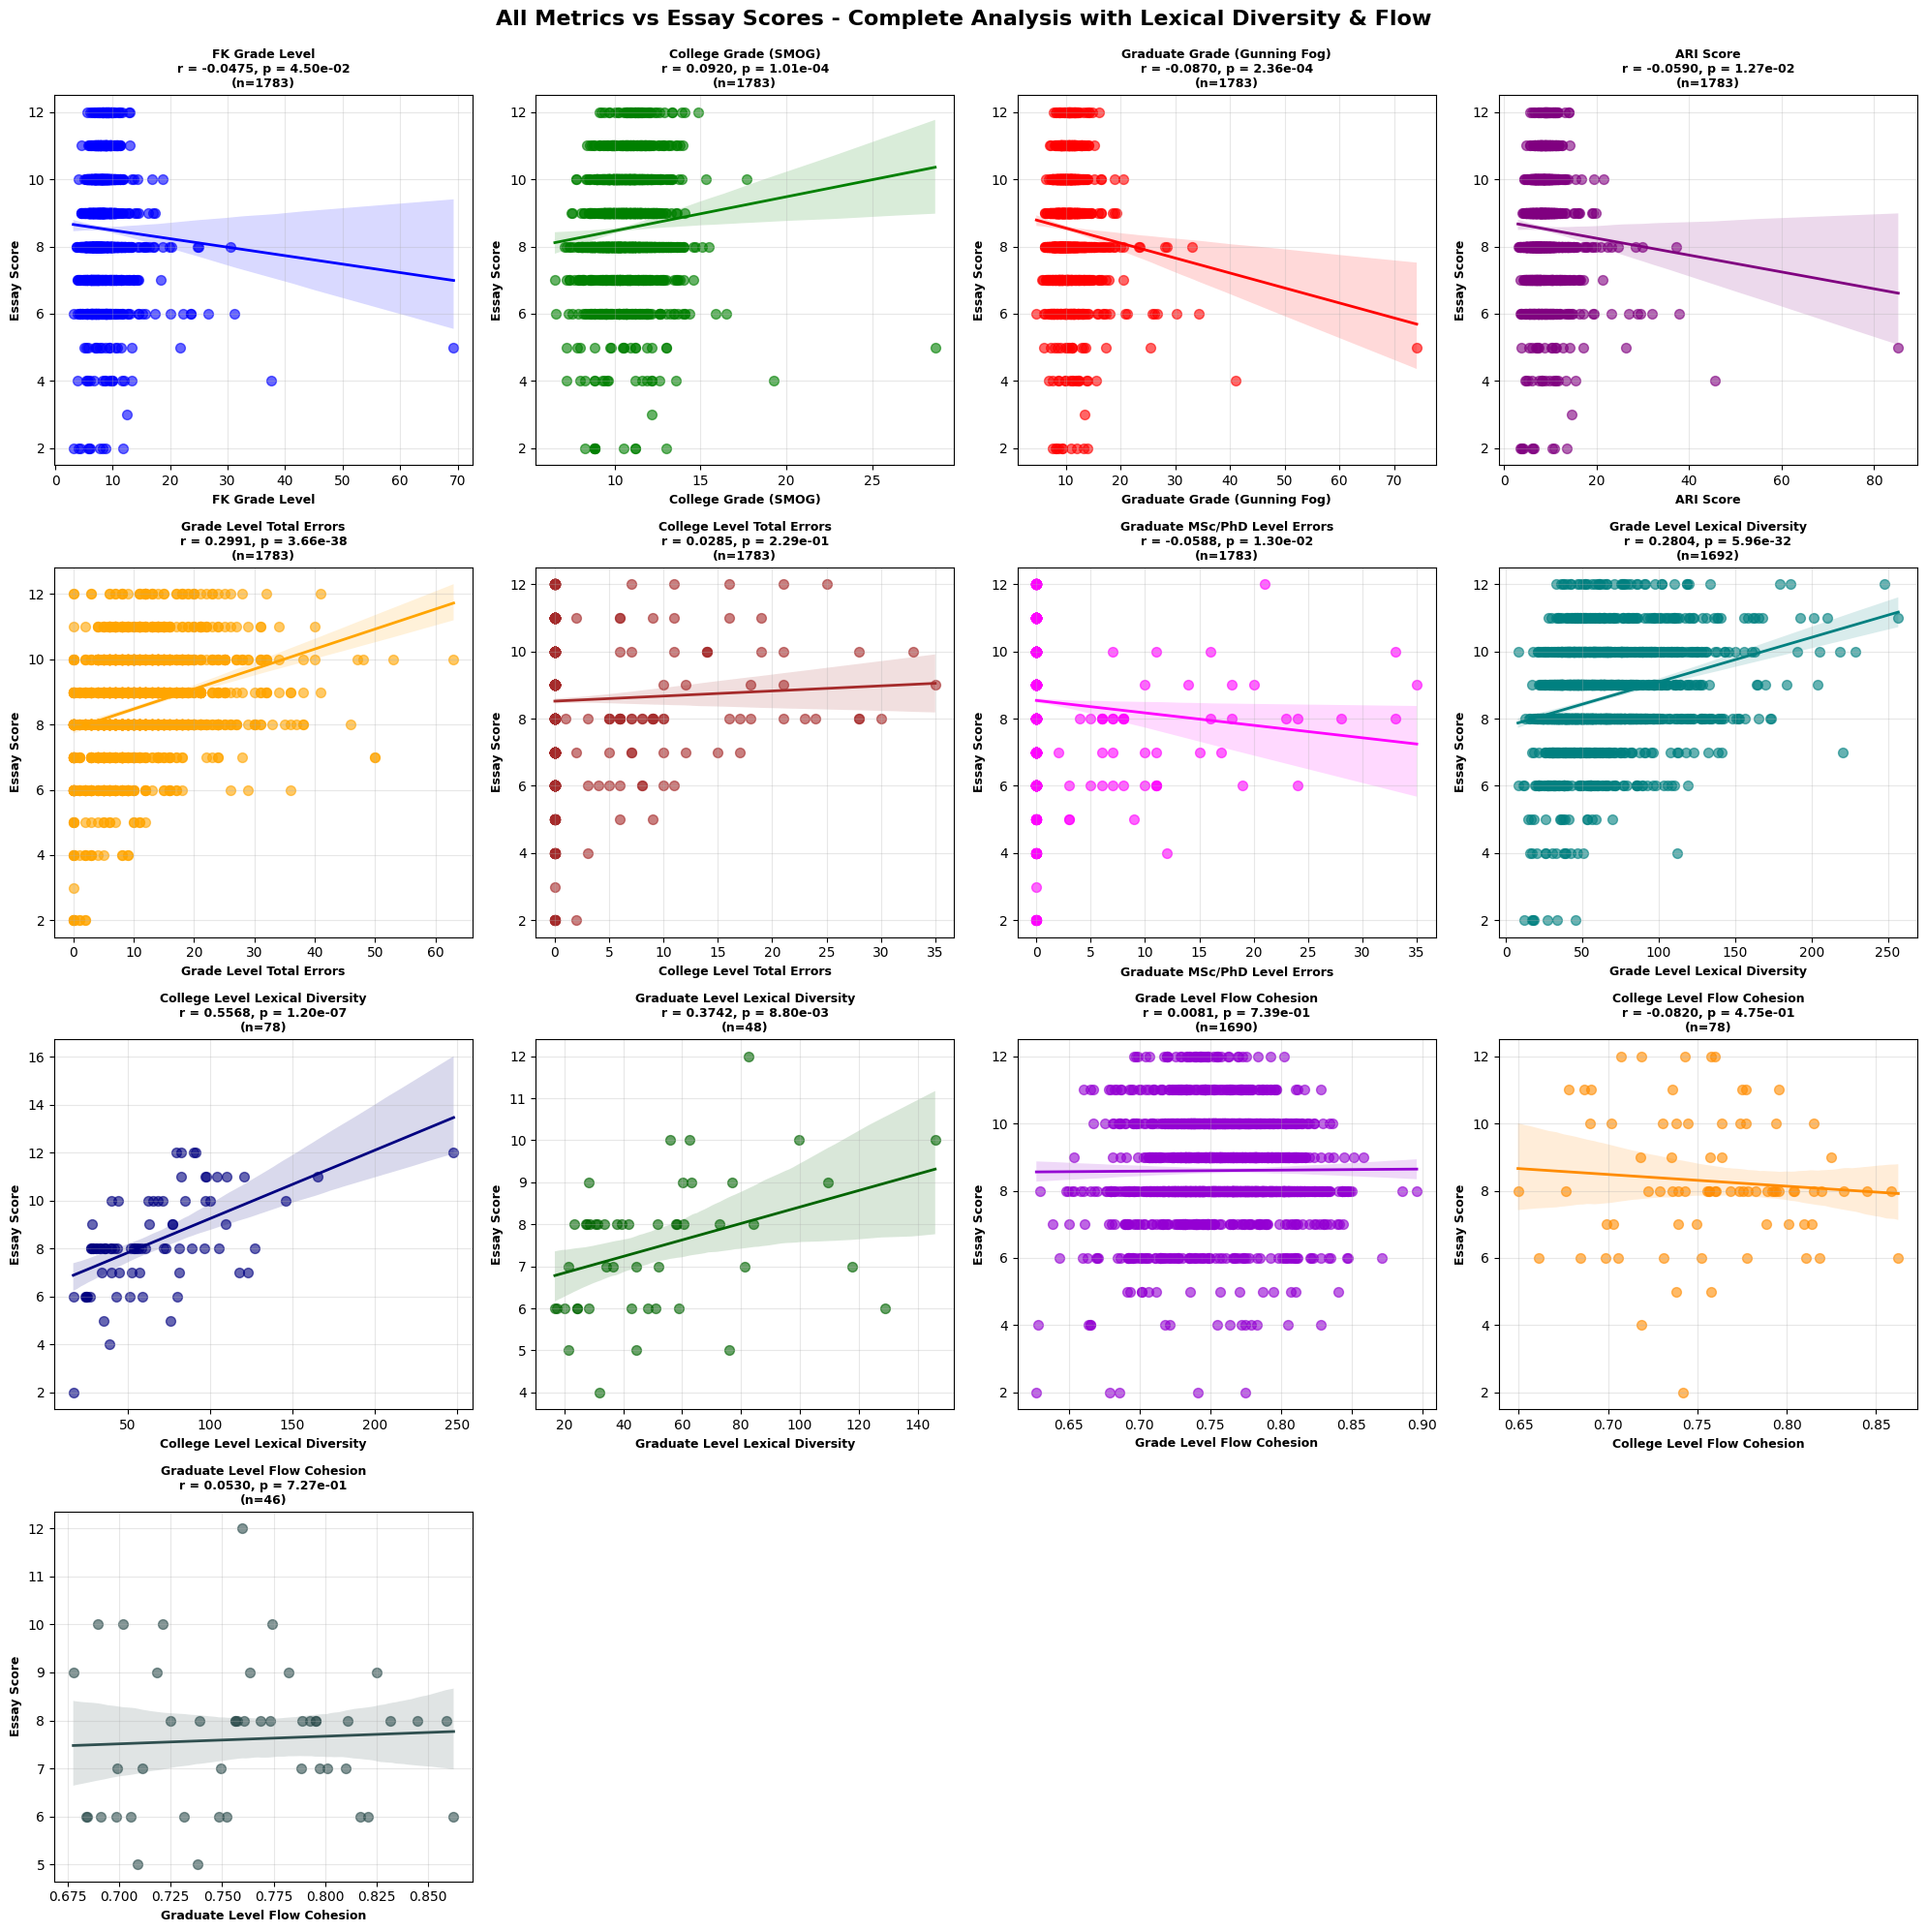

In [230]:
# Enhanced regression plots including lexical diversity AND flow metrics
from scipy.stats import pearsonr

fig, axes = plt.subplots(4, 4, figsize=(20, 20))

all_metrics_with_flow = [
    ('fk_grade', 'FK Grade Level', 'blue'),
    ('college_grade', 'College Grade (SMOG)', 'green'),
    ('graduate_grade', 'Graduate Grade (Gunning Fog)', 'red'),
    ('ari_score', 'ARI Score', 'purple'),
    ('grade_total_error', 'Grade Level Total Errors', 'orange'),
    ('college_total_error', 'College Level Total Errors', 'brown'),
    ('graduate_msc_phd_error', 'Graduate MSc/PhD Level Errors', 'magenta'),
    ('lexical_diversity_grade', 'Grade Level Lexical Diversity', 'teal'),
    ('lexical_diversity_college', 'College Level Lexical Diversity', 'navy'),
    ('lexical_diversity_graduate', 'Graduate Level Lexical Diversity', 'darkgreen'),
    ('grade_flow_cohesion', 'Grade Level Flow Cohesion', 'darkviolet'),
    ('college_flow_cohesion', 'College Level Flow Cohesion', 'darkorange'),
    ('graduate_flow_cohesion', 'Graduate Level Flow Cohesion', 'darkslategray')
]

for idx, (col, title, color) in enumerate(all_metrics_with_flow):
    row = idx // 4
    col_idx = idx % 4
    ax = axes[row, col_idx]
    
    # Drop NaN values for this specific metric
    valid_data = df_read_1[[col, 'domain1_score']].dropna()
    
    if len(valid_data) > 10:
        # Calculate correlation
        corr, pval = pearsonr(valid_data[col], valid_data['domain1_score'])
        
        # Create regression plot
        sns.regplot(x=col, y='domain1_score', data=valid_data, ax=ax,
                    scatter_kws={'alpha': 0.6, 's': 50, 'color': color},
                    line_kws={'color': color, 'linewidth': 2})
        
        ax.set_xlabel(title, fontsize=9, fontweight='bold')
        ax.set_ylabel('Essay Score', fontsize=9, fontweight='bold')
        ax.set_title(f'{title}\nr = {corr:.4f}, p = {pval:.2e}\n(n={len(valid_data)})',
                     fontsize=9, fontweight='bold')
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, f'Insufficient data\n(n={len(valid_data)})', 
                ha='center', va='center', transform=ax.transAxes, fontsize=10)
        ax.set_xlabel(title, fontsize=9, fontweight='bold')
        ax.set_ylabel('Essay Score', fontsize=9, fontweight='bold')
        ax.set_title(title, fontsize=9, fontweight='bold')

# Hide unused subplots
for idx in range(len(all_metrics_with_flow), 16):
    row = idx // 4
    col_idx = idx % 4
    axes[row, col_idx].axis('off')

plt.suptitle('All Metrics vs Essay Scores - Complete Analysis with Lexical Diversity & Flow', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('all_metrics_complete_regression.png', dpi=300, bbox_inches='tight')
plt.show()


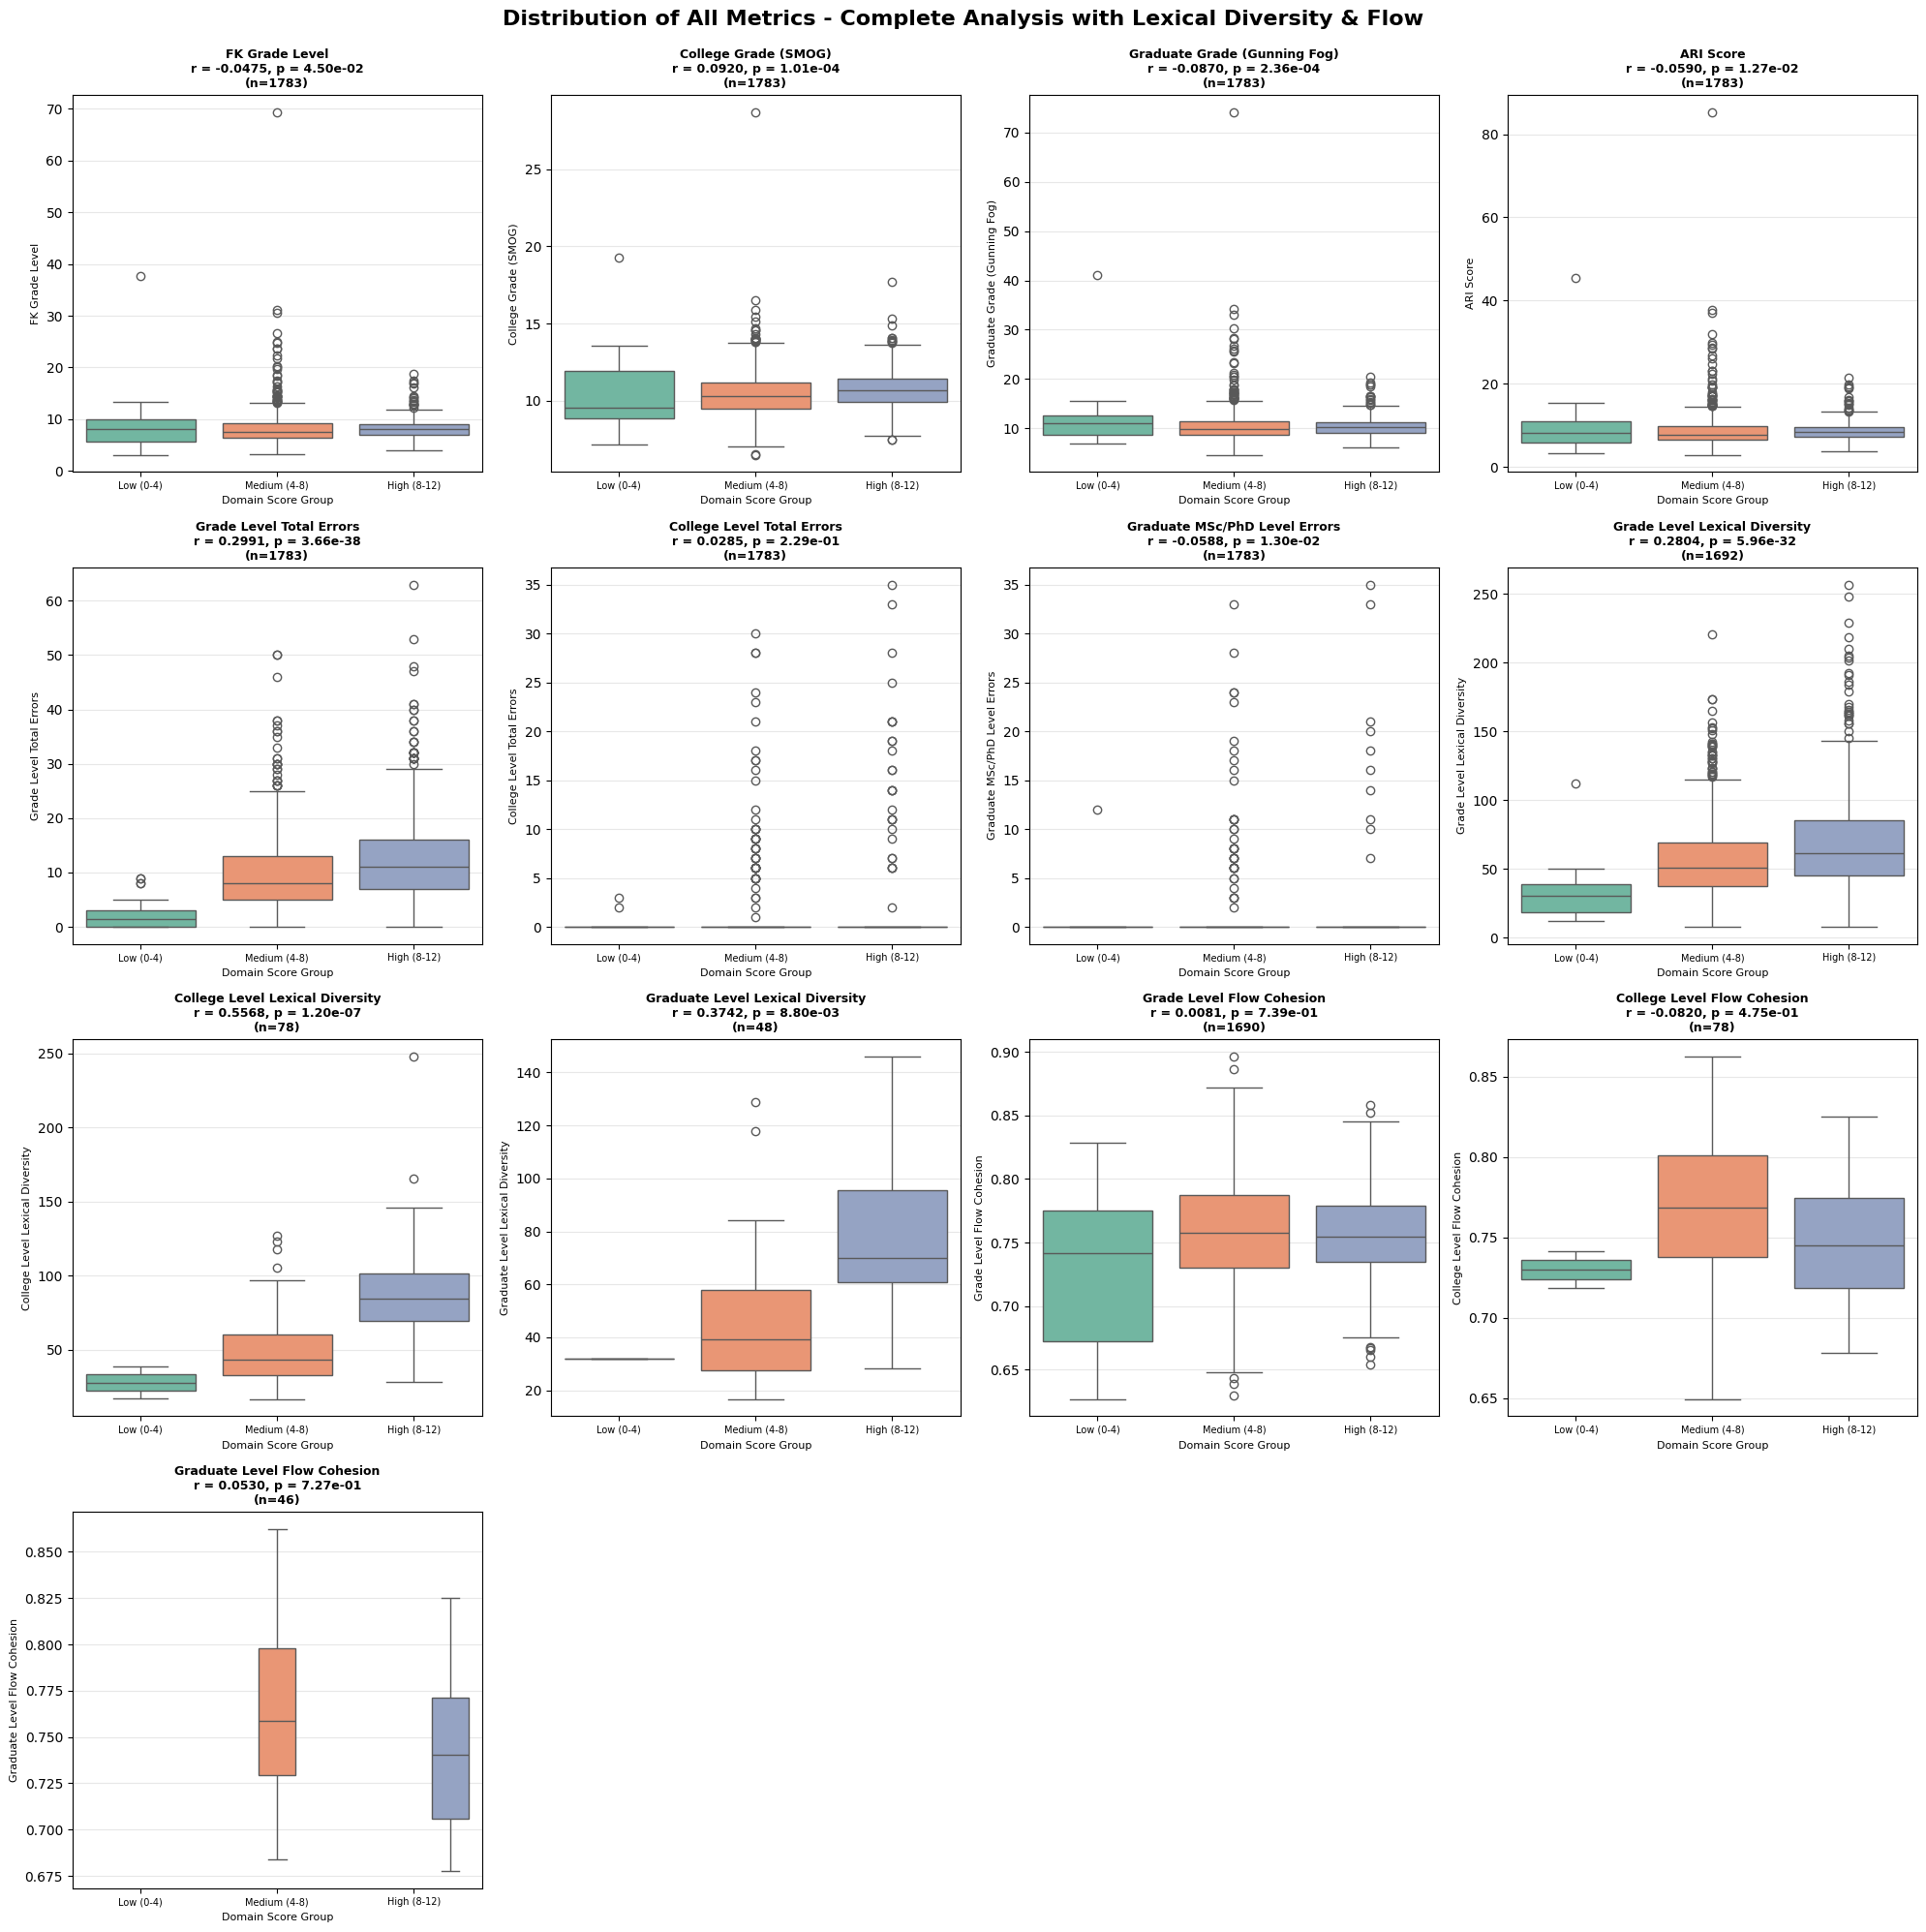

In [232]:
# Enhanced box plots including lexical diversity AND flow metrics
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

all_metrics_with_flow = [
    ('fk_grade', 'FK Grade Level'),
    ('college_grade', 'College Grade (SMOG)'),
    ('graduate_grade', 'Graduate Grade (Gunning Fog)'),
    ('ari_score', 'ARI Score'),
    ('grade_total_error', 'Grade Level Total Errors'),
    ('college_total_error', 'College Level Total Errors'),
    ('graduate_msc_phd_error', 'Graduate MSc/PhD Level Errors'),
    ('lexical_diversity_grade', 'Grade Level Lexical Diversity'),
    ('lexical_diversity_college', 'College Level Lexical Diversity'),
    ('lexical_diversity_graduate', 'Graduate Level Lexical Diversity'),
    ('grade_flow_cohesion', 'Grade Level Flow Cohesion'),
    ('college_flow_cohesion', 'College Level Flow Cohesion'),
    ('graduate_flow_cohesion', 'Graduate Level Flow Cohesion')
]

for idx, (col, title) in enumerate(all_metrics_with_flow):
    row = idx // 4
    col_idx = idx % 4
    ax = axes[row, col_idx]
    
    # Drop NaN values for this specific metric
    valid_data = df_read_1[[col, 'domain1_score', 'score_group']].dropna()
    
    if len(valid_data) > 10:
        # Calculate correlation for title
        corr, pval = pearsonr(valid_data[col], valid_data['domain1_score'])
        
        # Create box plot
        sns.boxplot(x='score_group', y=col, data=valid_data, ax=ax, 
                    hue='score_group', palette='Set2', legend=False)
        
        ax.set_title(f'{title}\nr = {corr:.4f}, p = {pval:.2e}\n(n={len(valid_data)})', 
                     fontsize=9, fontweight='bold')
        ax.set_xlabel('Domain Score Group', fontsize=8)
        ax.set_ylabel(title, fontsize=8)
        ax.grid(True, alpha=0.3, axis='y')
        ax.tick_params(axis='x', labelsize=7)
    else:
        ax.text(0.5, 0.5, f'Insufficient data\n(n={len(valid_data)})', 
                ha='center', va='center', transform=ax.transAxes, fontsize=10)
        ax.set_xlabel('Domain Score Group', fontsize=8)
        ax.set_ylabel(title, fontsize=8)
        ax.set_title(title, fontsize=9, fontweight='bold')

# Hide unused subplots
for idx in range(len(all_metrics_with_flow), 16):
    row = idx // 4
    col_idx = idx % 4
    axes[row, col_idx].axis('off')

plt.suptitle('Distribution of All Metrics - Complete Analysis with Lexical Diversity & Flow', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('all_metrics_complete_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

In [235]:
# Calculate correlations and p-values for lexical diversity metrics
from scipy.stats import pearsonr

print("\n3. LEXICAL DIVERSITY METRICS:")
print("-" * 80)

lexical_metrics = {
    'Grade Level Lexical Diversity (MTLD)': 'lexical_diversity_grade',
    'College Level Lexical Diversity (MTLD)': 'lexical_diversity_college',
    'Graduate Level Lexical Diversity (MTLD)': 'lexical_diversity_graduate'
}

lexical_correlations = {}
for name, col in lexical_metrics.items():
    # Drop NaN values for correlation calculation
    valid_data = df_read_1[[col, 'domain1_score']].dropna()
    
    if len(valid_data) > 10:  # Need sufficient data points
        corr, pval = pearsonr(valid_data[col], valid_data['domain1_score'])
        lexical_correlations[col] = (corr, pval)
        
        # Determine relationship
        if abs(corr) < 0.1:
            relationship = "No Association"
        elif corr > 0:
            relationship = "Positive (Higher diversity → Higher scores)"
        else:
            relationship = "Negative (Unexpected)"
        
        print(f"{name:45s}: r = {corr:7.4f}, p-value = {pval:.4e} [{relationship}]")
        print(f"  Valid samples: {len(valid_data)} essays")
    else:
        print(f"{name:45s}: Insufficient data (n={len(valid_data)})")

# Update all_correlations dictionary
all_correlations.update(lexical_correlations)

print("\n" + "=" * 80)
print("Note: Higher MTLD scores indicate greater lexical diversity (richer vocabulary)")


3. LEXICAL DIVERSITY METRICS:
--------------------------------------------------------------------------------
Grade Level Lexical Diversity (MTLD)         : r =  0.2804, p-value = 5.9639e-32 [Positive (Higher diversity → Higher scores)]
  Valid samples: 1692 essays
College Level Lexical Diversity (MTLD)       : r =  0.5568, p-value = 1.1990e-07 [Positive (Higher diversity → Higher scores)]
  Valid samples: 78 essays
Graduate Level Lexical Diversity (MTLD)      : r =  0.3742, p-value = 8.7967e-03 [Positive (Higher diversity → Higher scores)]
  Valid samples: 48 essays

Note: Higher MTLD scores indicate greater lexical diversity (richer vocabulary)


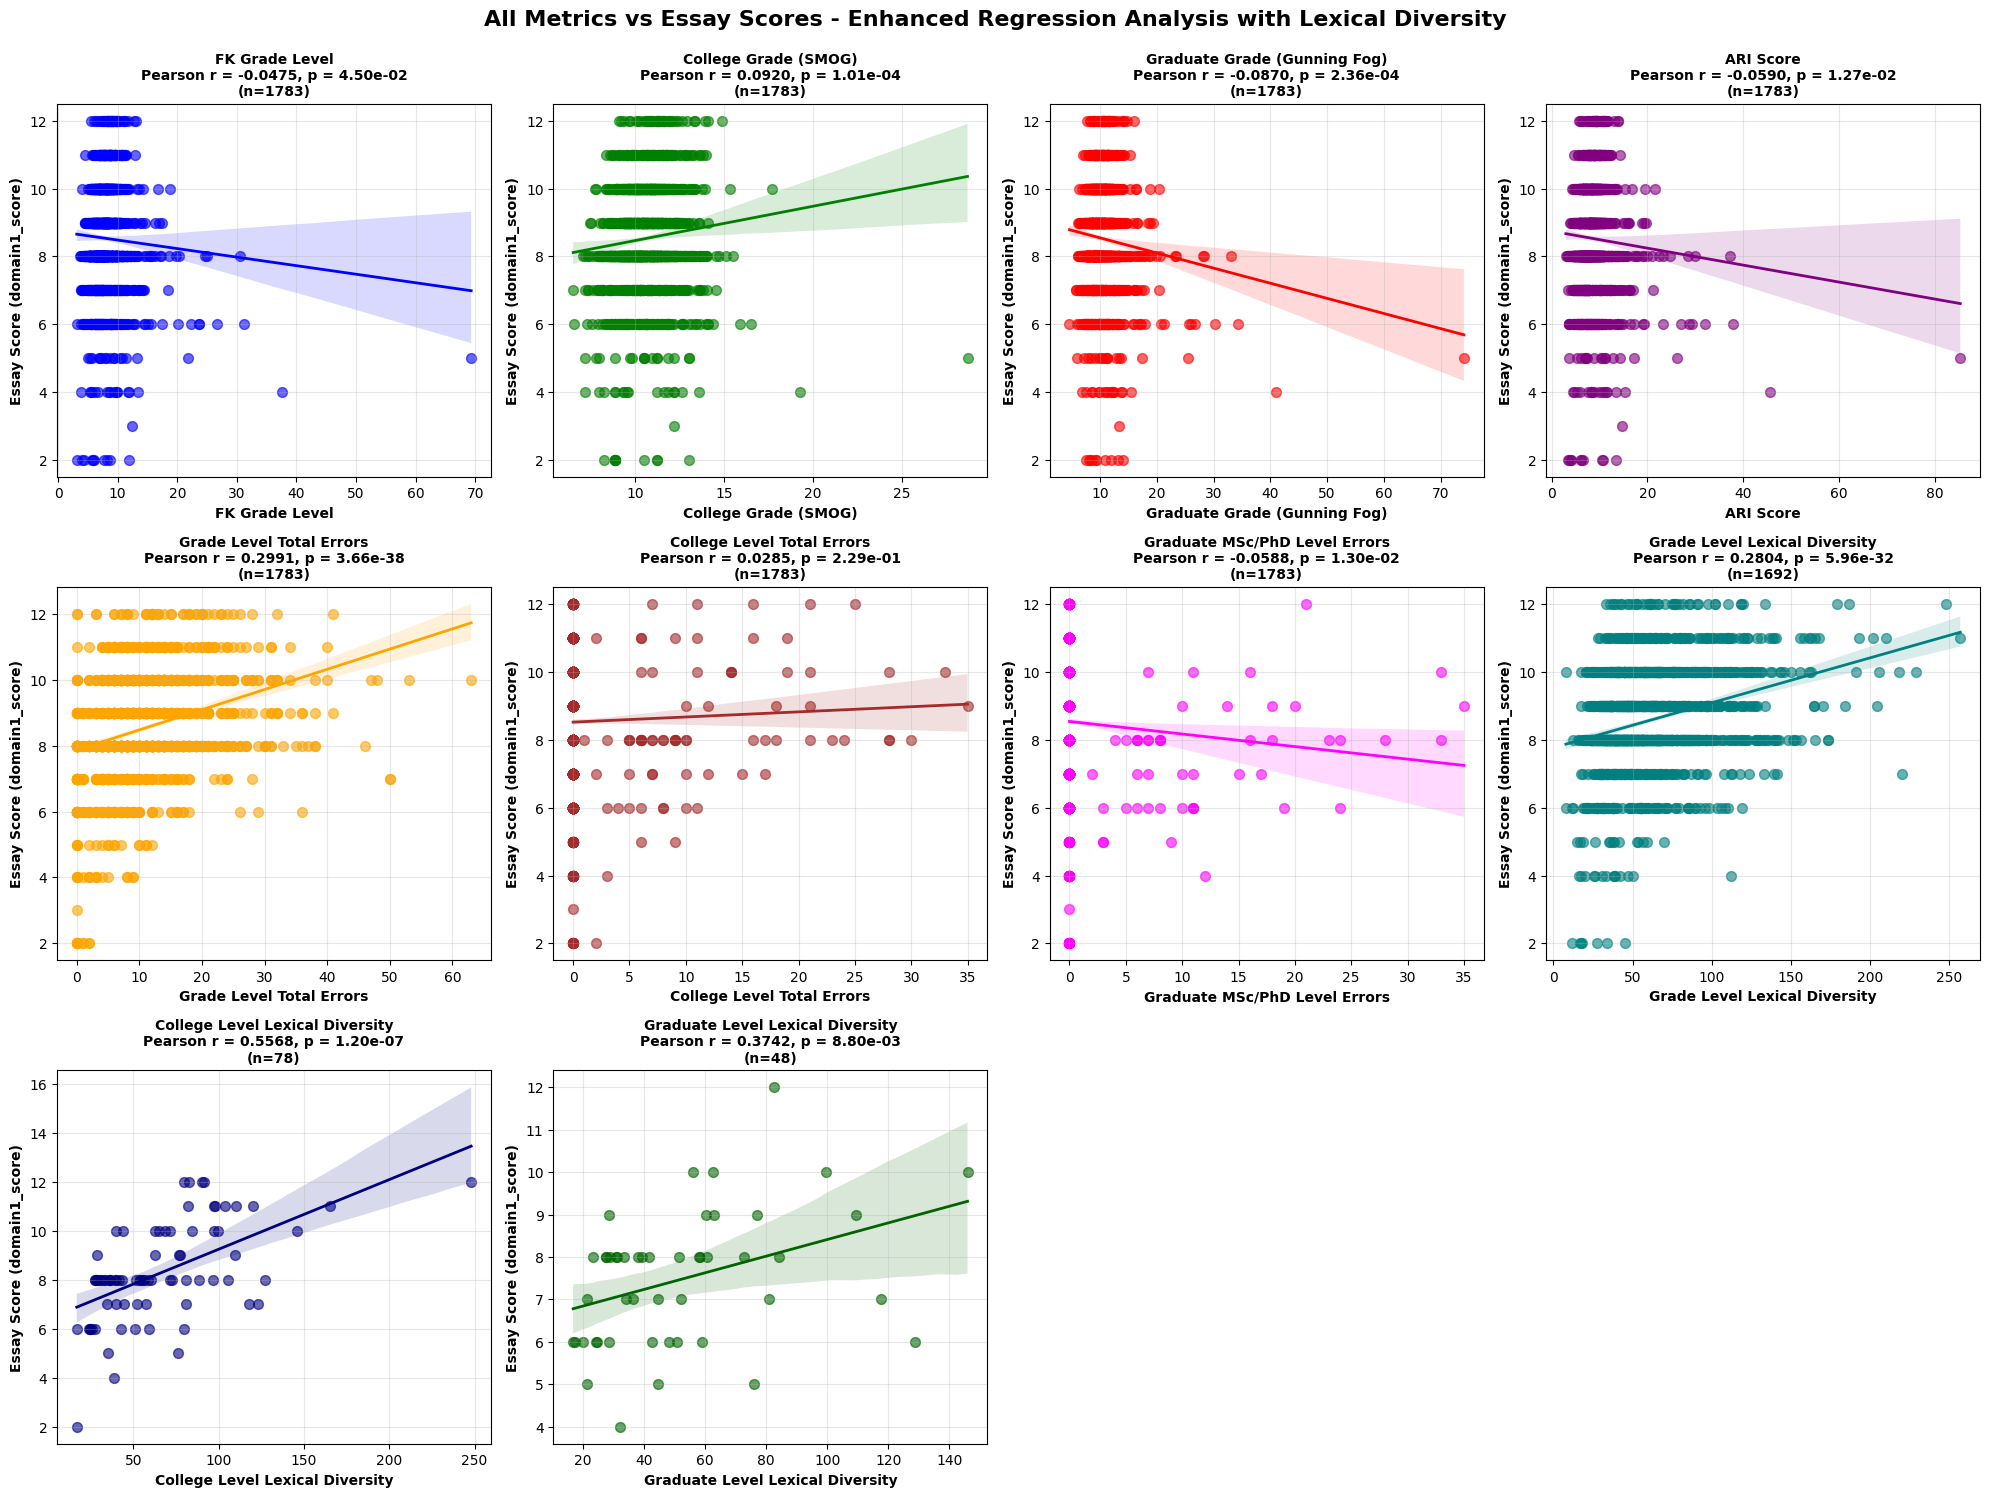

In [237]:
# Enhanced regression plots including lexical diversity metrics
from scipy.stats import pearsonr

fig, axes = plt.subplots(3, 4, figsize=(20, 15))

all_metrics = [
    ('fk_grade', 'FK Grade Level', 'blue'),
    ('college_grade', 'College Grade (SMOG)', 'green'),
    ('graduate_grade', 'Graduate Grade (Gunning Fog)', 'red'),
    ('ari_score', 'ARI Score', 'purple'),
    ('grade_total_error', 'Grade Level Total Errors', 'orange'),
    ('college_total_error', 'College Level Total Errors', 'brown'),
    ('graduate_msc_phd_error', 'Graduate MSc/PhD Level Errors', 'magenta'),
    ('lexical_diversity_grade', 'Grade Level Lexical Diversity', 'teal'),
    ('lexical_diversity_college', 'College Level Lexical Diversity', 'navy'),
    ('lexical_diversity_graduate', 'Graduate Level Lexical Diversity', 'darkgreen')
]

for idx, (col, title, color) in enumerate(all_metrics):
    row = idx // 4
    col_idx = idx % 4
    ax = axes[row, col_idx]
    
    # Drop NaN values for this specific metric
    valid_data = df_read_1[[col, 'domain1_score']].dropna()
    
    if len(valid_data) > 10:
        # Calculate correlation
        corr, pval = pearsonr(valid_data[col], valid_data['domain1_score'])
        
        # Create regression plot
        sns.regplot(x=col, y='domain1_score', data=valid_data, ax=ax,
                    scatter_kws={'alpha': 0.6, 's': 50, 'color': color},
                    line_kws={'color': color, 'linewidth': 2})
        
        ax.set_xlabel(title, fontsize=10, fontweight='bold')
        ax.set_ylabel('Essay Score (domain1_score)', fontsize=10, fontweight='bold')
        ax.set_title(f'{title}\nPearson r = {corr:.4f}, p = {pval:.2e}\n(n={len(valid_data)})',
                     fontsize=10, fontweight='bold')
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, f'Insufficient data\n(n={len(valid_data)})', 
                ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_xlabel(title, fontsize=10, fontweight='bold')
        ax.set_ylabel('Essay Score', fontsize=10, fontweight='bold')
        ax.set_title(title, fontsize=10, fontweight='bold')

# Hide unused subplots
for idx in range(len(all_metrics), 12):
    row = idx // 4
    col_idx = idx % 4
    axes[row, col_idx].axis('off')

plt.suptitle('All Metrics vs Essay Scores - Enhanced Regression Analysis with Lexical Diversity', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('all_metrics_with_lexical_regression.png', dpi=300, bbox_inches='tight')
plt.show()


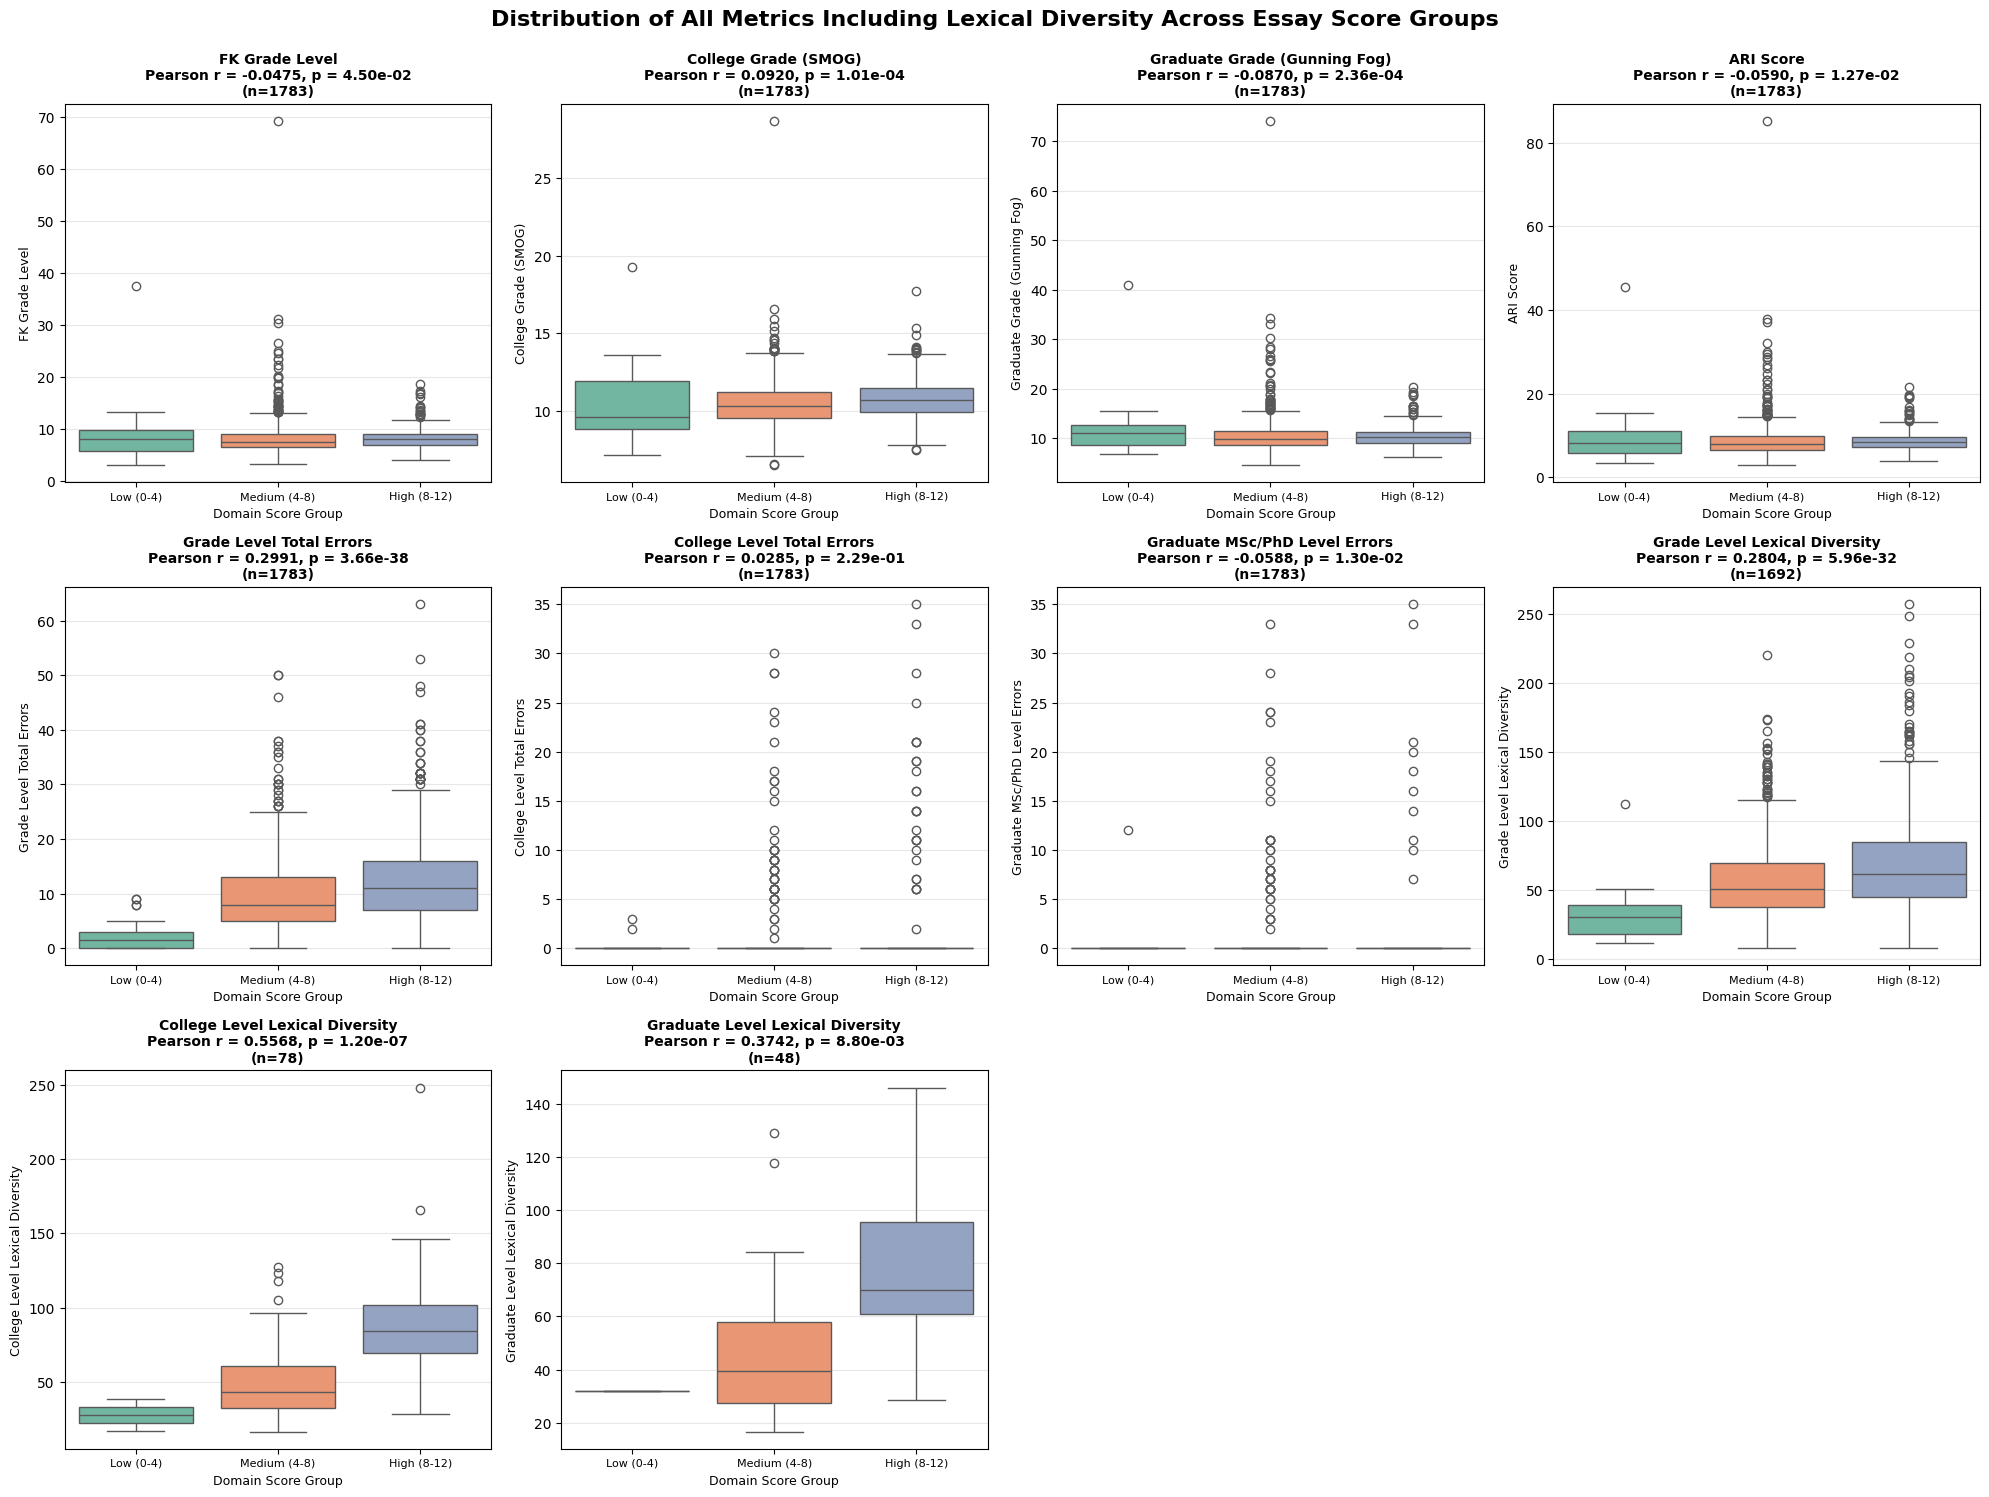

In [238]:
# Enhanced box plots including lexical diversity metrics
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

all_metrics = [
    ('fk_grade', 'FK Grade Level'),
    ('college_grade', 'College Grade (SMOG)'),
    ('graduate_grade', 'Graduate Grade (Gunning Fog)'),
    ('ari_score', 'ARI Score'),
    ('grade_total_error', 'Grade Level Total Errors'),
    ('college_total_error', 'College Level Total Errors'),
    ('graduate_msc_phd_error', 'Graduate MSc/PhD Level Errors'),
    ('lexical_diversity_grade', 'Grade Level Lexical Diversity'),
    ('lexical_diversity_college', 'College Level Lexical Diversity'),
    ('lexical_diversity_graduate', 'Graduate Level Lexical Diversity')
]

for idx, (col, title) in enumerate(all_metrics):
    row = idx // 4
    col_idx = idx % 4
    ax = axes[row, col_idx]
    
    # Drop NaN values for this specific metric
    valid_data = df_read_1[[col, 'domain1_score', 'score_group']].dropna()
    
    if len(valid_data) > 10:
        # Calculate correlation for title
        corr, pval = pearsonr(valid_data[col], valid_data['domain1_score'])
        
        # Create box plot
        sns.boxplot(x='score_group', y=col, data=valid_data, ax=ax, 
                    hue='score_group', palette='Set2', legend=False)
        
        ax.set_title(f'{title}\nPearson r = {corr:.4f}, p = {pval:.2e}\n(n={len(valid_data)})', 
                     fontsize=10, fontweight='bold')
        ax.set_xlabel('Domain Score Group', fontsize=9)
        ax.set_ylabel(title, fontsize=9)
        ax.grid(True, alpha=0.3, axis='y')
        ax.tick_params(axis='x', labelsize=8)
    else:
        ax.text(0.5, 0.5, f'Insufficient data\n(n={len(valid_data)})', 
                ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_xlabel('Domain Score Group', fontsize=9)
        ax.set_ylabel(title, fontsize=9)
        ax.set_title(title, fontsize=10, fontweight='bold')

# Hide unused subplots
for idx in range(len(all_metrics), 12):
    row = idx // 4
    col_idx = idx % 4
    axes[row, col_idx].axis('off')

plt.suptitle('Distribution of All Metrics Including Lexical Diversity Across Essay Score Groups', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('all_metrics_with_lexical_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

In [358]:
# Filter df_grade_k12 to only include rows where grade metrics are NOT NaN
df_grade_k12 = df_read_1[['essay_id', 'essay_set', 'domain1_score', 'fk_grade', 'ari_score', 'grade_total_error', 'lexical_diversity_grade', 'grade_flow_cohesion', 'word_count', 'sentence_count', 'cleaned_for_lexical',  'cleaned_essay']]
df_grade_k12 = df_grade_k12[df_grade_k12['lexical_diversity_grade'].notna() & df_grade_k12['grade_flow_cohesion'].notna()]

# Filter df_grade_college to only include rows where college metrics are NOT NaN
df_grade_college = df_read_1[['essay_id', 'essay_set', 'domain1_score', 'college_grade', 'ari_score', 'college_total_error', 'lexical_diversity_college', 'college_flow_cohesion', 'word_count', 'sentence_count', 'cleaned_for_lexical', 'cleaned_essay']]
df_grade_college = df_grade_college[df_grade_college['lexical_diversity_college'].notna() & df_grade_college['college_flow_cohesion'].notna()]

# Filter df_grade_grad to only include rows where graduate metrics are NOT NaN
df_grade_grad = df_read_1[['essay_id', 'essay_set', 'domain1_score', 'graduate_grade', 'ari_score', 'graduate_msc_phd_error', 'lexical_diversity_graduate', 'graduate_flow_cohesion', 'word_count', 'sentence_count', 'cleaned_for_lexical', 'cleaned_essay']]
df_grade_grad = df_grade_grad[df_grade_grad['lexical_diversity_graduate'].notna() & df_grade_grad['graduate_flow_cohesion'].notna()]

In [361]:
df_grade_k12.head(5)

,essay_id,essay_set,domain1_score,fk_grade,ari_score,grade_total_error,lexical_diversity_grade,grade_flow_cohesion,word_count,sentence_count,cleaned_for_lexical,cleaned_essay
0,1,1,8.0,9.103751,11.081943,12,88.346423,0.750979,350,16,dear local newspaper i think effects computers...,"Dear local newspaper, I think effects computer..."
1,2,1,9.0,9.562362,10.077005,14,62.856334,0.782589,423,20,dear mention mention i believe that using comp...,"Dear mention mention, I believe that using com..."
2,3,1,7.0,9.353469,9.822135,4,41.300119,0.752036,283,14,dear mention mention mention more and more peo...,"Dear, mention mention mention More and more pe..."
3,4,1,10.0,10.331942,11.751795,38,31.941489,0.770717,530,27,dear local newspaper mention i have found that...,"Dear Local Newspaper, mention I have found tha..."
4,5,1,8.0,7.710914,7.611226,11,42.280352,0.798870,473,30,dear mention i know having computers has a pos...,"Dear mention, I know having computers has a po..."


In [360]:
df_grade_college.head(5)

,essay_id,essay_set,domain1_score,college_grade,ari_score,college_total_error,lexical_diversity_college,college_flow_cohesion,word_count,sentence_count,cleaned_for_lexical,cleaned_essay
55,56,1,10.0,15.308716,13.421820,7,145.985795,0.689628,471,22,over the past decade the percentage of people ...,"Over the past decade, the percentage of people..."
71,72,1,10.0,13.724666,13.115806,14,68.237668,0.793734,531,25,hello i decided to write in to the paper on th...,"Hello, I decided to write in to the paper on t..."
92,93,1,11.0,13.954579,14.193469,9,97.749861,0.690470,547,23,readers of mention mention should be well info...,"Readers of ""mention mention"" should be well in..."
131,132,1,11.0,13.295007,11.683437,19,82.098936,0.774840,432,25,dear mention i understand that the idea of adv...,"Dear mention, I understand that the idea of ad..."
144,145,1,10.0,13.227904,11.098071,19,97.202514,0.738193,365,24,dear local newspaper mention are you adminitra...,Dear Local Newspaper mention are you adminitra...


In [380]:
df_grade_grad.head(5)

,essay_id,essay_set,domain1_score,graduate_grade,ari_score,graduate_msc_phd_error,lexical_diversity_graduate,graduate_flow_cohesion,word_count,sentence_count,cleaned_for_lexical,cleaned_essay,final_score
50,51,1,9.0,18.479914,18.917861,14,62.996297,0.782433,577,13,dear local newspaper have you ever wondered ho...,"Dear Local Newspaper, Have you ever wondered h...",43.402744
55,56,1,10.0,16.373755,13.421820,7,145.985795,0.689628,471,22,over the past decade the percentage of people ...,"Over the past decade, the percentage of people...",47.063526
63,64,1,7.0,17.231644,16.426651,6,21.371841,0.797169,222,6,dear news paper i think computers good for you...,Dear news paper I think computers good for you...,35.420737
145,146,1,6.0,25.747748,29.389009,19,28.438751,0.748300,185,3,dear local newspaper i think that usieng compu...,Dear local newspaper I think that usieng compu...,32.012974
150,151,1,8.0,16.122449,15.717429,8,84.065013,0.724678,247,7,dear local newspaper i don t agree with the pe...,Dear local newspaper I don’t agree with the pe...,40.465381


In [362]:
# Import required libraries for Lasso Regression


print("=" * 80)
print("LASSO REGRESSION MODEL FOR GRADE 4-12 ESSAYS")
print("=" * 80)

# Prepare the data
# Features: fk_grade, ari_score, grade_total_error, lexical_diversity_grade, grade_flow_cohesion
# Target: domain1_score (normalized to 0-100 scale)

# Remove any rows with NaN values in the features or target
df_k12_clean = df_grade_k12[['fk_grade', 'ari_score', 'grade_total_error', 
                               'lexical_diversity_grade', 'grade_flow_cohesion', 
                               'domain1_score']].dropna()

print(f" Dataset Info:")
print(f"Total samples: {len(df_k12_clean)}")
print(f"Original score range: {df_k12_clean['domain1_score'].min()} - {df_k12_clean['domain1_score'].max()}")

# Normalize domain1_score to 0-100 scale
score_min = df_k12_clean['domain1_score'].min()
score_max = df_k12_clean['domain1_score'].max()
df_k12_clean['domain1_score_normalized'] = ((df_k12_clean['domain1_score'] - score_min) / (score_max - score_min)) * 100

# Define features and target
X = df_k12_clean[['fk_grade', 'ari_score', 'grade_total_error', 
                   'lexical_diversity_grade', 'grade_flow_cohesion']]
y = df_k12_clean['domain1_score_normalized']

print(f" Features:")
for i, col in enumerate(X.columns, 1):
    print(f"  {i}. {col}")
print(f" Target: domain1_score (scaled 0-100)")

# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f" Train/Test Split:")
print(f"  Training samples: {len(X_train)}")
print(f"  Testing samples: {len(X_test)}")

# Standardize features (important for Lasso)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

LASSO REGRESSION MODEL FOR GRADE 4-12 ESSAYS

📊 Dataset Info:
Total samples: 1690
Original score range: 2.0 - 12.0
 Features:
  1. fk_grade
  2. ari_score
  3. grade_total_error
  4. lexical_diversity_grade
  5. grade_flow_cohesion
 Target: domain1_score (scaled 0-100)
 Train/Test Split:
  Training samples: 1352
  Testing samples: 338


In [363]:
# Train Lasso Regression model
print("=" * 80)
print("TRAINING LASSO REGRESSION MODEL")
print("=" * 80)

# Initialize Lasso with alpha (regularization strength)
# We'll use cross-validation to find the best alpha
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
best_alpha = None
best_score = -np.inf

print(" Searching for optimal alpha (regularization strength)...")
for alpha in alphas:
    lasso = Lasso(alpha=alpha, random_state=42, max_iter=10000)
    cv_scores = cross_val_score(lasso, X_train_scaled, y_train, cv=5, 
                                  scoring='neg_mean_squared_error')
    mean_score = cv_scores.mean()
    print(f"  Alpha = {alpha:6.3f} | CV MSE: {-mean_score:.4f} | CV R²: {1 + mean_score/y_train.var():.4f}")
    
    if mean_score > best_score:
        best_score = mean_score
        best_alpha = alpha

print(f" Best alpha: {best_alpha}")

# Train final model with best alpha
lasso_model = Lasso(alpha=best_alpha, random_state=42, max_iter=10000)
lasso_model.fit(X_train_scaled, y_train)

print(f" Model Training Complete!")
print(f" Feature Coefficients:")
for feature, coef in zip(X.columns, lasso_model.coef_):
    print(f"  {feature:30s}: {coef:8.4f}")
print(f"  {'Intercept':30s}: {lasso_model.intercept_:8.4f}")

# Evaluate on test set
y_pred_test = lasso_model.predict(X_test_scaled)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f" Test Set Performance:")
print(f"  R² Score: {r2_test:.4f}")
print(f"  RMSE: {rmse_test:.4f}")
print(f"  MAE: {mae_test:.4f}")
print(f"  MSE: {mse_test:.4f}")

TRAINING LASSO REGRESSION MODEL

🔍 Searching for optimal alpha (regularization strength)...
  Alpha =  0.001 | CV MSE: 178.3412 | CV R²: 0.1800
  Alpha =  0.010 | CV MSE: 178.3470 | CV R²: 0.1799
  Alpha =  0.100 | CV MSE: 178.2771 | CV R²: 0.1803
  Alpha =  1.000 | CV MSE: 184.5516 | CV R²: 0.1514
  Alpha = 10.000 | CV MSE: 217.8032 | CV R²: -0.0015
  Alpha = 100.000 | CV MSE: 217.8032 | CV R²: -0.0015
 Best alpha: 0.1

📈 Model Training Complete!

🔢 Feature Coefficients:
  fk_grade                      :   1.1243
  ari_score                     :  -0.0000
  grade_total_error             :   3.3551
  lexical_diversity_grade       :   5.8624
  grade_flow_cohesion           :   4.0748
  Intercept                     :  65.7618

📊 Test Set Performance:
  R² Score: 0.1823
  RMSE: 13.3370
  MAE: 10.5420
  MSE: 177.8743


In [364]:
# Predict final scores for ALL rows in df_grade_k12 and add as new column
print("=" * 80)
print("PREDICTING FINAL SCORES FOR ALL GRADE 4-12 ESSAYS")
print("=" * 80)

# Prepare features for all rows (handle NaN values)
X_all = df_grade_k12[['fk_grade', 'ari_score', 'grade_total_error', 
                       'lexical_diversity_grade', 'grade_flow_cohesion']].copy()

# Scale the features using the same scaler
X_all_scaled = scaler.transform(X_all)

# Predict scores (0-100 scale)
predicted_scores = lasso_model.predict(X_all_scaled)

# Ensure predictions are within 0-100 range
predicted_scores = np.clip(predicted_scores, 0, 100)

# Add predicted scores as new column to df_grade_k12
df_grade_k12['final_score'] = predicted_scores

print(f"\n✅ Predictions completed!")
print(f"\n📊 Predicted Score Statistics:")
print(f"  Mean: {df_grade_k12['final_score'].mean():.2f}")
print(f"  Median: {df_grade_k12['final_score'].median():.2f}")
print(f"  Std Dev: {df_grade_k12['final_score'].std():.2f}")
print(f"  Min: {df_grade_k12['final_score'].min():.2f}")
print(f"  Max: {df_grade_k12['final_score'].max():.2f}")

print(f" Sample predictions (first 10 rows):")
sample_cols = ['essay_id', 'domain1_score', 'final_score', 'fk_grade', 
               'grade_total_error', 'lexical_diversity_grade', 'grade_flow_cohesion']
print(df_grade_k12[sample_cols].head(10).to_string(index=False))

PREDICTING FINAL SCORES FOR ALL GRADE 4-12 ESSAYS

✅ Predictions completed!

📊 Predicted Score Statistics:
  Mean: 65.83
  Median: 65.37
  Std Dev: 6.11
  Min: 42.32
  Max: 100.00

📋 Sample predictions (first 10 rows):
 essay_id  domain1_score  final_score  fk_grade  grade_total_error  lexical_diversity_grade  grade_flow_cohesion
        1            8.0    71.161356  9.103751                 12                88.346423             0.750979
        2            9.0    71.001582  9.562362                 14                62.856334             0.782589
        3            7.0    59.008722  9.353469                  4                41.300119             0.752036
        4           10.0    75.512073 10.331942                 38                31.941489             0.770717
        5            8.0    66.207773  7.710914                 11                42.280352             0.798870
        6            8.0    59.390573  6.523323                 11                59.900266            

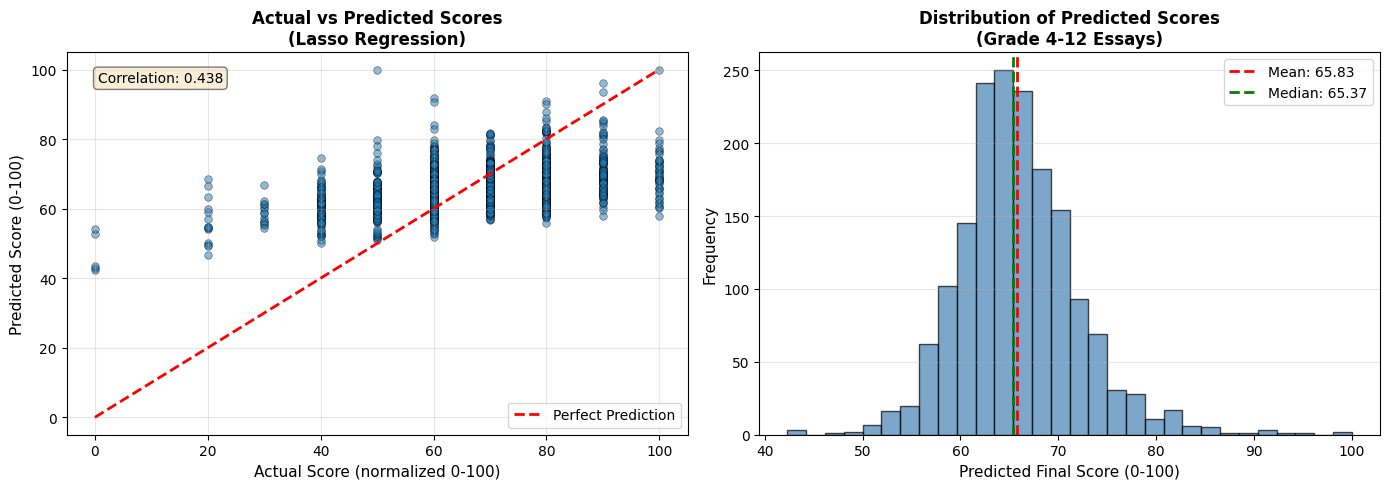

In [365]:
# Visualize actual vs predicted scores
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Scatter plot of actual vs predicted
ax1 = axes[0]
# Use only rows where we have actual domain1_score
comparison_df = df_grade_k12[['domain1_score', 'final_score']].dropna()
# Normalize domain1_score to 0-100 for comparison
score_min = comparison_df['domain1_score'].min()
score_max = comparison_df['domain1_score'].max()
comparison_df['domain1_normalized'] = ((comparison_df['domain1_score'] - score_min) / (score_max - score_min)) * 100

ax1.scatter(comparison_df['domain1_normalized'], comparison_df['final_score'], 
            alpha=0.5, s=30, edgecolor='k', linewidth=0.5)
ax1.plot([0, 100], [0, 100], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Score (normalized 0-100)', fontsize=11)
ax1.set_ylabel('Predicted Score (0-100)', fontsize=11)
ax1.set_title('Actual vs Predicted Scores\n(Lasso Regression)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Calculate correlation
corr = comparison_df['domain1_normalized'].corr(comparison_df['final_score'])
ax1.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax1.transAxes, 
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Distribution of predicted scores
ax2 = axes[1]
ax2.hist(df_grade_k12['final_score'], bins=30, alpha=0.7, color='steelblue', edgecolor='black')
ax2.axvline(df_grade_k12['final_score'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {df_grade_k12['final_score'].mean():.2f}")
ax2.axvline(df_grade_k12['final_score'].median(), color='green', linestyle='--', linewidth=2, label=f"Median: {df_grade_k12['final_score'].median():.2f}")
ax2.set_xlabel('Predicted Final Score (0-100)', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Distribution of Predicted Scores\n(Grade 4-12 Essays)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('lasso_grade_k12_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

In [366]:
df_grade_k12

,essay_id,essay_set,domain1_score,fk_grade,ari_score,grade_total_error,lexical_diversity_grade,grade_flow_cohesion,word_count,sentence_count,cleaned_for_lexical,cleaned_essay,final_score
0,1,1,8.0,9.103751,11.081943,12,88.346423,0.750979,350,16,dear local newspaper i think effects computers...,"Dear local newspaper, I think effects computer...",71.161356
1,2,1,9.0,9.562362,10.077005,14,62.856334,0.782589,423,20,dear mention mention i believe that using comp...,"Dear mention mention, I believe that using com...",71.001582
2,3,1,7.0,9.353469,9.822135,4,41.300119,0.752036,283,14,dear mention mention mention more and more peo...,"Dear, mention mention mention More and more pe...",59.008722
3,4,1,10.0,10.331942,11.751795,38,31.941489,0.770717,530,27,dear local newspaper mention i have found that...,"Dear Local Newspaper, mention I have found tha...",75.512073
4,5,1,8.0,7.710914,7.611226,11,42.280352,0.798870,473,30,dear mention i know having computers has a pos...,"Dear mention, I know having computers has a po...",66.207773
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1777,1782,1,8.0,7.559177,7.970768,11,89.742612,0.725306,333,23,dear mention i believe that computers are a go...,"Dear mention, I believe that computers are a g...",67.146684
1778,1783,1,8.0,8.605565,9.776340,24,71.623694,0.775172,507,22,dear mention mention several reasons on way i ...,"Dear mention, mention several reasons on way I...",75.754196
1779,1784,1,7.0,4.210416,4.761563,9,74.494624,0.726186,214,19,do a adults and kids spend to much time on the...,Do a adults and kids spend to much time on the...,61.111523
1780,1785,1,8.0,7.954611,9.011710,7,20.119048,0.847472,296,18,my opinion is that people should have computer...,My opinion is that people should have computer...,65.572167


In [367]:
# Lasso Regression for College-Level Essays
print("=" * 80)
print("LASSO REGRESSION MODEL FOR COLLEGE-LEVEL ESSAYS")
print("=" * 80)

# Prepare the data
df_college_clean = df_grade_college[['college_grade', 'ari_score', 'college_total_error', 
                                      'lexical_diversity_college', 'college_flow_cohesion', 
                                      'domain1_score']].dropna()

print(f"\n📊 Dataset Info:")
print(f"Total samples: {len(df_college_clean)}")
print(f"Original score range: {df_college_clean['domain1_score'].min()} - {df_college_clean['domain1_score'].max()}")

# Normalize domain1_score to 0-100 scale
score_min = df_college_clean['domain1_score'].min()
score_max = df_college_clean['domain1_score'].max()
df_college_clean['domain1_score_normalized'] = ((df_college_clean['domain1_score'] - score_min) / (score_max - score_min)) * 100

# Define features and target
X_college = df_college_clean[['college_grade', 'ari_score', 'college_total_error', 
                               'lexical_diversity_college', 'college_flow_cohesion']]
y_college = df_college_clean['domain1_score_normalized']

print(f"\n📋 Features:")
for i, col in enumerate(X_college.columns, 1):
    print(f"  {i}. {col}")

# Split and scale
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_college, y_college, test_size=0.2, random_state=42)
scaler_college = StandardScaler()
X_train_c_scaled = scaler_college.fit_transform(X_train_c)
X_test_c_scaled = scaler_college.transform(X_test_c)

print(f" Train/Test Split: {len(X_train_c)} / {len(X_test_c)}")

# Find best alpha
print(" Searching for optimal alpha...")
best_alpha_c = None
best_score_c = -np.inf

for alpha in [0.001, 0.01, 0.1, 1, 10, 100]:
    lasso_c = Lasso(alpha=alpha, random_state=42, max_iter=10000)
    cv_scores = cross_val_score(lasso_c, X_train_c_scaled, y_train_c, cv=5, scoring='neg_mean_squared_error')
    mean_score = cv_scores.mean()
    print(f"  Alpha = {alpha:6.3f} | CV MSE: {-mean_score:.4f}")
    if mean_score > best_score_c:
        best_score_c = mean_score
        best_alpha_c = alpha

print(f" Best alpha: {best_alpha_c}")

# Train final model
lasso_college = Lasso(alpha=best_alpha_c, random_state=42, max_iter=10000)
lasso_college.fit(X_train_c_scaled, y_train_c)

print(f" Feature Coefficients:")
for feature, coef in zip(X_college.columns, lasso_college.coef_):
    print(f"  {feature:30s}: {coef:8.4f}")

# Evaluate
y_pred_c = lasso_college.predict(X_test_c_scaled)
print(f" Test Set Performance:")
print(f"  R² Score: {r2_score(y_test_c, y_pred_c):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test_c, y_pred_c)):.4f}")
print(f"  MAE: {mean_absolute_error(y_test_c, y_pred_c):.4f}")

LASSO REGRESSION MODEL FOR COLLEGE-LEVEL ESSAYS

📊 Dataset Info:
Total samples: 78
Original score range: 2.0 - 12.0

📋 Features:
  1. college_grade
  2. ari_score
  3. college_total_error
  4. lexical_diversity_college
  5. college_flow_cohesion

📊 Train/Test Split: 62 / 16

🔍 Searching for optimal alpha...
  Alpha =  0.001 | CV MSE: 250.7284
  Alpha =  0.010 | CV MSE: 250.6904
  Alpha =  0.100 | CV MSE: 250.4362
  Alpha =  1.000 | CV MSE: 260.7130
  Alpha = 10.000 | CV MSE: 403.8150
  Alpha = 100.000 | CV MSE: 441.2657
 Best alpha: 0.1
 Feature Coefficients:
  college_grade                 :   5.5362
  ari_score                     :  -5.5809
  college_total_error           :   4.7812
  lexical_diversity_college     :  12.4405
  college_flow_cohesion         :   5.3070
 Test Set Performance:
  R² Score: 0.1823
  RMSE: 13.6463
  MAE: 12.0230


In [368]:
# Predict final scores for ALL college essays and add to dataframe
print("=" * 80)
print("PREDICTING FINAL SCORES FOR COLLEGE ESSAYS")
print("=" * 80)

# Prepare features for all rows
X_all_college = df_grade_college[['college_grade', 'ari_score', 'college_total_error', 
                                   'lexical_diversity_college', 'college_flow_cohesion']].copy()

# Scale and predict
X_all_college_scaled = scaler_college.transform(X_all_college)
predicted_scores_college = lasso_college.predict(X_all_college_scaled)
predicted_scores_college = np.clip(predicted_scores_college, 0, 100)

# Add to dataframe
df_grade_college['final_score'] = predicted_scores_college

print(f" Predictions completed!")
print(f" Predicted Score Statistics:")
print(f"  Mean: {df_grade_college['final_score'].mean():.2f}")
print(f"  Median: {df_grade_college['final_score'].median():.2f}")
print(f"  Std Dev: {df_grade_college['final_score'].std():.2f}")
print(f"  Min: {df_grade_college['final_score'].min():.2f}")
print(f"  Max: {df_grade_college['final_score'].max():.2f}")

print(f"\n📋 Sample predictions (first 10 rows):")
sample_cols_c = ['essay_id', 'domain1_score', 'final_score', 'college_grade', 
                 'college_total_error', 'lexical_diversity_college', 'college_flow_cohesion']
print(df_grade_college[sample_cols_c].head(10).to_string(index=False))

PREDICTING FINAL SCORES FOR COLLEGE ESSAYS
 Predictions completed!
 Predicted Score Statistics:
  Mean: 63.68
  Median: 63.79
  Std Dev: 12.78
  Min: 26.16
  Max: 100.00

📋 Sample predictions (first 10 rows):
 essay_id  domain1_score  final_score  college_grade  college_total_error  lexical_diversity_college  college_flow_cohesion
       56           10.0    96.013927      15.308716                    7                 145.985795               0.689628
       72           10.0    74.151517      13.724666                   14                  68.237668               0.793734
       93           11.0    68.436583      13.954579                    9                  97.749861               0.690470
      132           11.0    76.908416      13.295007                   19                  82.098936               0.774840
      145           10.0    77.173021      13.227904                   19                  97.202514               0.738193
      164            8.0    62.327708      14.7


💾 Plot saved as 'lasso_college_predictions.png'


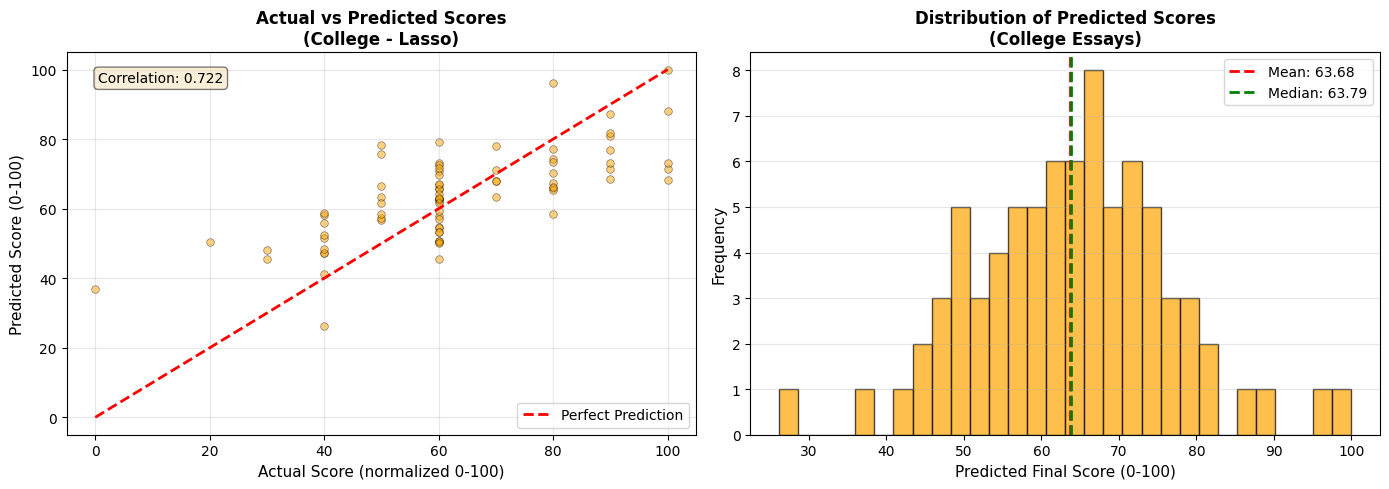

In [369]:
# Visualize College predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
ax1 = axes[0]
comparison_college = df_grade_college[['domain1_score', 'final_score']].dropna()
score_min_c = comparison_college['domain1_score'].min()
score_max_c = comparison_college['domain1_score'].max()
comparison_college['domain1_normalized'] = ((comparison_college['domain1_score'] - score_min_c) / (score_max_c - score_min_c)) * 100

ax1.scatter(comparison_college['domain1_normalized'], comparison_college['final_score'], 
            alpha=0.5, s=30, color='orange', edgecolor='k', linewidth=0.5)
ax1.plot([0, 100], [0, 100], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Score (normalized 0-100)', fontsize=11)
ax1.set_ylabel('Predicted Score (0-100)', fontsize=11)
ax1.set_title('Actual vs Predicted Scores\n(College - Lasso)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)
corr_c = comparison_college['domain1_normalized'].corr(comparison_college['final_score'])
ax1.text(0.05, 0.95, f'Correlation: {corr_c:.3f}', transform=ax1.transAxes, 
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Histogram
ax2 = axes[1]
ax2.hist(df_grade_college['final_score'], bins=30, alpha=0.7, color='orange', edgecolor='black')
ax2.axvline(df_grade_college['final_score'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f"Mean: {df_grade_college['final_score'].mean():.2f}")
ax2.axvline(df_grade_college['final_score'].median(), color='green', linestyle='--', linewidth=2, 
            label=f"Median: {df_grade_college['final_score'].median():.2f}")
ax2.set_xlabel('Predicted Final Score (0-100)', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Distribution of Predicted Scores\n(College Essays)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('lasso_college_predictions.png', dpi=300, bbox_inches='tight')
print("\n💾 Plot saved as 'lasso_college_predictions.png'")
plt.show()

In [370]:
df_grade_college.head(4)

,essay_id,essay_set,domain1_score,college_grade,ari_score,college_total_error,lexical_diversity_college,college_flow_cohesion,word_count,sentence_count,cleaned_for_lexical,cleaned_essay,final_score
55,56,1,10.0,15.308716,13.421820,7,145.985795,0.689628,471,22,over the past decade the percentage of people ...,"Over the past decade, the percentage of people...",96.013927
71,72,1,10.0,13.724666,13.115806,14,68.237668,0.793734,531,25,hello i decided to write in to the paper on th...,"Hello, I decided to write in to the paper on t...",74.151517
92,93,1,11.0,13.954579,14.193469,9,97.749861,0.690470,547,23,readers of mention mention should be well info...,"Readers of ""mention mention"" should be well in...",68.436583
131,132,1,11.0,13.295007,11.683437,19,82.098936,0.774840,432,25,dear mention i understand that the idea of adv...,"Dear mention, I understand that the idea of ad...",76.908416


## Lasso Regression for Graduate-Level Essays

Train a Lasso Regression model to predict final essay scores (scaled 0-100) using:
- Graduate Grade/Gunning Fog (`graduate_grade`)
- ARI Score (`ari_score`)
- Total Errors (`graduate_msc_phd_error`)
- Lexical Diversity (`lexical_diversity_graduate`)
- Flow Cohesion (`graduate_flow_cohesion`)

In [371]:
# Lasso Regression for Graduate-Level Essays
print("=" * 80)
print("LASSO REGRESSION MODEL FOR GRADUATE-LEVEL ESSAYS")
print("=" * 80)

# Prepare the data
df_grad_clean = df_grade_grad[['graduate_grade', 'ari_score', 'graduate_msc_phd_error', 
                                'lexical_diversity_graduate', 'graduate_flow_cohesion', 
                                'domain1_score']].dropna()

print(f" Dataset Info:")
print(f"Total samples: {len(df_grad_clean)}")
print(f"Original score range: {df_grad_clean['domain1_score'].min()} - {df_grad_clean['domain1_score'].max()}")

# Normalize domain1_score to 0-100 scale
score_min = df_grad_clean['domain1_score'].min()
score_max = df_grad_clean['domain1_score'].max()
df_grad_clean['domain1_score_normalized'] = ((df_grad_clean['domain1_score'] - score_min) / (score_max - score_min)) * 100

# Define features and target
X_grad = df_grad_clean[['graduate_grade', 'ari_score', 'graduate_msc_phd_error', 
                         'lexical_diversity_graduate', 'graduate_flow_cohesion']]
y_grad = df_grad_clean['domain1_score_normalized']

print(f" Features:")
for i, col in enumerate(X_grad.columns, 1):
    print(f"  {i}. {col}")

# Split and scale
X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X_grad, y_grad, test_size=0.2, random_state=42)
scaler_grad = StandardScaler()
X_train_g_scaled = scaler_grad.fit_transform(X_train_g)
X_test_g_scaled = scaler_grad.transform(X_test_g)

print(f" Train/Test Split: {len(X_train_g)} / {len(X_test_g)}")

# Find best alpha
print("\n🔍 Searching for optimal alpha...")
best_alpha_g = None
best_score_g = -np.inf

for alpha in [0.001, 0.01, 0.1, 1, 10, 100]:
    lasso_g = Lasso(alpha=alpha, random_state=42, max_iter=10000)
    cv_scores = cross_val_score(lasso_g, X_train_g_scaled, y_train_g, cv=5, scoring='neg_mean_squared_error')
    mean_score = cv_scores.mean()
    print(f"  Alpha = {alpha:6.3f} | CV MSE: {-mean_score:.4f}")
    if mean_score > best_score_g:
        best_score_g = mean_score
        best_alpha_g = alpha

print(f" Best alpha: {best_alpha_g}")

# Train final model
lasso_grad = Lasso(alpha=best_alpha_g, random_state=42, max_iter=10000)
lasso_grad.fit(X_train_g_scaled, y_train_g)

print(f"\n🔢 Feature Coefficients:")
for feature, coef in zip(X_grad.columns, lasso_grad.coef_):
    print(f"  {feature:30s}: {coef:8.4f}")

# Evaluate
y_pred_g = lasso_grad.predict(X_test_g_scaled)
print(f" Test Set Performance:")
print(f"  R² Score: {r2_score(y_test_g, y_pred_g):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test_g, y_pred_g)):.4f}")
print(f"  MAE: {mean_absolute_error(y_test_g, y_pred_g):.4f}")

LASSO REGRESSION MODEL FOR GRADUATE-LEVEL ESSAYS

📊 Dataset Info:
Total samples: 46
Original score range: 5.0 - 12.0

📋 Features:
  1. graduate_grade
  2. ari_score
  3. graduate_msc_phd_error
  4. lexical_diversity_graduate
  5. graduate_flow_cohesion

📊 Train/Test Split: 36 / 10

🔍 Searching for optimal alpha...
  Alpha =  0.001 | CV MSE: 623.3066
  Alpha =  0.010 | CV MSE: 619.5436
  Alpha =  0.100 | CV MSE: 585.0237
  Alpha =  1.000 | CV MSE: 521.4170
  Alpha = 10.000 | CV MSE: 569.0669
  Alpha = 100.000 | CV MSE: 569.0669
 Best alpha: 1

🔢 Feature Coefficients:
  graduate_grade                :  -0.0000
  ari_score                     :  -4.8310
  graduate_msc_phd_error        :   5.8878
  lexical_diversity_graduate    :   4.1035
  graduate_flow_cohesion        :   3.4465
 Test Set Performance:
  R² Score: 0.4503
  RMSE: 12.7105
  MAE: 10.1949


In [372]:
# Predict final scores for ALL graduate essays and add to dataframe
print("=" * 80)
print("PREDICTING FINAL SCORES FOR GRADUATE ESSAYS")
print("=" * 80)

# Prepare features for all rows
X_all_grad = df_grade_grad[['graduate_grade', 'ari_score', 'graduate_msc_phd_error', 
                             'lexical_diversity_graduate', 'graduate_flow_cohesion']].copy()

# Scale and predict
X_all_grad_scaled = scaler_grad.transform(X_all_grad)
predicted_scores_grad = lasso_grad.predict(X_all_grad_scaled)
predicted_scores_grad = np.clip(predicted_scores_grad, 0, 100)

# Add to dataframe
df_grade_grad['final_score'] = predicted_scores_grad

print(f" Predictions completed!")
print(f" Predicted Score Statistics:")
print(f"  Mean: {df_grade_grad['final_score'].mean():.2f}")
print(f"  Median: {df_grade_grad['final_score'].median():.2f}")
print(f"  Std Dev: {df_grade_grad['final_score'].std():.2f}")
print(f"  Min: {df_grade_grad['final_score'].min():.2f}")
print(f"  Max: {df_grade_grad['final_score'].max():.2f}")

print(f" Sample predictions (first 10 rows):")
sample_cols_g = ['essay_id', 'domain1_score', 'final_score', 'graduate_grade', 
                 'graduate_msc_phd_error', 'lexical_diversity_graduate', 'graduate_flow_cohesion']
print(df_grade_grad[sample_cols_g].head(10).to_string(index=False))

PREDICTING FINAL SCORES FOR GRADUATE ESSAYS
 Predictions completed!
 Predicted Score Statistics:
  Mean: 38.56
  Median: 38.08
  Std Dev: 9.24
  Min: 16.87
  Max: 60.89
 Sample predictions (first 10 rows):
 essay_id  domain1_score  final_score  graduate_grade  graduate_msc_phd_error  lexical_diversity_graduate  graduate_flow_cohesion
       51            9.0    43.402744       18.479914                      14                   62.996297                0.782433
       56           10.0    47.063526       16.373755                       7                  145.985795                0.689628
       64            7.0    35.420737       17.231644                       6                   21.371841                0.797169
      146            6.0    32.012974       25.747748                      19                   28.438751                0.748300
      151            8.0    40.465381       16.122449                       8                   84.065013                0.724678
      171     


💾 Plot saved as 'lasso_graduate_predictions.png'


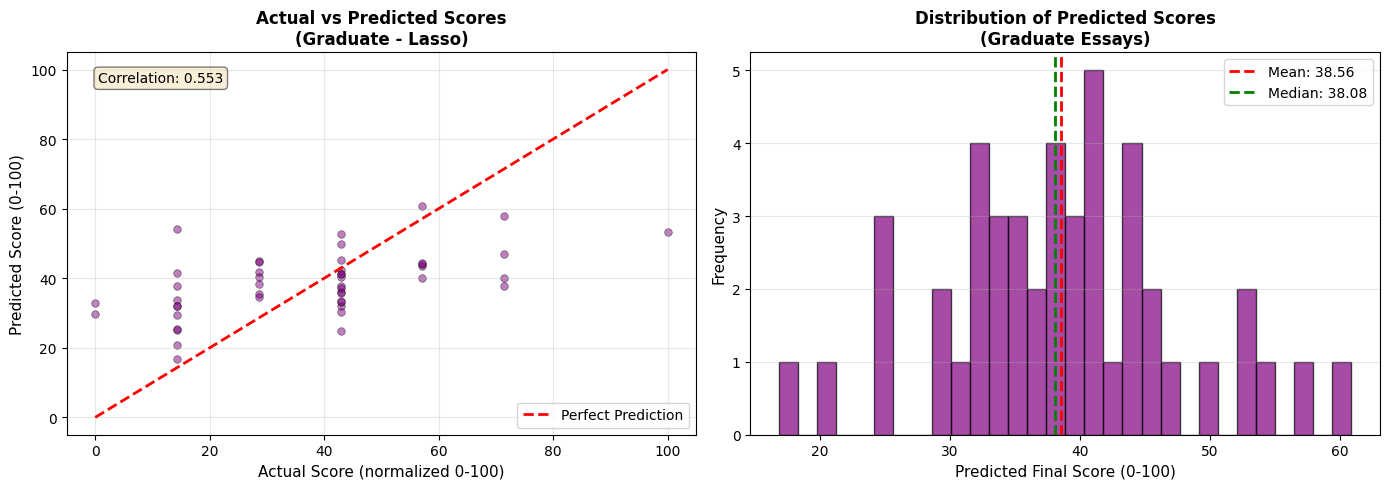

In [373]:
# Visualize Graduate predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
ax1 = axes[0]
comparison_grad = df_grade_grad[['domain1_score', 'final_score']].dropna()
score_min_g = comparison_grad['domain1_score'].min()
score_max_g = comparison_grad['domain1_score'].max()
comparison_grad['domain1_normalized'] = ((comparison_grad['domain1_score'] - score_min_g) / (score_max_g - score_min_g)) * 100

ax1.scatter(comparison_grad['domain1_normalized'], comparison_grad['final_score'], 
            alpha=0.5, s=30, color='purple', edgecolor='k', linewidth=0.5)
ax1.plot([0, 100], [0, 100], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Score (normalized 0-100)', fontsize=11)
ax1.set_ylabel('Predicted Score (0-100)', fontsize=11)
ax1.set_title('Actual vs Predicted Scores\n(Graduate - Lasso)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)
corr_g = comparison_grad['domain1_normalized'].corr(comparison_grad['final_score'])
ax1.text(0.05, 0.95, f'Correlation: {corr_g:.3f}', transform=ax1.transAxes, 
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Histogram
ax2 = axes[1]
ax2.hist(df_grade_grad['final_score'], bins=30, alpha=0.7, color='purple', edgecolor='black')
ax2.axvline(df_grade_grad['final_score'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f"Mean: {df_grade_grad['final_score'].mean():.2f}")
ax2.axvline(df_grade_grad['final_score'].median(), color='green', linestyle='--', linewidth=2, 
            label=f"Median: {df_grade_grad['final_score'].median():.2f}")
ax2.set_xlabel('Predicted Final Score (0-100)', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Distribution of Predicted Scores\n(Graduate Essays)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('lasso_graduate_predictions.png', dpi=300, bbox_inches='tight')
print("\n💾 Plot saved as 'lasso_graduate_predictions.png'")
plt.show()

## Summary: Lasso Regression Results Across All Education Levels

Compare the model performance and predicted scores across Grade 4-12, College, and Graduate levels.

In [377]:
# Summary comparison across all education levels
print("=" * 80)
print("LASSO REGRESSION SUMMARY: ALL EDUCATION LEVELS")
print("=" * 80)

summary_data = {
    'Education Level': ['Grade 4-12', 'College', 'Graduate'],
    'Sample Count': [len(df_grade_k12), len(df_grade_college), len(df_grade_grad)],
    'Mean Score': [
        df_grade_k12['final_score'].mean(),
        df_grade_college['final_score'].mean(),
        df_grade_grad['final_score'].mean()
    ],
    'Median Score': [
        df_grade_k12['final_score'].median(),
        df_grade_college['final_score'].median(),
        df_grade_grad['final_score'].median()
    ],
    'Std Dev': [
        df_grade_k12['final_score'].std(),
        df_grade_college['final_score'].std(),
        df_grade_grad['final_score'].std()
    ],
    'Score Range': [
        f"{df_grade_k12['final_score'].min():.1f} - {df_grade_k12['final_score'].max():.1f}",
        f"{df_grade_college['final_score'].min():.1f} - {df_grade_college['final_score'].max():.1f}",
        f"{df_grade_grad['final_score'].min():.1f} - {df_grade_grad['final_score'].max():.1f}"
    ]
}

summary_df = pd.DataFrame(summary_data)
print(" Predicted Score Statistics by Education Level:")
print(summary_df.to_string(index=False))

print("\n" + "=" * 80)
print(" ALL DATAFRAMES NOW HAVE 'final_score' COLUMN (0-100 scale)")
print("=" * 80)
print(" Summary:")
print(f"  • df_grade_k12: {len(df_grade_k12)} essays with predicted scores")
print(f"  • df_grade_college: {len(df_grade_college)} essays with predicted scores")
print(f"  • df_grade_grad: {len(df_grade_grad)} essays with predicted scores")
print(f"\n  Total essays scored: {len(df_grade_k12) + len(df_grade_college) + len(df_grade_grad)}")

LASSO REGRESSION SUMMARY: ALL EDUCATION LEVELS

📊 Predicted Score Statistics by Education Level:
Education Level  Sample Count  Mean Score  Median Score   Std Dev  Score Range
     Grade 4-12          1690   65.829249     65.368212  6.110208 42.3 - 100.0
        College            78   63.682817     63.785010 12.775703 26.2 - 100.0
       Graduate            46   38.559257     38.080103  9.244117  16.9 - 60.9

✅ ALL DATAFRAMES NOW HAVE 'final_score' COLUMN (0-100 scale)

📋 Summary:
  • df_grade_k12: 1690 essays with predicted scores
  • df_grade_college: 78 essays with predicted scores
  • df_grade_grad: 46 essays with predicted scores

  Total essays scored: 1814


In [379]:
df_grade_grad.head(10)

,essay_id,essay_set,domain1_score,graduate_grade,ari_score,graduate_msc_phd_error,lexical_diversity_graduate,graduate_flow_cohesion,word_count,sentence_count,cleaned_for_lexical,cleaned_essay,final_score
50,51,1,9.0,18.479914,18.917861,14,62.996297,0.782433,577,13,dear local newspaper have you ever wondered ho...,"Dear Local Newspaper, Have you ever wondered h...",43.402744
55,56,1,10.0,16.373755,13.421820,7,145.985795,0.689628,471,22,over the past decade the percentage of people ...,"Over the past decade, the percentage of people...",47.063526
63,64,1,7.0,17.231644,16.426651,6,21.371841,0.797169,222,6,dear news paper i think computers good for you...,Dear news paper I think computers good for you...,35.420737
145,146,1,6.0,25.747748,29.389009,19,28.438751,0.748300,185,3,dear local newspaper i think that usieng compu...,Dear local newspaper I think that usieng compu...,32.012974
150,151,1,8.0,16.122449,15.717429,8,84.065013,0.724678,247,7,dear local newspaper i don t agree with the pe...,Dear local newspaper I don’t agree with the pe...,40.465381
170,171,1,8.0,28.368696,29.902547,7,39.390282,0.858755,323,5,dear local newspaper mention opinion on the ef...,"Dear Local Newspaper, mention opinion on the e...",31.966888
171,172,1,8.0,18.882353,19.842118,4,57.889324,0.757340,258,6,dear mention mention i do agree that people sh...,Dear mention mention I do agree that people sh...,33.274731
186,187,1,5.0,17.322523,17.098108,3,44.451613,0.708772,112,3,dear newspaper i think that people should have...,"Dear,newspaper I think that people should have...",29.748078
307,308,1,6.0,26.659843,28.752047,11,24.196083,0.731250,128,2,i think computers are good because if you need...,I think computers are good because if you need...,25.176758
371,374,1,7.0,20.469136,21.224148,17,117.715182,0.698975,410,9,dear local newspaper i believe that people who...,"Dear local Newspaper, I believe that people wh...",45.031143


## Decision Tree Regression for Grade 4-12 Essays

Train a Decision Tree Regression model to predict final essay scores (scaled 0-100) using:
- Flesch-Kincaid Grade (`fk_grade`)
- ARI Score (`ari_score`)
- Total Errors (`grade_total_error`)
- Lexical Diversity (`lexical_diversity_grade`)
- Flow Cohesion (`grade_flow_cohesion`)

In [383]:

print("=" * 80)
print("DECISION TREE REGRESSION MODEL FOR GRADE 4-12 ESSAYS")
print("=" * 80)

# Prepare the data (same as Lasso)
df_k12_clean_dt = df_grade_k12[['fk_grade', 'ari_score', 'grade_total_error', 
                                 'lexical_diversity_grade', 'grade_flow_cohesion', 
                                 'domain1_score']].dropna()

print(f" Dataset Info:")
print(f"Total samples: {len(df_k12_clean_dt)}")

# Normalize domain1_score to 0-100 scale
score_min = df_k12_clean_dt['domain1_score'].min()
score_max = df_k12_clean_dt['domain1_score'].max()
df_k12_clean_dt['domain1_score_normalized'] = ((df_k12_clean_dt['domain1_score'] - score_min) / (score_max - score_min)) * 100

# Define features and target
X_dt = df_k12_clean_dt[['fk_grade', 'ari_score', 'grade_total_error', 
                         'lexical_diversity_grade', 'grade_flow_cohesion']]
y_dt = df_k12_clean_dt['domain1_score_normalized']

print(f" Features:")
for i, col in enumerate(X_dt.columns, 1):
    print(f"  {i}. {col}")

# Split the data
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X_dt, y_dt, test_size=0.2, random_state=42)

print(f" Train/Test Split: {len(X_train_dt)} / {len(X_test_dt)}")

# Find best max_depth using cross-validation
print(" Searching for optimal max_depth...")
depths = [3, 5, 7, 10, 15, 20, None]
best_depth = None
best_score_dt = -np.inf

for depth in depths:
    dt = DecisionTreeRegressor(max_depth=depth, random_state=42, min_samples_split=5)
    cv_scores = cross_val_score(dt, X_train_dt, y_train_dt, cv=5, scoring='neg_mean_squared_error')
    mean_score = cv_scores.mean()
    depth_str = str(depth) if depth else "None"
    print(f"  Max Depth = {depth_str:>4s} | CV MSE: {-mean_score:.4f} | CV R²: {1 + mean_score/y_train_dt.var():.4f}")
    
    if mean_score > best_score_dt:
        best_score_dt = mean_score
        best_depth = depth

print(f" Best max_depth: {best_depth}")

# Train final model
dt_k12 = DecisionTreeRegressor(max_depth=best_depth, random_state=42, min_samples_split=5)
dt_k12.fit(X_train_dt, y_train_dt)

print(f" Decision Tree Model Trained!")
print(f" Feature Importances:")
for feature, importance in zip(X_dt.columns, dt_k12.feature_importances_):
    print(f"  {feature:30s}: {importance:8.4f}")

# Evaluate on test set
y_pred_dt = dt_k12.predict(X_test_dt)
mse_dt = mean_squared_error(y_test_dt, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
mae_dt = mean_absolute_error(y_test_dt, y_pred_dt)
r2_dt = r2_score(y_test_dt, y_pred_dt)

print(f" Test Set Performance:")
print(f"  R² Score: {r2_dt:.4f}")
print(f"  RMSE: {rmse_dt:.4f}")
print(f"  MAE: {mae_dt:.4f}")
print(f"  MSE: {mse_dt:.4f}")

DECISION TREE REGRESSION MODEL FOR GRADE 4-12 ESSAYS
 Dataset Info:
Total samples: 1690
 Features:
  1. fk_grade
  2. ari_score
  3. grade_total_error
  4. lexical_diversity_grade
  5. grade_flow_cohesion
 Train/Test Split: 1352 / 338
 Searching for optimal max_depth...
  Max Depth =    3 | CV MSE: 189.3779 | CV R²: 0.1292
  Max Depth =    5 | CV MSE: 187.1349 | CV R²: 0.1395
  Max Depth =    7 | CV MSE: 199.1318 | CV R²: 0.0844
  Max Depth =   10 | CV MSE: 230.9088 | CV R²: -0.0617
  Max Depth =   15 | CV MSE: 278.6131 | CV R²: -0.2811
  Max Depth =   20 | CV MSE: 294.9223 | CV R²: -0.3561
  Max Depth = None | CV MSE: 301.0963 | CV R²: -0.3845
 Best max_depth: 5
 Decision Tree Model Trained!
 Feature Importances:
  fk_grade                      :   0.0285
  ari_score                     :   0.0718
  grade_total_error             :   0.2950
  lexical_diversity_grade       :   0.3804
  grade_flow_cohesion           :   0.2243
 Test Set Performance:
  R² Score: 0.1275
  RMSE: 13.7766
  M

In [384]:
# Predict final scores for ALL Grade 4-12 essays using Decision Tree
print("=" * 80)
print("PREDICTING FINAL SCORES FOR GRADE 4-12 ESSAYS (Decision Tree)")
print("=" * 80)

# Prepare features for all rows
X_all_dt = df_grade_k12[['fk_grade', 'ari_score', 'grade_total_error', 
                          'lexical_diversity_grade', 'grade_flow_cohesion']].copy()

# Predict scores (0-100 scale)
predicted_scores_dt = dt_k12.predict(X_all_dt)

# Ensure predictions are within 0-100 range
predicted_scores_dt = np.clip(predicted_scores_dt, 0, 100)

# Add predicted scores as new column
df_grade_k12['final_score_dt'] = predicted_scores_dt

print(f" Predictions completed!")
print(f" Predicted Score Statistics (Decision Tree):")
print(f"  Mean: {df_grade_k12['final_score_dt'].mean():.2f}")
print(f"  Median: {df_grade_k12['final_score_dt'].median():.2f}")
print(f"  Std Dev: {df_grade_k12['final_score_dt'].std():.2f}")
print(f"  Min: {df_grade_k12['final_score_dt'].min():.2f}")
print(f"  Max: {df_grade_k12['final_score_dt'].max():.2f}")

print(f"\n📋 Comparison: Lasso vs Decision Tree (first 10 rows):")
comparison_cols = ['essay_id', 'domain1_score', 'final_score', 'final_score_dt', 
                   'fk_grade', 'grade_total_error']
print(df_grade_k12[comparison_cols].head(10).to_string(index=False))

print(f" New column 'final_score_dt' added to df_grade_k12!")
print(f"   Range: 0-100 (predicted using Decision Tree Regression)")

PREDICTING FINAL SCORES FOR GRADE 4-12 ESSAYS (Decision Tree)
 Predictions completed!
 Predicted Score Statistics (Decision Tree):
  Mean: 65.93
  Median: 68.44
  Std Dev: 8.37
  Min: 0.00
  Max: 90.00

📋 Comparison: Lasso vs Decision Tree (first 10 rows):
 essay_id  domain1_score  final_score  final_score_dt  fk_grade  grade_total_error
        1            8.0    71.161356       73.069909  9.103751                 12
        2            9.0    71.001582       73.069909  9.562362                 14
        3            7.0    59.008722       57.826087  9.353469                  4
        4           10.0    75.512073       65.925926 10.331942                 38
        5            8.0    66.207773       68.444444  7.710914                 11
        6            8.0    59.390573       65.742574  6.523323                 11
        7           10.0    65.367525       68.032787  8.183172                  5
        8           10.0    64.237009       64.014085  6.905519                

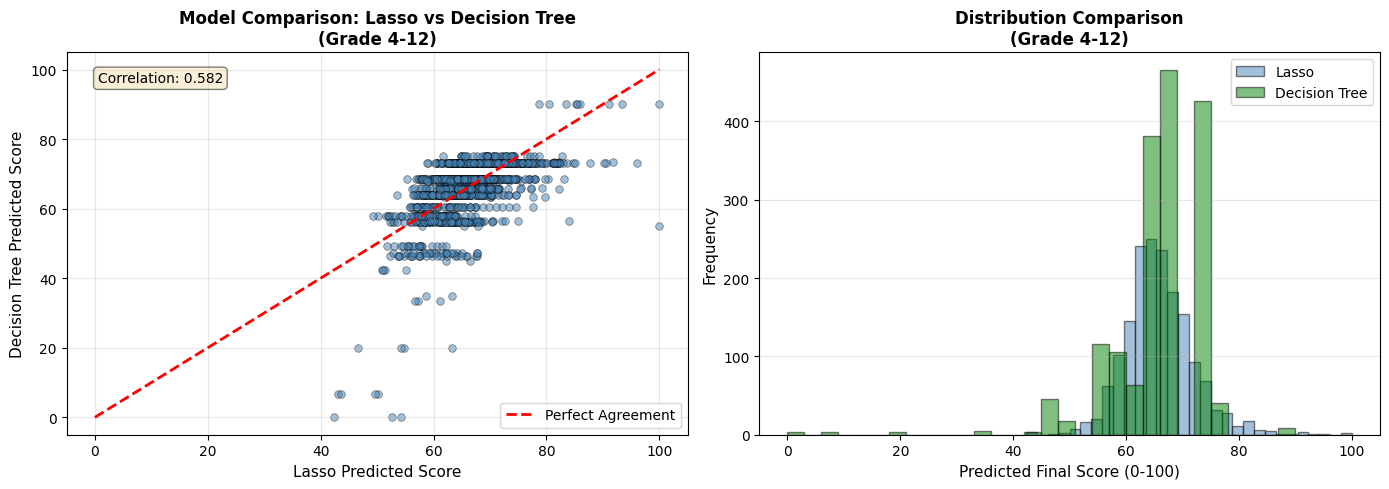

In [388]:
# Visualize Decision Tree predictions for Grade 4-12
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Scatter plot comparing Lasso vs Decision Tree
ax1 = axes[0]
ax1.scatter(df_grade_k12['final_score'], df_grade_k12['final_score_dt'], 
            alpha=0.5, s=30, color='steelblue', edgecolor='k', linewidth=0.5)
ax1.plot([0, 100], [0, 100], 'r--', lw=2, label='Perfect Agreement')
ax1.set_xlabel('Lasso Predicted Score', fontsize=11)
ax1.set_ylabel('Decision Tree Predicted Score', fontsize=11)
ax1.set_title('Model Comparison: Lasso vs Decision Tree\n(Grade 4-12)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)
corr_models = df_grade_k12['final_score'].corr(df_grade_k12['final_score_dt'])
ax1.text(0.05, 0.95, f'Correlation: {corr_models:.3f}', transform=ax1.transAxes, 
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Distribution comparison
ax2 = axes[1]
ax2.hist(df_grade_k12['final_score'], bins=30, alpha=0.5, color='steelblue', 
         edgecolor='black', label='Lasso')
ax2.hist(df_grade_k12['final_score_dt'], bins=30, alpha=0.5, color='green', 
         edgecolor='black', label='Decision Tree')
ax2.set_xlabel('Predicted Final Score (0-100)', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Distribution Comparison\n(Grade 4-12)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('dt_grade_k12_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

In [389]:
df_grade_k12.head(10)

,essay_id,essay_set,domain1_score,fk_grade,ari_score,grade_total_error,lexical_diversity_grade,grade_flow_cohesion,word_count,sentence_count,cleaned_for_lexical,cleaned_essay,final_score,final_score_dt
0,1,1,8.0,9.103751,11.081943,12,88.346423,0.750979,350,16,dear local newspaper i think effects computers...,"Dear local newspaper, I think effects computer...",71.161356,73.069909
1,2,1,9.0,9.562362,10.077005,14,62.856334,0.782589,423,20,dear mention mention i believe that using comp...,"Dear mention mention, I believe that using com...",71.001582,73.069909
2,3,1,7.0,9.353469,9.822135,4,41.300119,0.752036,283,14,dear mention mention mention more and more peo...,"Dear, mention mention mention More and more pe...",59.008722,57.826087
3,4,1,10.0,10.331942,11.751795,38,31.941489,0.770717,530,27,dear local newspaper mention i have found that...,"Dear Local Newspaper, mention I have found tha...",75.512073,65.925926
4,5,1,8.0,7.710914,7.611226,11,42.280352,0.798870,473,30,dear mention i know having computers has a pos...,"Dear mention, I know having computers has a po...",66.207773,68.444444
5,6,1,8.0,6.523323,6.169695,11,59.900266,0.711585,247,16,dear mention i think that computers have a neg...,"Dear mention, I think that computers have a ne...",59.390573,65.742574
6,7,1,10.0,8.183172,8.747108,5,64.864464,0.774007,508,30,did you know that more and more people these d...,Did you know that more and more people these d...,65.367525,68.032787
7,8,1,10.0,6.905519,6.599197,9,44.623423,0.790181,508,40,mention of people agree that computers make li...,mention of people agree that computers make li...,64.237009,64.014085
8,9,1,9.0,6.100754,5.691216,10,128.402222,0.727197,451,35,dear reader mention has had a dramatic effect ...,"Dear reader, mention has had a dramatic effect...",73.070283,75.000000
9,10,1,9.0,7.806534,8.208508,15,64.608001,0.756691,519,26,in the mention we have the technology of a com...,In the mention we have the technology of a com...,67.796109,73.069909


## Decision Tree Regression for College-Level Essays

Train a Decision Tree Regression model to predict final essay scores (scaled 0-100) using:
- College Grade/SMOG Index (`college_grade`)
- ARI Score (`ari_score`)
- Total Errors (`college_total_error`)
- Lexical Diversity (`lexical_diversity_college`)
- Flow Cohesion (`college_flow_cohesion`)

In [390]:
# Decision Tree Regression for College-Level Essays
print("=" * 80)
print("DECISION TREE REGRESSION MODEL FOR COLLEGE-LEVEL ESSAYS")
print("=" * 80)

# Prepare the data
df_college_clean_dt = df_grade_college[['college_grade', 'ari_score', 'college_total_error', 
                                         'lexical_diversity_college', 'college_flow_cohesion', 
                                         'domain1_score']].dropna()

print(f" Dataset Info:")
print(f"Total samples: {len(df_college_clean_dt)}")

# Normalize domain1_score to 0-100 scale
score_min_c = df_college_clean_dt['domain1_score'].min()
score_max_c = df_college_clean_dt['domain1_score'].max()
df_college_clean_dt['domain1_score_normalized'] = ((df_college_clean_dt['domain1_score'] - score_min_c) / (score_max_c - score_min_c)) * 100

# Define features and target
X_college_dt = df_college_clean_dt[['college_grade', 'ari_score', 'college_total_error', 
                                     'lexical_diversity_college', 'college_flow_cohesion']]
y_college_dt = df_college_clean_dt['domain1_score_normalized']

print(f" Features:")
for i, col in enumerate(X_college_dt.columns, 1):
    print(f"  {i}. {col}")

# Split and find best depth
X_train_c_dt, X_test_c_dt, y_train_c_dt, y_test_c_dt = train_test_split(X_college_dt, y_college_dt, test_size=0.2, random_state=42)

print(f" Train/Test Split: {len(X_train_c_dt)} / {len(X_test_c_dt)}")
print(" Searching for optimal max_depth...")

best_depth_c = None
best_score_c_dt = -np.inf

for depth in [3, 5, 7, 10, 15, 20, None]:
    dt_c = DecisionTreeRegressor(max_depth=depth, random_state=42, min_samples_split=5)
    cv_scores = cross_val_score(dt_c, X_train_c_dt, y_train_c_dt, cv=5, scoring='neg_mean_squared_error')
    mean_score = cv_scores.mean()
    depth_str = str(depth) if depth else "None"
    print(f"  Max Depth = {depth_str:>4s} | CV MSE: {-mean_score:.4f}")
    if mean_score > best_score_c_dt:
        best_score_c_dt = mean_score
        best_depth_c = depth

print(f" Best max_depth: {best_depth_c}")

# Train final model
dt_college = DecisionTreeRegressor(max_depth=best_depth_c, random_state=42, min_samples_split=5)
dt_college.fit(X_train_c_dt, y_train_c_dt)

print(f" Feature Importances:")
for feature, importance in zip(X_college_dt.columns, dt_college.feature_importances_):
    print(f"  {feature:30s}: {importance:8.4f}")

# Evaluate
y_pred_c_dt = dt_college.predict(X_test_c_dt)
print(f" Test Set Performance:")
print(f"  R² Score: {r2_score(y_test_c_dt, y_pred_c_dt):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test_c_dt, y_pred_c_dt)):.4f}")
print(f"  MAE: {mean_absolute_error(y_test_c_dt, y_pred_c_dt):.4f}")

DECISION TREE REGRESSION MODEL FOR COLLEGE-LEVEL ESSAYS
 Dataset Info:
Total samples: 78
 Features:
  1. college_grade
  2. ari_score
  3. college_total_error
  4. lexical_diversity_college
  5. college_flow_cohesion
 Train/Test Split: 62 / 16
 Searching for optimal max_depth...
  Max Depth =    3 | CV MSE: 296.6832
  Max Depth =    5 | CV MSE: 333.3043
  Max Depth =    7 | CV MSE: 333.3449
  Max Depth =   10 | CV MSE: 333.3449
  Max Depth =   15 | CV MSE: 333.3449
  Max Depth =   20 | CV MSE: 333.3449
  Max Depth = None | CV MSE: 333.3449
 Best max_depth: 3
 Feature Importances:
  college_grade                 :   0.1004
  ari_score                     :   0.0899
  college_total_error           :   0.1450
  lexical_diversity_college     :   0.4907
  college_flow_cohesion         :   0.1740
 Test Set Performance:
  R² Score: -1.4044
  RMSE: 23.4001
  MAE: 17.7083


In [391]:
# Predict final scores for ALL college essays using Decision Tree
print("=" * 80)
print("PREDICTING FINAL SCORES FOR COLLEGE ESSAYS (Decision Tree)")
print("=" * 80)

# Prepare features for all rows
X_all_college_dt = df_grade_college[['college_grade', 'ari_score', 'college_total_error', 
                                      'lexical_diversity_college', 'college_flow_cohesion']].copy()

# Predict scores
predicted_scores_college_dt = dt_college.predict(X_all_college_dt)
predicted_scores_college_dt = np.clip(predicted_scores_college_dt, 0, 100)

# Add to dataframe
df_grade_college['final_score_dt'] = predicted_scores_college_dt

print(f" Predictions completed!")
print(f" Predicted Score Statistics (Decision Tree):")
print(f"  Mean: {df_grade_college['final_score_dt'].mean():.2f}")
print(f"  Median: {df_grade_college['final_score_dt'].median():.2f}")
print(f"  Std Dev: {df_grade_college['final_score_dt'].std():.2f}")
print(f"  Min: {df_grade_college['final_score_dt'].min():.2f}")
print(f"  Max: {df_grade_college['final_score_dt'].max():.2f}")

print(f" Comparison: Lasso vs Decision Tree (first 10 rows):")
comparison_cols_c = ['essay_id', 'domain1_score', 'final_score', 'final_score_dt', 
                     'college_grade', 'college_total_error']
print(df_grade_college[comparison_cols_c].head(10).to_string(index=False))

print(f" Column 'final_score_dt' added to df_grade_college!")

PREDICTING FINAL SCORES FOR COLLEGE ESSAYS (Decision Tree)
 Predictions completed!
 Predicted Score Statistics (Decision Tree):
  Mean: 64.11
  Median: 63.33
  Std Dev: 18.07
  Min: 0.00
  Max: 95.00
 Comparison: Lasso vs Decision Tree (first 10 rows):
 essay_id  domain1_score  final_score  final_score_dt  college_grade  college_total_error
       56           10.0    96.013927       95.000000      15.308716                    7
       72           10.0    74.151517       67.142857      13.724666                   14
       93           11.0    68.436583       95.000000      13.954579                    9
      132           11.0    76.908416       95.000000      13.295007                   19
      145           10.0    77.173021       63.333333      13.227904                   19
      164            8.0    62.327708       53.888889      14.712193                    1
      171            8.0    62.763188       53.888889      15.112258                    7
      223            8.0   

 Plot saved as 'dt_college_predictions.png'


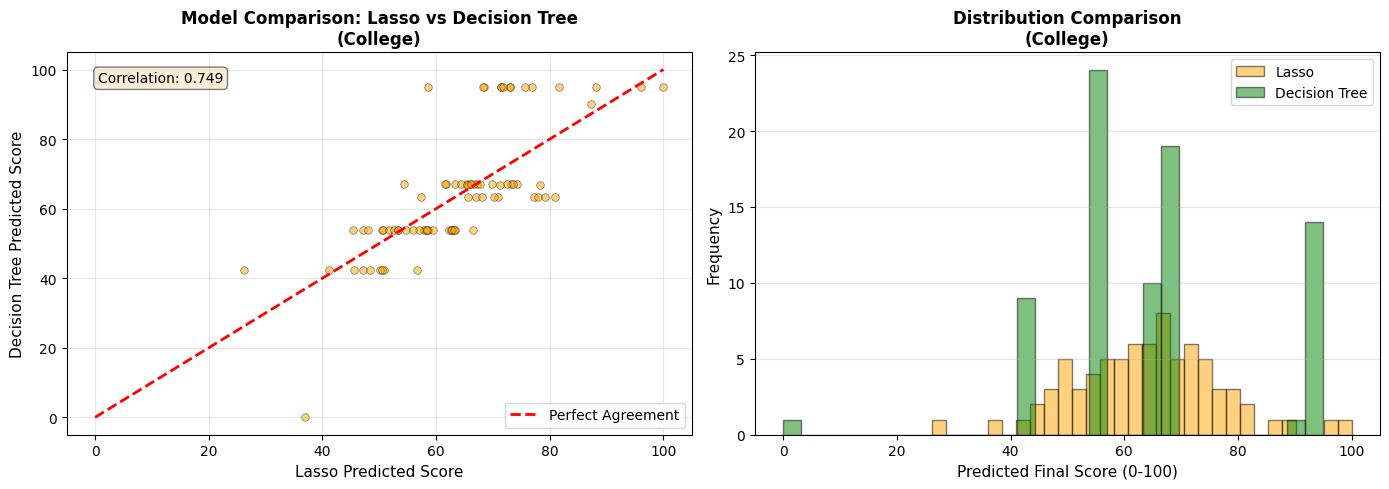

In [392]:
# Visualize Decision Tree predictions for College
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
ax1 = axes[0]
ax1.scatter(df_grade_college['final_score'], df_grade_college['final_score_dt'], 
            alpha=0.5, s=30, color='orange', edgecolor='k', linewidth=0.5)
ax1.plot([0, 100], [0, 100], 'r--', lw=2, label='Perfect Agreement')
ax1.set_xlabel('Lasso Predicted Score', fontsize=11)
ax1.set_ylabel('Decision Tree Predicted Score', fontsize=11)
ax1.set_title('Model Comparison: Lasso vs Decision Tree\n(College)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)
corr_models_c = df_grade_college['final_score'].corr(df_grade_college['final_score_dt'])
ax1.text(0.05, 0.95, f'Correlation: {corr_models_c:.3f}', transform=ax1.transAxes, 
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Histogram
ax2 = axes[1]
ax2.hist(df_grade_college['final_score'], bins=30, alpha=0.5, color='orange', 
         edgecolor='black', label='Lasso')
ax2.hist(df_grade_college['final_score_dt'], bins=30, alpha=0.5, color='green', 
         edgecolor='black', label='Decision Tree')
ax2.set_xlabel('Predicted Final Score (0-100)', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Distribution Comparison\n(College)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('dt_college_predictions.png', dpi=300, bbox_inches='tight')
print(" Plot saved as 'dt_college_predictions.png'")
plt.show()

In [397]:
df_grade_college.head(10)

,essay_id,essay_set,domain1_score,college_grade,ari_score,college_total_error,lexical_diversity_college,college_flow_cohesion,word_count,sentence_count,cleaned_for_lexical,cleaned_essay,final_score,final_score_dt
55,56,1,10.0,15.308716,13.421820,7,145.985795,0.689628,471,22,over the past decade the percentage of people ...,"Over the past decade, the percentage of people...",96.013927,95.000000
71,72,1,10.0,13.724666,13.115806,14,68.237668,0.793734,531,25,hello i decided to write in to the paper on th...,"Hello, I decided to write in to the paper on t...",74.151517,67.142857
92,93,1,11.0,13.954579,14.193469,9,97.749861,0.690470,547,23,readers of mention mention should be well info...,"Readers of ""mention mention"" should be well in...",68.436583,95.000000
131,132,1,11.0,13.295007,11.683437,19,82.098936,0.774840,432,25,dear mention i understand that the idea of adv...,"Dear mention, I understand that the idea of ad...",76.908416,95.000000
144,145,1,10.0,13.227904,11.098071,19,97.202514,0.738193,365,24,dear local newspaper mention are you adminitra...,Dear Local Newspaper mention are you adminitra...,77.173021,63.333333
163,164,1,8.0,14.712193,15.731111,1,43.163012,0.778216,249,9,dear local newspaper mention you think compute...,"Dear local newspaper, mention you think comput...",62.327708,53.888889
170,171,1,8.0,15.112258,29.902547,7,39.390282,0.858755,323,5,dear local newspaper mention opinion on the ef...,"Dear Local Newspaper, mention opinion on the e...",62.763188,53.888889
222,223,1,8.0,13.023867,14.433279,9,71.437673,0.742937,433,15,dear mention i think the way how more and more...,"Dear mention, I think the way how more and mor...",57.875135,53.888889
307,308,1,6.0,13.023867,28.752047,11,24.196083,0.731250,128,2,i think computers are good because if you need...,I think computers are good because if you need...,26.155063,42.222222
309,310,1,10.0,13.115065,11.562067,28,39.769697,0.777101,367,18,dear mention in a pole conducted by the mentio...,"Dear mention, In a pole conducted by the menti...",67.251080,67.142857


## Decision Tree Regression for Graduate-Level Essays

Train a Decision Tree Regression model to predict final essay scores (scaled 0-100) using:
- Graduate Grade/Gunning Fog (`graduate_grade`)
- ARI Score (`ari_score`)
- Total Errors (`graduate_msc_phd_error`)
- Lexical Diversity (`lexical_diversity_graduate`)
- Flow Cohesion (`graduate_flow_cohesion`)

In [393]:
# Decision Tree Regression for Graduate-Level Essays
print("=" * 80)
print("DECISION TREE REGRESSION MODEL FOR GRADUATE-LEVEL ESSAYS")
print("=" * 80)

# Prepare the data
df_grad_clean_dt = df_grade_grad[['graduate_grade', 'ari_score', 'graduate_msc_phd_error', 
                                   'lexical_diversity_graduate', 'graduate_flow_cohesion', 
                                   'domain1_score']].dropna()

print(f" Dataset Info:")
print(f"Total samples: {len(df_grad_clean_dt)}")

# Normalize domain1_score to 0-100 scale
score_min_g = df_grad_clean_dt['domain1_score'].min()
score_max_g = df_grad_clean_dt['domain1_score'].max()
df_grad_clean_dt['domain1_score_normalized'] = ((df_grad_clean_dt['domain1_score'] - score_min_g) / (score_max_g - score_min_g)) * 100

# Define features and target
X_grad_dt = df_grad_clean_dt[['graduate_grade', 'ari_score', 'graduate_msc_phd_error', 
                               'lexical_diversity_graduate', 'graduate_flow_cohesion']]
y_grad_dt = df_grad_clean_dt['domain1_score_normalized']

print(f" Features:")
for i, col in enumerate(X_grad_dt.columns, 1):
    print(f"  {i}. {col}")

# Split and find best depth
X_train_g_dt, X_test_g_dt, y_train_g_dt, y_test_g_dt = train_test_split(X_grad_dt, y_grad_dt, test_size=0.2, random_state=42)

print(f" Train/Test Split: {len(X_train_g_dt)} / {len(X_test_g_dt)}")
print(" Searching for optimal max_depth...")

best_depth_g = None
best_score_g_dt = -np.inf

for depth in [3, 5, 7, 10, 15, 20, None]:
    dt_g = DecisionTreeRegressor(max_depth=depth, random_state=42, min_samples_split=5)
    cv_scores = cross_val_score(dt_g, X_train_g_dt, y_train_g_dt, cv=5, scoring='neg_mean_squared_error')
    mean_score = cv_scores.mean()
    depth_str = str(depth) if depth else "None"
    print(f"  Max Depth = {depth_str:>4s} | CV MSE: {-mean_score:.4f}")
    if mean_score > best_score_g_dt:
        best_score_g_dt = mean_score
        best_depth_g = depth

print(f" Best max_depth: {best_depth_g}")

# Train final model
dt_grad = DecisionTreeRegressor(max_depth=best_depth_g, random_state=42, min_samples_split=5)
dt_grad.fit(X_train_g_dt, y_train_g_dt)

print(f" Feature Importances:")
for feature, importance in zip(X_grad_dt.columns, dt_grad.feature_importances_):
    print(f"  {feature:30s}: {importance:8.4f}")

# Evaluate
y_pred_g_dt = dt_grad.predict(X_test_g_dt)
print(f" Test Set Performance:")
print(f"  R² Score: {r2_score(y_test_g_dt, y_pred_g_dt):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test_g_dt, y_pred_g_dt)):.4f}")
print(f"  MAE: {mean_absolute_error(y_test_g_dt, y_pred_g_dt):.4f}")

DECISION TREE REGRESSION MODEL FOR GRADUATE-LEVEL ESSAYS
 Dataset Info:
Total samples: 46
 Features:
  1. graduate_grade
  2. ari_score
  3. graduate_msc_phd_error
  4. lexical_diversity_graduate
  5. graduate_flow_cohesion
 Train/Test Split: 36 / 10
 Searching for optimal max_depth...
  Max Depth =    3 | CV MSE: 698.0017
  Max Depth =    5 | CV MSE: 903.4985
  Max Depth =    7 | CV MSE: 903.8306
  Max Depth =   10 | CV MSE: 903.8306
  Max Depth =   15 | CV MSE: 903.8306
  Max Depth =   20 | CV MSE: 903.8306
  Max Depth = None | CV MSE: 903.8306
 Best max_depth: 3
 Feature Importances:
  graduate_grade                :   0.6335
  ari_score                     :   0.0000
  graduate_msc_phd_error        :   0.2739
  lexical_diversity_graduate    :   0.0000
  graduate_flow_cohesion        :   0.0926
 Test Set Performance:
  R² Score: -0.1545
  RMSE: 18.4197
  MAE: 15.7143


In [394]:
# Predict final scores for ALL graduate essays using Decision Tree
print("=" * 80)
print("PREDICTING FINAL SCORES FOR GRADUATE ESSAYS (Decision Tree)")
print("=" * 80)

# Prepare features for all rows
X_all_grad_dt = df_grade_grad[['graduate_grade', 'ari_score', 'graduate_msc_phd_error', 
                                'lexical_diversity_graduate', 'graduate_flow_cohesion']].copy()

# Predict scores
predicted_scores_grad_dt = dt_grad.predict(X_all_grad_dt)
predicted_scores_grad_dt = np.clip(predicted_scores_grad_dt, 0, 100)

# Add to dataframe
df_grade_grad['final_score_dt'] = predicted_scores_grad_dt

print(f" Predictions completed!")
print(f" Predicted Score Statistics (Decision Tree):")
print(f"  Mean: {df_grade_grad['final_score_dt'].mean():.2f}")
print(f"  Median: {df_grade_grad['final_score_dt'].median():.2f}")
print(f"  Std Dev: {df_grade_grad['final_score_dt'].std():.2f}")
print(f"  Min: {df_grade_grad['final_score_dt'].min():.2f}")
print(f"  Max: {df_grade_grad['final_score_dt'].max():.2f}")

print(f" Comparison: Lasso vs Decision Tree (first 10 rows):")
comparison_cols_g = ['essay_id', 'domain1_score', 'final_score', 'final_score_dt', 
                     'graduate_grade', 'graduate_msc_phd_error']
print(df_grade_grad[comparison_cols_g].head(10).to_string(index=False))

print(f" Column 'final_score_dt' added to df_grade_grad!")

PREDICTING FINAL SCORES FOR GRADUATE ESSAYS (Decision Tree)
 Predictions completed!
 Predicted Score Statistics (Decision Tree):
  Mean: 38.66
  Median: 32.14
  Std Dev: 15.45
  Min: 14.29
  Max: 100.00
 Comparison: Lasso vs Decision Tree (first 10 rows):
 essay_id  domain1_score  final_score  final_score_dt  graduate_grade  graduate_msc_phd_error
       51            9.0    43.402744       50.000000       18.479914                      14
       56           10.0    47.063526       50.000000       16.373755                       7
       64            7.0    35.420737       28.571429       17.231644                       6
      146            6.0    32.012974       32.142857       25.747748                      19
      151            8.0    40.465381       50.000000       16.122449                       8
      171            8.0    31.966888       32.142857       28.368696                       7
      172            8.0    33.274731       28.571429       18.882353                 

 Plot saved as 'dt_graduate_predictions.png'


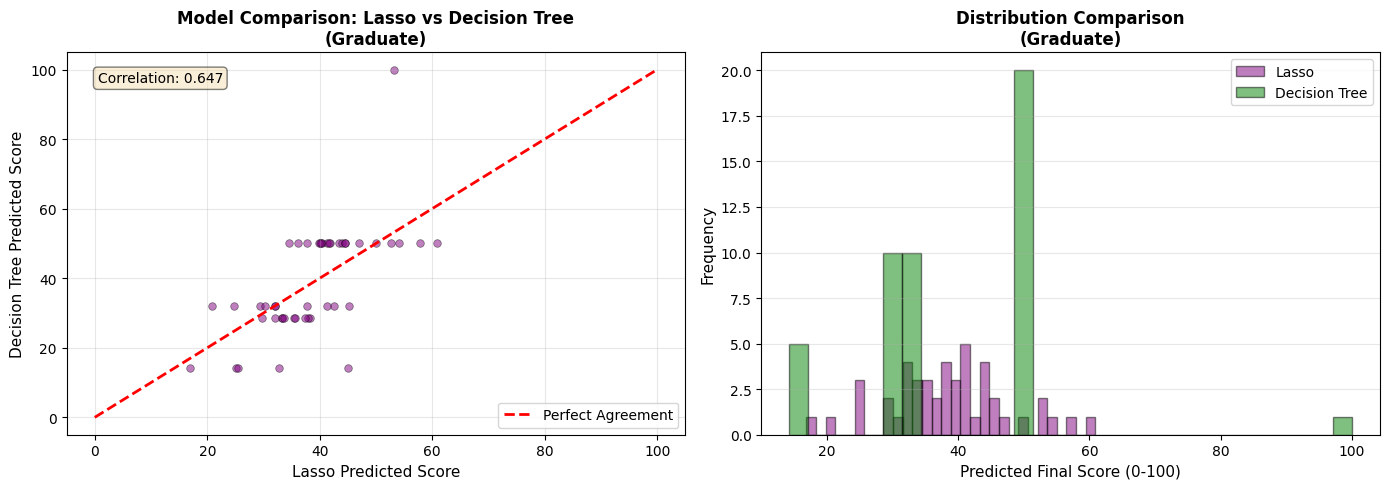

In [395]:
# Visualize Decision Tree predictions for Graduate
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
ax1 = axes[0]
ax1.scatter(df_grade_grad['final_score'], df_grade_grad['final_score_dt'], 
            alpha=0.5, s=30, color='purple', edgecolor='k', linewidth=0.5)
ax1.plot([0, 100], [0, 100], 'r--', lw=2, label='Perfect Agreement')
ax1.set_xlabel('Lasso Predicted Score', fontsize=11)
ax1.set_ylabel('Decision Tree Predicted Score', fontsize=11)
ax1.set_title('Model Comparison: Lasso vs Decision Tree\n(Graduate)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)
corr_models_g = df_grade_grad['final_score'].corr(df_grade_grad['final_score_dt'])
ax1.text(0.05, 0.95, f'Correlation: {corr_models_g:.3f}', transform=ax1.transAxes, 
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Histogram
ax2 = axes[1]
ax2.hist(df_grade_grad['final_score'], bins=30, alpha=0.5, color='purple', 
         edgecolor='black', label='Lasso')
ax2.hist(df_grade_grad['final_score_dt'], bins=30, alpha=0.5, color='green', 
         edgecolor='black', label='Decision Tree')
ax2.set_xlabel('Predicted Final Score (0-100)', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Distribution Comparison\n(Graduate)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('dt_graduate_predictions.png', dpi=300, bbox_inches='tight')
print(" Plot saved as 'dt_graduate_predictions.png'")
plt.show()

In [396]:
df_grade_grad.head(10)

,essay_id,essay_set,domain1_score,graduate_grade,ari_score,graduate_msc_phd_error,lexical_diversity_graduate,graduate_flow_cohesion,word_count,sentence_count,cleaned_for_lexical,cleaned_essay,final_score,final_score_dt
50,51,1,9.0,18.479914,18.917861,14,62.996297,0.782433,577,13,dear local newspaper have you ever wondered ho...,"Dear Local Newspaper, Have you ever wondered h...",43.402744,50.000000
55,56,1,10.0,16.373755,13.421820,7,145.985795,0.689628,471,22,over the past decade the percentage of people ...,"Over the past decade, the percentage of people...",47.063526,50.000000
63,64,1,7.0,17.231644,16.426651,6,21.371841,0.797169,222,6,dear news paper i think computers good for you...,Dear news paper I think computers good for you...,35.420737,28.571429
145,146,1,6.0,25.747748,29.389009,19,28.438751,0.748300,185,3,dear local newspaper i think that usieng compu...,Dear local newspaper I think that usieng compu...,32.012974,32.142857
150,151,1,8.0,16.122449,15.717429,8,84.065013,0.724678,247,7,dear local newspaper i don t agree with the pe...,Dear local newspaper I don’t agree with the pe...,40.465381,50.000000
170,171,1,8.0,28.368696,29.902547,7,39.390282,0.858755,323,5,dear local newspaper mention opinion on the ef...,"Dear Local Newspaper, mention opinion on the e...",31.966888,32.142857
171,172,1,8.0,18.882353,19.842118,4,57.889324,0.757340,258,6,dear mention mention i do agree that people sh...,Dear mention mention I do agree that people sh...,33.274731,28.571429
186,187,1,5.0,17.322523,17.098108,3,44.451613,0.708772,112,3,dear newspaper i think that people should have...,"Dear,newspaper I think that people should have...",29.748078,28.571429
307,308,1,6.0,26.659843,28.752047,11,24.196083,0.731250,128,2,i think computers are good because if you need...,I think computers are good because if you need...,25.176758,14.285714
371,374,1,7.0,20.469136,21.224148,17,117.715182,0.698975,410,9,dear local newspaper i believe that people who...,"Dear local Newspaper, I believe that people wh...",45.031143,14.285714


## Summary: Decision Tree vs Lasso Regression Comparison

Compare both models' performance across all three education levels.

In [398]:
# Final Summary: Lasso vs Decision Tree across all levels
print("=" * 80)
print("MODEL COMPARISON SUMMARY: LASSO vs DECISION TREE")
print("=" * 80)

summary_comparison = {
    'Education Level': ['Grade 4-12', 'College', 'Graduate'],
    'Sample Count': [len(df_grade_k12), len(df_grade_college), len(df_grade_grad)],
    'Lasso Mean': [
        df_grade_k12['final_score'].mean(),
        df_grade_college['final_score'].mean(),
        df_grade_grad['final_score'].mean()
    ],
    'DT Mean': [
        df_grade_k12['final_score_dt'].mean(),
        df_grade_college['final_score_dt'].mean(),
        df_grade_grad['final_score_dt'].mean()
    ],
    'Lasso Std': [
        df_grade_k12['final_score'].std(),
        df_grade_college['final_score'].std(),
        df_grade_grad['final_score'].std()
    ],
    'DT Std': [
        df_grade_k12['final_score_dt'].std(),
        df_grade_college['final_score_dt'].std(),
        df_grade_grad['final_score_dt'].std()
    ],
    'Correlation': [
        df_grade_k12['final_score'].corr(df_grade_k12['final_score_dt']),
        df_grade_college['final_score'].corr(df_grade_college['final_score_dt']),
        df_grade_grad['final_score'].corr(df_grade_grad['final_score_dt'])
    ]
}

comparison_df = pd.DataFrame(summary_comparison)
print(" Model Comparison by Education Level:")
print(comparison_df.to_string(index=False))

print("\n" + "=" * 80)
print(" ALL DATAFRAMES NOW HAVE BOTH PREDICTION COLUMNS")
print("=" * 80)
print(" Available Columns:")
print(f"  • final_score (Lasso Regression predictions, 0-100 scale)")
print(f"  • final_score_dt (Decision Tree predictions, 0-100 scale)")
print(f" Total Essays Scored:")
print(f"  • df_grade_k12: {len(df_grade_k12)} essays")
print(f"  • df_grade_college: {len(df_grade_college)} essays")
print(f"  • df_grade_grad: {len(df_grade_grad)} essays")
print(f"  • Total: {len(df_grade_k12) + len(df_grade_college) + len(df_grade_grad)} essays")

MODEL COMPARISON SUMMARY: LASSO vs DECISION TREE
 Model Comparison by Education Level:
Education Level  Sample Count  Lasso Mean   DT Mean  Lasso Std    DT Std  Correlation
     Grade 4-12          1690   65.829249 65.931153   6.110208  8.369492     0.582231
        College            78   63.682817 64.114774  12.775703 18.065848     0.748876
       Graduate            46   38.559257 38.664596   9.244117 15.454277     0.646817

 ALL DATAFRAMES NOW HAVE BOTH PREDICTION COLUMNS
 Available Columns:
  • final_score (Lasso Regression predictions, 0-100 scale)
  • final_score_dt (Decision Tree predictions, 0-100 scale)
 Total Essays Scored:
  • df_grade_k12: 1690 essays
  • df_grade_college: 78 essays
  • df_grade_grad: 46 essays
  • Total: 1814 essays
